***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Function Test</span> 

# Helmholtz Machine Test on Shift Patterns


*Created:* March 3, 2025


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [3]:
def para_init(n_dz,dev):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [4]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [5]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [6]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [7]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -20) # replace log(0) with -100
    return q

In [8]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [9]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [10]:
def layer_wise_train(input_x,param_xy,param_yx,lr,perturb):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    perturb -- With probability 1/4 the sampled value is flipped. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    if perturb == True:
        output_y = (output_y + (torch.rand(output_y.size(),device=dev) < 1/4).long()).fmod(2)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [11]:
def wake_phase(Phi,Theta,data,lr,dev,perturb):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    perturb -- With probability 1/4 the sampled value is flipped. Boolean value True or False.
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,perturb)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [12]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        input_x = sample(one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)]),dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

In [13]:
def wake_phase_update(Phi,Theta,data,lr,dev,T,Eta):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,)
    lr -- learning rate
    dev -- torch device
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,perturb=False)
        
        # update cached items
        T['Layer'+str(i+1)] = (T['Layer'+str(i+1)] + output_y.reshape(-1,)*Eta[i])/(1+Eta[i])
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss, T

In [14]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,perturb=False)
        input_x = output_y
    return Phi, Loss

In [15]:
def sleep_sample(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    for i in range(n_layer-1,0,-1):
        input_x = sample(one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)]),dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    return Gen_sample

In [16]:
def sleep_phase_update(Phi,Theta,lr,dev,T,Eta):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    lr -- learning rate
    dev -- torch device
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,1,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
        # update cached items
        T['Layer'+str(i-1)] = (T['Layer'+str(i-1)] + output_y.reshape(-1,)*Eta[i-1])/(1+Eta[i-1])
    return Phi, Loss, T

In [17]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = torch.zeros(n,dtype=int,device=dev)
    bnr = bnr.to('cpu').numpy()
    for i in range(n):
        binary = ''.join(bnr[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [18]:
def decimalize_np(bnr):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger numpy array in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = np.zeros(n,dtype=int)
    bnr = bnr.to('cpu').numpy()
    for i in range(n):
        binary = ''.join(bnr[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [19]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [20]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = \sigma\Big(\sum_{i=1}^n \mathrm{w}_{ij} \mathrm{x}_i - \sum_{i=1}^n\mathrm{x}_i^2 \cdot \gamma \big(p_j - \mathrm{y}_j\big)\Big)
\end{equation}
Linear approximation:
\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j)
\end{equation}

In [21]:
def increment(input_x, param, lr,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    eps -- Estimated hyperparameter epsilon
    """
    linear = torch.matmul(param,input_x.type(torch.float)) # (n_y,batch_size)
    p = sigmoid(linear) # (n_y,batch_size)
    linear_update_0 = linear - input_x.sum(axis=0,keepdim=True)*lr*p
    linear_update_1 = linear - input_x.sum(axis=0,keepdim=True)*lr*(p-1)
    p_add_0 = sigmoid(linear_update_0)
    p_add_1 = sigmoid(linear_update_1)
    eps0 = (p - p_add_0)/(p+1e-8)  # (n_y,batch_size)
    eps1 = (p - p_add_1)/(p-1+1e-8)
    eps = (eps0 + eps1)/2
#     print(eps0,eps1)
    eps = eps.mean()
    return eps

In [22]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [23]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [24]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [25]:
def KL_divergence_inclusive(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*torch.where(q != 0, torch.log(q), 0)).sum() # q=0, log(q)=0
    else:
        raise Exception('Dimension error')
    return D_KL

In [26]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [27]:
def one_step_prob_entropy(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    p_y -- Bernoulli probability of each neuron at layer Y. Torch tensor of shape (n_y,)
    H_Y -- factorial entropy at output layer Y, a tensor number
    I -- mutual information between layers X and Y, a tensor number
    """
    p_yx = q.t()   # (batch_size,n_y)
    H_YX = entropy_bernoulli(p_yx).mean() # tensor number
    p_y = p_yx.mean(axis=0) # (n_y,)
    H_Y = entropy_bernoulli(p_y) # tensor number
    I = H_Y - H_YX
    return H_Y, I

In [28]:
def wake_entropy(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    H_Y_wake -- factorial entropy at layers 1,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_wake -- mutual information between layers [0,1],...,[n_layer-3,n_layer-2]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Phi) + 2
    H_Y_wake = torch.zeros(n_layer-2)
    I_wake = torch.zeros(n_layer-2)
    input_x = data
    for i in range(n_layer-2):
        q = one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        H_Y_wake[i], I_wake[i] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    return H_Y_wake, I_wake

In [29]:
def sleep_entropy(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    H_Y_sleep -- factorial entropy at layers 0,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_sleep -- mutual information between layers [1,0],...,[n_layer-2,n_layer-3]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Theta) + 1
    H_Y_sleep = torch.zeros(n_layer-1)
    I_sleep = torch.zeros(n_layer-1)
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    for i in range(n_layer-1,0,-1):
        q = one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        H_Y_sleep[i-1], I_sleep[i-1] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    I_sleep = I_sleep[:-1]
    return H_Y_sleep, I_sleep

### 1. $H(Y|x)$

\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j) = (1-\epsilon) p_j + \epsilon \mathrm{y}_j,  \qquad \mathrm{y}_j = \{0,1\}
\end{equation}

In [30]:
def conditional_entropy(x,param,eps,dev):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    H_Yx -- conditional entropy H_Yx at output layer Y, torch tensor of shape (2, n_y)
    """
    q = one_step_forward(x,param).reshape(-1,) # (n_y,)
    n_y = len(q)
    q_add = torch.zeros(2,n_y,device=dev) # p_j+1 of y_j = 0 (row1) and y_j = 1 (row2)
    q_add[0,:] = (1-eps) * q
    q_add[1,:] = (1-eps) * q + eps
    H_Yx = -(q_add*log(q_add) + (1-q_add)*log(1-q_add)) # (2,n_y)
    return H_Yx

### 2. $H(Y)_{ft}$

\begin{equation}
\mathbf{t} = \begin{pmatrix}
   \mathrm{p_1};&  \mathrm{p_2};&  \ldots;&  \mathrm{p_m}
    \end{pmatrix} 
\end{equation}
$\mathrm{p_j}$'s are Bernoulli probabilities.

\begin{equation}
    \mathrm{p_j}^{+1}(\mathrm{y}_j) = \left \{
    \begin{array}{ll}
     \frac{\mathrm{p_j} + \eta}{1+\eta},  &  \text{if } \mathrm{y}_j = 1\\
     \frac{\mathrm{p_j}}{1+\eta},   & \text{if } \mathrm{y}_j = 0
    \end{array}
    \right. \label{epsilon modify}
\end{equation}

In [31]:
def factorial_entropy(t,eta,dev):
    """
    Arguments:
    t -- Multi-variate Bernoulli distribution (p_1;p_2;...p_{n_y}), torch tensor of shape (n_y,)
    eta -- eta, hyperparameter of eta = eps/(1-eps)
    dev -- device
    
    Returns:
    H_ft -- factorial entropy H_ft at output layer Y, torch tensor of shape (2,n_y)
    """
    n_y = len(t)
    p_add = torch.zeros(2,n_y,device=dev) # p+1 of y_j = 0 (row1) and y_j = 1 (row2)
    p_add[0,:] = t/(1+eta)
    p_add[1,:] = (t+eta)/(1+eta)
    H_ft = -(p_add*log(p_add) + (1-p_add)*log(1-p_add)) # (2,n_y)
    return H_ft

In [32]:
def MI_max(I):
    """
    Argument: I -- mutual information, torch tensor of shape (2,n_y)
    Return: index -- sampled index, torch tensor of shape (n_y,)
    """
    index = I.argmax(dim=0)
    return index

In [33]:
def MI_train(input_x,param_xy,param_yx,lr,H_Y,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,1)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    H_Y -- entropy H(Y). Comnination of H_ct_state and H_ft_state
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # H_Yx
    H_Yx = conditional_entropy(input_x,param_xy,eps,dev) # (2**n_y,)

    # Compute mutual information
    I = H_Y - H_Yx
   
    # Maximum I
    output_y = MI_max(I).reshape(-1,1)  # (n_y,1)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return I, output_y, param_yx, grad, loss

In [34]:
def wake_phase_MI(Phi,Theta,data,lr,T,Epsilon,Eta,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        # H_ft
        H_Y = factorial_entropy(T['Layer'+str(i+1)],Eta[i],dev)

        # layer-wise training
        I, output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        MI_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,H_Y,Epsilon[i],dev)
        
        # update cached items
        T['Layer'+str(i+1)] = (T['Layer'+str(i+1)] + output_y.reshape(-1,)*Eta[i])/(1+Eta[i])
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss, T

In [35]:
def initialize_MI(data,Phi,lr,dev):
    """
    Arguments:
    data -- input dataset, torch tensor of shape (n_d, batch_size)
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    lr -- learning rate
    dev -- torch device
    
    Returns:
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    Delta -- hyperparameter O(eta/2^(m-1)), torch tensor of shape (n_layer-2,)
    """
    T = {}
    Epsilon = torch.zeros(n_layer-2,device=dev)
    batch_size = data.shape[1]
    Recog_sample = wake_sample(Phi,data,dev)
    for i in range(n_layer-2):
        input_x = Recog_sample["Layer_" + str(i)]  #(n_x, batch_size)
        Epsilon[i] = increment(input_x, Phi["Phi_" + str(i) + str(i+1)], lr,dev)
        
        y_sample = Recog_sample["Layer_" + str(i+1)] #(n_y, batch_size)
        T['Layer'+str(i+1)] = y_sample.sum(axis=1)/batch_size
        
    Eta = Epsilon/(1-Epsilon) # H_ft; eta = eps/(1-eps)
    return T,Epsilon,Eta

## Shift Patterns Data (The Helmholtz Machine)

- $4 \times 8$ binary pixel image
- Bottom row: random sampled with probability $0.2$ for each independent neuron being $1$
- Top row: circular shift the bottom row by one pixel, to left or right equiprobably.
- Second row: copy of the top row
- Third row: copy of the bottom row

For simplicity, we remove the duplicate middle rows.

In [2]:
dev = torch.device("cpu") # operate on GPU "cuda" or CPU "cpu"

In [3]:
def Shift_pattern_data(n_data,dev):
    Shift_pattern = torch.zeros(2,8,n_data, dtype=int,device=dev)
    Shift_pattern[0,:,:] = (torch.rand(8,n_data,device=dev) > 0.8).long()
    
    Shift_pattern[1,0,:int(n_data/2)] = Shift_pattern[0,-1,:int(n_data/2)]
    Shift_pattern[1,1:,:int(n_data/2)] = Shift_pattern[0,:-1,:int(n_data/2)]
    Shift_pattern[1,-1,int(n_data/2):] = Shift_pattern[0,0,int(n_data/2):]
    Shift_pattern[1,:-1,int(n_data/2):] = Shift_pattern[0,1:,int(n_data/2):]
    return Shift_pattern

In [4]:
n_data = 1000
Shift_pattern = Shift_pattern_data(n_data,dev)
Shift_pattern

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 1, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         ...,
         [0, 1, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 1, 1],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [38]:
Shift_pattern.shape

torch.Size([2, 8, 1000])

In [39]:
Shift_pattern[:,:,790]

tensor([[0, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0]])

In [40]:
Shift_pattern.reshape(16,-1).shape

torch.Size([16, 1000])

In [41]:
half = binarilize(np.arange(2**8),8,dev)
shift_right = torch.cat((half,half[1:],half[0:1,:]),0)
shift_left = torch.cat((half,half[-1:,:],half[:-1,:]),0)
shift = torch.cat((shift_right,shift_left),1)
shift.shape

torch.Size([16, 512])

In [42]:
prob_half = (0.8**(1-half) * 0.2**half).prod(axis=0)
prob = torch.cat((prob_half,prob_half))/2
values_sort, indices = torch.sort(decimalize(shift,dev))
prob_sort = prob[indices]

In [43]:
values_shift,counts = torch.unique(values_sort, return_counts=True)
for i in range(len(values_shift[torch.where(counts == 2)])):
    ind = torch.where(values_sort == values_shift[torch.where(counts == 2)][i])
    prob_sort[ind[0][0]] = prob_sort[ind].sum()
    prob_sort[ind[0][1]] = 0

In [44]:
prob_shift = prob_sort[prob_sort != 0]
prob_shift.shape

torch.Size([508])

In [45]:
prob_shift.sum()

tensor(1.0000)

In [46]:
data_dist = torch.zeros(2**16,device=dev)
data_dist[values_shift] = prob_shift
data_dist.sum()

tensor(1.0000)

In [5]:
structure = [16,14,12,10,8,6,4,2,1]
n_dz = torch.tensor(structure)
n_layer = len(n_dz)
n_d = n_dz[0]
n_layer

9

In [48]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Data_D_KL')
col_list.append('Gen_D_KL')
col_list.append('Accuracy')
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Phi_Loss_Layer_5',
 'Phi_Loss_Layer_6',
 'Phi_Loss_Layer_7',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Theta_Loss_Layer_5',
 'Theta_Loss_Layer_6',
 'Theta_Loss_Layer_7',
 'Data_D_KL',
 'Gen_D_KL',
 'Accuracy',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_H_Layer_3',
 'Recog_H_Layer_4',
 'Recog_H_Layer_5',
 'Recog_H_Layer_6',
 'Recog_H_Layer_7',
 'Recog_I_Layer_1',
 'Recog_I_Layer_2',
 'Recog_I_Layer_3',
 'Recog_I_Layer_4',
 'Recog_I_Layer_5',
 'Recog_I_Layer_6',
 'Recog_I_Layer_7',
 'Gen_H_Layer_0',
 'Gen_H_Layer_1',
 'Gen_H_Layer_2',
 'Gen_H_Layer_3',
 'Gen_H_Layer_4',
 'Gen_H_Layer_5',
 'Gen_H_Layer_6',
 'Gen_H_Layer_7',
 'Gen_I_Layer_1',
 'Gen_I_Layer_2',
 'Gen_I_Layer_3',
 'Gen_I_Layer_4',
 'Gen_I_Layer_5',
 'Gen_I_Layer_6',
 'Gen_I_Layer_7']

In [49]:
len(col_list)

47

In [50]:
Analytic_shift_ws_online = pd.DataFrame(columns=col_list)
Analytic_shift_ws_online

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,...,Gen_H_Layer_5,Gen_H_Layer_6,Gen_H_Layer_7,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7


In [51]:
Phi,Theta = para_init(n_dz,dev)

### 1. Train with Wake-Sleep (Shift Patterns)

In [877]:
para = np.load('Parameters_shift_ws_online.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

D:\Program\anaconda3\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [161]:
Analytic_shift_ws_online_continue = pd.read_csv('Analytic_shift_ws_online.csv', sep=",")
Analytic_shift_ws_online_continue

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,...,Gen_H_Layer_5,Gen_H_Layer_6,Gen_H_Layer_7,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7
0,0.655633,0.571985,0.558816,0.601158,0.625530,0.634833,0.640671,0.477506,0.679399,0.581523,...,3.714419,2.628021,1.358096,1.088946,0.713392,0.402592,0.337388,0.279556,0.180200,0.101256
1,0.393723,0.411351,0.459724,0.487509,0.530218,0.538705,0.522781,0.271545,0.465700,0.430444,...,3.814557,2.617047,1.295791,3.375550,1.757976,1.465564,0.964380,0.754626,0.517842,0.199070
2,0.382757,0.359798,0.446301,0.450049,0.496051,0.529376,0.468505,0.265308,0.445660,0.395902,...,3.588273,2.402690,1.249453,3.621478,2.162318,1.633370,1.073516,0.734443,0.452110,0.373176
3,0.351038,0.363958,0.438509,0.457817,0.441942,0.540376,0.365396,0.222303,0.437571,0.394547,...,3.500305,2.642266,1.076303,4.059014,2.105663,1.528430,1.129873,0.915961,0.642489,0.296746
4,0.344868,0.346568,0.401235,0.477702,0.400480,0.555822,0.345918,0.234545,0.411906,0.392750,...,3.163184,2.661177,1.002520,4.254811,2.474658,1.676711,1.197370,0.854317,0.599261,0.313349
5,0.338268,0.388712,0.370925,0.443044,0.406164,0.533542,0.450682,0.225307,0.430211,0.419475,...,3.436745,2.568102,1.265192,4.345956,2.188493,1.726964,1.375439,1.044914,0.586289,0.355859
6,0.316292,0.374113,0.371071,0.444821,0.368850,0.543453,0.380353,0.218211,0.392685,0.438181,...,3.112378,2.663256,0.969777,4.455096,2.546635,1.647743,1.325200,1.100924,0.618887,0.290378
7,0.321583,0.362221,0.397129,0.394117,0.380266,0.529545,0.438540,0.214933,0.401921,0.414556,...,3.170792,2.654225,1.031400,4.441648,2.490747,1.747180,1.521348,1.126132,0.594190,0.339259
8,0.307962,0.386547,0.359955,0.417630,0.380542,0.520597,0.396693,0.207846,0.395886,0.427196,...,3.286913,2.632394,1.086438,4.587523,2.445494,1.794885,1.482712,1.074620,0.657527,0.390613
9,0.302032,0.341282,0.352739,0.411689,0.381739,0.530541,0.370813,0.214072,0.387203,0.386165,...,3.118032,2.671695,1.041100,4.372247,2.453001,1.760852,1.491712,1.044269,0.626255,0.379664


In [162]:
batch_size = 1
lr = 0.1
epoch = 1500
gen_batch_size = 100000
n_data

1000

In [163]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    data = Shift_pattern_data(n_data,dev).reshape(16,n_data)
    index = np.random.permutation(n_data)
    for i in range(n_data):
        Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,perturb=False)
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    if e%10 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        
        gen_data = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
        values_g,counts_g = np.unique(decimalize_np(gen_data),return_counts=True)
        gen_dist = torch.zeros(2**n_d,device=dev)
        gen_dist[values_g]=torch.from_numpy(counts_g).to(dev)/gen_batch_size

        stat.append(KL_divergence(gen_dist,data_dist).item())
        stat.append(KL_divergence(data_dist,gen_dist).item())
        
        k = 0
        for j in range(gen_data.shape[1]):
            if torch.equal(gen_data[:8,j], torch.cat((gen_data[9:,j],gen_data[8:9,j]))) or \
                torch.equal(gen_data[:8,j], torch.cat((gen_data[-1:,j],gen_data[8:-1,j]))):
                k += 1
        stat.append(k/gen_batch_size)
        print(k/gen_batch_size)
        
        H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,100),dev) # batch_size = 100000
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.numpy()) + list(I_wake.numpy()) + list(H_Y_sleep.numpy()) + list(I_sleep.numpy())
        Analytic_shift_ws_online_continue.loc[len(Analytic_shift_ws_online_continue)] = stat

Loss_wake: tensor([0.0000, 0.2891, 0.2820, 0.3224, 0.3297, 0.3023, 0.4184, 0.3833])     Loss_sleep: tensor([0.1911, 0.3657, 0.3167, 0.3471, 0.3557, 0.3782, 0.4870, 0.6278])
0.40194
Loss_wake: tensor([0.0000, 0.3049, 0.2648, 0.3491, 0.3035, 0.3381, 0.4002, 0.3864])     Loss_sleep: tensor([0.1755, 0.3826, 0.3003, 0.3680, 0.3448, 0.4044, 0.4806, 0.6177])
Loss_wake: tensor([0.0000, 0.3064, 0.2721, 0.3384, 0.3377, 0.3166, 0.4062, 0.3499])     Loss_sleep: tensor([0.1889, 0.3708, 0.3165, 0.3635, 0.3507, 0.3909, 0.5037, 0.5781])
Loss_wake: tensor([0.0000, 0.2990, 0.2762, 0.3394, 0.3122, 0.3213, 0.4024, 0.3505])     Loss_sleep: tensor([0.1985, 0.3710, 0.3199, 0.3631, 0.3294, 0.3840, 0.4855, 0.5879])
Loss_wake: tensor([0.0000, 0.2746, 0.2904, 0.3134, 0.3072, 0.3128, 0.4128, 0.3083])     Loss_sleep: tensor([0.1990, 0.3654, 0.3261, 0.3479, 0.3259, 0.3932, 0.4585, 0.5942])
Loss_wake: tensor([0.0000, 0.2970, 0.2776, 0.3423, 0.3050, 0.3326, 0.4115, 0.3543])     Loss_sleep: tensor([0.1966, 0.3566, 0.3

Loss_wake: tensor([0.0000, 0.2906, 0.2741, 0.3496, 0.2934, 0.3258, 0.5148, 0.3014])     Loss_sleep: tensor([0.1919, 0.3710, 0.3172, 0.3692, 0.3228, 0.4474, 0.5564, 0.5033])
Loss_wake: tensor([0.0000, 0.3048, 0.2813, 0.3581, 0.3177, 0.3491, 0.5107, 0.3051])     Loss_sleep: tensor([0.1911, 0.3673, 0.3267, 0.3666, 0.3415, 0.4615, 0.5436, 0.5105])
Loss_wake: tensor([0.0000, 0.2915, 0.2714, 0.3439, 0.3013, 0.3466, 0.5238, 0.2802])     Loss_sleep: tensor([0.1935, 0.3516, 0.3230, 0.3621, 0.3372, 0.4499, 0.5593, 0.4880])
0.41417
Loss_wake: tensor([0.0000, 0.2837, 0.2913, 0.3253, 0.3256, 0.3332, 0.5332, 0.2862])     Loss_sleep: tensor([0.1928, 0.3631, 0.3329, 0.3629, 0.3475, 0.4487, 0.5597, 0.4943])
Loss_wake: tensor([0.0000, 0.2925, 0.2591, 0.3622, 0.2909, 0.3596, 0.5344, 0.3212])     Loss_sleep: tensor([0.1948, 0.3451, 0.3212, 0.3671, 0.3330, 0.4606, 0.5500, 0.5136])
Loss_wake: tensor([0.0000, 0.2941, 0.2482, 0.3536, 0.2830, 0.3547, 0.5377, 0.2909])     Loss_sleep: tensor([0.1835, 0.3578, 0.3

Loss_wake: tensor([0.0000, 0.2902, 0.3173, 0.3038, 0.3072, 0.3464, 0.4914, 0.2906])     Loss_sleep: tensor([0.1919, 0.3699, 0.3490, 0.3174, 0.3493, 0.4365, 0.5531, 0.4963])
Loss_wake: tensor([0.0000, 0.3019, 0.3194, 0.2992, 0.3266, 0.3401, 0.5059, 0.2977])     Loss_sleep: tensor([0.1830, 0.3777, 0.3686, 0.3044, 0.3635, 0.4428, 0.5314, 0.5212])
Loss_wake: tensor([0.0000, 0.3020, 0.3244, 0.2950, 0.3185, 0.3643, 0.4873, 0.2962])     Loss_sleep: tensor([0.1778, 0.3785, 0.3615, 0.3205, 0.3394, 0.4492, 0.5240, 0.5312])
Loss_wake: tensor([0.0000, 0.2833, 0.3288, 0.2831, 0.3186, 0.3406, 0.4804, 0.2849])     Loss_sleep: tensor([0.1890, 0.3666, 0.3665, 0.3132, 0.3459, 0.4278, 0.5320, 0.5331])
Loss_wake: tensor([0.0000, 0.3007, 0.3087, 0.3066, 0.3081, 0.3404, 0.4884, 0.2689])     Loss_sleep: tensor([0.1873, 0.3646, 0.3556, 0.3239, 0.3449, 0.4248, 0.5437, 0.5010])
0.39849
Loss_wake: tensor([0.0000, 0.2913, 0.3074, 0.2857, 0.3024, 0.3225, 0.5113, 0.2540])     Loss_sleep: tensor([0.1818, 0.3660, 0.3

Loss_wake: tensor([0.0000, 0.2717, 0.3011, 0.2929, 0.3382, 0.3426, 0.4437, 0.2878])     Loss_sleep: tensor([0.2001, 0.3541, 0.3510, 0.3151, 0.3925, 0.4065, 0.5213, 0.5149])
Loss_wake: tensor([0.0000, 0.2698, 0.3215, 0.2826, 0.3622, 0.3351, 0.4547, 0.2882])     Loss_sleep: tensor([0.1857, 0.3649, 0.3557, 0.3172, 0.3959, 0.4191, 0.4972, 0.5475])
Loss_wake: tensor([0.0000, 0.2579, 0.3248, 0.2696, 0.3472, 0.3188, 0.4530, 0.2739])     Loss_sleep: tensor([0.1768, 0.3654, 0.3483, 0.3046, 0.3867, 0.3903, 0.5048, 0.5366])
Loss_wake: tensor([0.0000, 0.2691, 0.3139, 0.2747, 0.3395, 0.3244, 0.4741, 0.2519])     Loss_sleep: tensor([0.1936, 0.3526, 0.3427, 0.3092, 0.3733, 0.3991, 0.5103, 0.5284])
Loss_wake: tensor([0.0000, 0.2851, 0.3212, 0.2872, 0.3099, 0.3368, 0.4265, 0.2635])     Loss_sleep: tensor([0.1930, 0.3613, 0.3490, 0.3108, 0.3609, 0.4013, 0.4795, 0.5510])
Loss_wake: tensor([0.0000, 0.2862, 0.2975, 0.2954, 0.3094, 0.3346, 0.4313, 0.2541])     Loss_sleep: tensor([0.1982, 0.3656, 0.3440, 0.3

Loss_wake: tensor([0.0000, 0.2962, 0.3397, 0.2952, 0.3666, 0.3059, 0.4592, 0.2464])     Loss_sleep: tensor([0.2039, 0.3739, 0.3710, 0.3189, 0.4094, 0.3828, 0.4953, 0.5378])
Loss_wake: tensor([0.0000, 0.3000, 0.3433, 0.2978, 0.3885, 0.3060, 0.4614, 0.2667])     Loss_sleep: tensor([0.1965, 0.3703, 0.3769, 0.3245, 0.4011, 0.4000, 0.4965, 0.5403])
Loss_wake: tensor([0.0000, 0.3032, 0.3414, 0.3067, 0.3588, 0.3296, 0.4527, 0.2619])     Loss_sleep: tensor([0.2048, 0.3674, 0.3830, 0.3226, 0.3913, 0.4002, 0.5073, 0.5229])
Loss_wake: tensor([0.0000, 0.2914, 0.3295, 0.2934, 0.3457, 0.3350, 0.4238, 0.2963])     Loss_sleep: tensor([0.1991, 0.3525, 0.3794, 0.3196, 0.3954, 0.3969, 0.4687, 0.5738])
Loss_wake: tensor([0.0000, 0.2909, 0.3321, 0.2765, 0.3562, 0.3123, 0.4469, 0.2528])     Loss_sleep: tensor([0.1845, 0.3612, 0.3612, 0.3236, 0.3687, 0.3809, 0.4942, 0.5218])
Loss_wake: tensor([0.0000, 0.2936, 0.3127, 0.3051, 0.3199, 0.3168, 0.4098, 0.2672])     Loss_sleep: tensor([0.1897, 0.3645, 0.3587, 0.3

Loss_wake: tensor([0.0000, 0.3034, 0.3087, 0.2999, 0.3543, 0.2923, 0.4620, 0.2624])     Loss_sleep: tensor([0.1771, 0.3706, 0.3532, 0.3281, 0.3741, 0.3768, 0.5127, 0.5217])
0.42433
Loss_wake: tensor([0.0000, 0.2928, 0.2995, 0.2986, 0.3314, 0.2999, 0.4703, 0.2934])     Loss_sleep: tensor([0.1860, 0.3845, 0.3439, 0.3371, 0.3523, 0.3945, 0.5031, 0.5420])
Loss_wake: tensor([0.0000, 0.2867, 0.3267, 0.2783, 0.3507, 0.2891, 0.4869, 0.2676])     Loss_sleep: tensor([0.1898, 0.3694, 0.3690, 0.3083, 0.3555, 0.3871, 0.5186, 0.5073])
Loss_wake: tensor([0.0000, 0.3105, 0.3077, 0.3138, 0.3318, 0.3219, 0.4353, 0.2989])     Loss_sleep: tensor([0.1828, 0.3780, 0.3548, 0.3346, 0.3626, 0.3992, 0.4940, 0.5539])
Loss_wake: tensor([0.0000, 0.2996, 0.3107, 0.2968, 0.3553, 0.3212, 0.4177, 0.2764])     Loss_sleep: tensor([0.1924, 0.3681, 0.3575, 0.3247, 0.3831, 0.3752, 0.4813, 0.5427])
Loss_wake: tensor([0.0000, 0.3135, 0.3055, 0.3140, 0.3532, 0.3171, 0.4382, 0.2840])     Loss_sleep: tensor([0.1802, 0.3711, 0.3

Loss_wake: tensor([0.0000, 0.2926, 0.3187, 0.2872, 0.3347, 0.3025, 0.4432, 0.2686])     Loss_sleep: tensor([0.1854, 0.3774, 0.3483, 0.3123, 0.3559, 0.4056, 0.4932, 0.5318])
Loss_wake: tensor([0.0000, 0.2951, 0.3210, 0.2994, 0.3436, 0.2999, 0.4412, 0.2752])     Loss_sleep: tensor([0.1956, 0.3613, 0.3726, 0.3007, 0.3748, 0.3928, 0.4866, 0.5629])
Loss_wake: tensor([0.0000, 0.2987, 0.3071, 0.2967, 0.3249, 0.3052, 0.4417, 0.2916])     Loss_sleep: tensor([0.1890, 0.3723, 0.3472, 0.3209, 0.3468, 0.3951, 0.4814, 0.5762])
0.39712
Loss_wake: tensor([0.0000, 0.2882, 0.3006, 0.3032, 0.3340, 0.2956, 0.4526, 0.2721])     Loss_sleep: tensor([0.1900, 0.3745, 0.3444, 0.3289, 0.3538, 0.3679, 0.5220, 0.5069])
Loss_wake: tensor([0.0000, 0.2995, 0.3019, 0.3013, 0.3332, 0.3019, 0.4518, 0.2662])     Loss_sleep: tensor([0.1872, 0.3766, 0.3469, 0.3248, 0.3634, 0.3681, 0.5272, 0.5068])
Loss_wake: tensor([0.0000, 0.2965, 0.3050, 0.3074, 0.3353, 0.3018, 0.4475, 0.2505])     Loss_sleep: tensor([0.1803, 0.3809, 0.3

Loss_wake: tensor([0.0000, 0.2913, 0.2959, 0.2848, 0.3274, 0.2668, 0.4361, 0.2600])     Loss_sleep: tensor([0.1865, 0.3601, 0.3429, 0.3107, 0.3692, 0.3336, 0.4899, 0.5363])
Loss_wake: tensor([0.0000, 0.2850, 0.3182, 0.2756, 0.3670, 0.2503, 0.4555, 0.2480])     Loss_sleep: tensor([0.1933, 0.3512, 0.3725, 0.2993, 0.3973, 0.3311, 0.5090, 0.5147])
Loss_wake: tensor([0.0000, 0.2952, 0.2927, 0.2892, 0.3213, 0.2751, 0.4294, 0.2661])     Loss_sleep: tensor([0.1853, 0.3628, 0.3400, 0.3151, 0.3534, 0.3540, 0.4950, 0.5381])
Loss_wake: tensor([0.0000, 0.2742, 0.2930, 0.2840, 0.3266, 0.2678, 0.4315, 0.2550])     Loss_sleep: tensor([0.1998, 0.3428, 0.3361, 0.3077, 0.3528, 0.3443, 0.5055, 0.5286])
Loss_wake: tensor([0.0000, 0.2803, 0.2979, 0.3006, 0.3289, 0.2600, 0.4412, 0.2501])     Loss_sleep: tensor([0.1935, 0.3498, 0.3474, 0.3188, 0.3677, 0.3328, 0.5049, 0.5140])
0.36942
Loss_wake: tensor([0.0000, 0.2879, 0.2919, 0.2992, 0.3175, 0.2656, 0.4353, 0.2564])     Loss_sleep: tensor([0.1892, 0.3567, 0.3

Loss_wake: tensor([0.0000, 0.2800, 0.3162, 0.2514, 0.3393, 0.2592, 0.4502, 0.2535])     Loss_sleep: tensor([0.1883, 0.3493, 0.3780, 0.2584, 0.3638, 0.3573, 0.4725, 0.5494])
Loss_wake: tensor([0.0000, 0.2806, 0.3035, 0.2577, 0.3041, 0.2776, 0.4353, 0.2626])     Loss_sleep: tensor([0.1843, 0.3520, 0.3643, 0.2739, 0.3548, 0.3617, 0.4758, 0.5363])
Loss_wake: tensor([0.0000, 0.2841, 0.3329, 0.2768, 0.3239, 0.2911, 0.4287, 0.2570])     Loss_sleep: tensor([0.1875, 0.3585, 0.3740, 0.2814, 0.3542, 0.3878, 0.4582, 0.5579])
Loss_wake: tensor([0.0000, 0.2833, 0.3203, 0.2810, 0.3003, 0.3065, 0.4221, 0.2925])     Loss_sleep: tensor([0.1883, 0.3533, 0.3588, 0.2893, 0.3312, 0.4022, 0.4735, 0.5547])
Loss_wake: tensor([0.0000, 0.2905, 0.3219, 0.2769, 0.3077, 0.2961, 0.4072, 0.2786])     Loss_sleep: tensor([0.1919, 0.3623, 0.3637, 0.2837, 0.3365, 0.3965, 0.4596, 0.5707])
Loss_wake: tensor([0.0000, 0.2828, 0.3130, 0.2800, 0.3239, 0.2852, 0.4222, 0.2576])     Loss_sleep: tensor([0.1935, 0.3735, 0.3624, 0.2

Loss_wake: tensor([0.0000, 0.2946, 0.2759, 0.3225, 0.2810, 0.2872, 0.3481, 0.2231])     Loss_sleep: tensor([0.1818, 0.3449, 0.3361, 0.3340, 0.3238, 0.3593, 0.4045, 0.5351])
Loss_wake: tensor([0.0000, 0.2663, 0.3008, 0.2996, 0.2978, 0.2699, 0.4155, 0.1948])     Loss_sleep: tensor([0.1944, 0.3516, 0.3423, 0.3270, 0.3148, 0.3480, 0.4385, 0.4928])
Loss_wake: tensor([0.0000, 0.2773, 0.3059, 0.3040, 0.2908, 0.2776, 0.4468, 0.1979])     Loss_sleep: tensor([0.1875, 0.3615, 0.3358, 0.3311, 0.3096, 0.3770, 0.4690, 0.5096])
Loss_wake: tensor([0.0000, 0.2910, 0.3064, 0.2998, 0.3074, 0.2859, 0.4389, 0.2351])     Loss_sleep: tensor([0.1995, 0.3552, 0.3715, 0.3033, 0.3445, 0.3701, 0.4652, 0.5179])
Loss_wake: tensor([0.0000, 0.2941, 0.2990, 0.3107, 0.2872, 0.2944, 0.3988, 0.2420])     Loss_sleep: tensor([0.1907, 0.3573, 0.3536, 0.3205, 0.3240, 0.3677, 0.4406, 0.5207])
Loss_wake: tensor([0.0000, 0.3079, 0.2720, 0.3232, 0.2788, 0.3103, 0.4071, 0.2645])     Loss_sleep: tensor([0.1973, 0.3491, 0.3498, 0.3

Loss_wake: tensor([0.0000, 0.2858, 0.2935, 0.3026, 0.2894, 0.3202, 0.4216, 0.2758])     Loss_sleep: tensor([0.1830, 0.3686, 0.3251, 0.3174, 0.3227, 0.4140, 0.4592, 0.5601])
0.42866
Loss_wake: tensor([0.0000, 0.2876, 0.2838, 0.3048, 0.2957, 0.2978, 0.4254, 0.2558])     Loss_sleep: tensor([0.1797, 0.3726, 0.3228, 0.3174, 0.3174, 0.4020, 0.4617, 0.5471])
Loss_wake: tensor([0.0000, 0.2923, 0.2829, 0.3151, 0.2865, 0.3143, 0.4223, 0.2671])     Loss_sleep: tensor([0.1750, 0.3751, 0.3142, 0.3257, 0.3174, 0.4074, 0.4662, 0.5347])
Loss_wake: tensor([0.0000, 0.2929, 0.2874, 0.3065, 0.2882, 0.3284, 0.4159, 0.2667])     Loss_sleep: tensor([0.1837, 0.3700, 0.3156, 0.3233, 0.3308, 0.3882, 0.4722, 0.5408])
Loss_wake: tensor([0.0000, 0.2894, 0.2956, 0.2846, 0.2992, 0.3145, 0.4128, 0.2735])     Loss_sleep: tensor([0.1938, 0.3585, 0.3375, 0.2917, 0.3370, 0.4031, 0.4608, 0.5541])
Loss_wake: tensor([0.0000, 0.2856, 0.2901, 0.2893, 0.2870, 0.3234, 0.4170, 0.2741])     Loss_sleep: tensor([0.1933, 0.3638, 0.3

Loss_wake: tensor([0.0000, 0.2878, 0.3015, 0.3048, 0.3385, 0.2692, 0.4421, 0.2896])     Loss_sleep: tensor([0.1994, 0.3624, 0.3460, 0.3130, 0.3665, 0.3570, 0.5140, 0.5383])
Loss_wake: tensor([0.0000, 0.3158, 0.2753, 0.3244, 0.3048, 0.2993, 0.4537, 0.2919])     Loss_sleep: tensor([0.1738, 0.3784, 0.3229, 0.3338, 0.3499, 0.3670, 0.5110, 0.5377])
Loss_wake: tensor([0.0000, 0.2892, 0.2707, 0.3272, 0.2873, 0.2816, 0.4485, 0.2541])     Loss_sleep: tensor([0.1817, 0.3685, 0.3131, 0.3361, 0.3102, 0.3493, 0.5174, 0.5234])
0.45773
Loss_wake: tensor([0.0000, 0.2746, 0.2915, 0.3016, 0.3139, 0.2636, 0.4753, 0.2272])     Loss_sleep: tensor([0.1917, 0.3584, 0.3171, 0.3196, 0.3433, 0.3483, 0.5290, 0.4939])
Loss_wake: tensor([0.0000, 0.3047, 0.2692, 0.3285, 0.3055, 0.2831, 0.4751, 0.2397])     Loss_sleep: tensor([0.1857, 0.3633, 0.3306, 0.3336, 0.3524, 0.3376, 0.5370, 0.4922])
Loss_wake: tensor([0.0000, 0.2933, 0.2863, 0.3143, 0.3046, 0.2788, 0.4575, 0.2931])     Loss_sleep: tensor([0.1877, 0.3627, 0.3

Loss_wake: tensor([0.0000, 0.2883, 0.2599, 0.3249, 0.3016, 0.2620, 0.4509, 0.2725])     Loss_sleep: tensor([0.1858, 0.3395, 0.3248, 0.3323, 0.3420, 0.3537, 0.5000, 0.5355])
Loss_wake: tensor([0.0000, 0.2827, 0.2550, 0.3221, 0.3015, 0.2799, 0.4168, 0.2767])     Loss_sleep: tensor([0.1868, 0.3418, 0.3127, 0.3436, 0.3486, 0.3475, 0.4768, 0.5715])
Loss_wake: tensor([0.0000, 0.2867, 0.2496, 0.3335, 0.3059, 0.2859, 0.4154, 0.2503])     Loss_sleep: tensor([0.1846, 0.3607, 0.2947, 0.3550, 0.3361, 0.3532, 0.4735, 0.5469])
Loss_wake: tensor([0.0000, 0.2940, 0.2526, 0.3330, 0.3008, 0.2765, 0.4382, 0.2653])     Loss_sleep: tensor([0.1781, 0.3549, 0.3011, 0.3672, 0.3288, 0.3592, 0.4752, 0.5641])
Loss_wake: tensor([0.0000, 0.2868, 0.2678, 0.3319, 0.3093, 0.2829, 0.4197, 0.2683])     Loss_sleep: tensor([0.1789, 0.3531, 0.3104, 0.3651, 0.3408, 0.3577, 0.4707, 0.5735])
0.41569
Loss_wake: tensor([0.0000, 0.2710, 0.2770, 0.3259, 0.3333, 0.2736, 0.4334, 0.2830])     Loss_sleep: tensor([0.1879, 0.3455, 0.3

Loss_wake: tensor([0.0000, 0.2821, 0.2681, 0.3284, 0.3295, 0.3351, 0.4362, 0.2552])     Loss_sleep: tensor([0.1881, 0.3476, 0.3207, 0.3650, 0.3683, 0.4215, 0.4680, 0.5491])
Loss_wake: tensor([0.0000, 0.2819, 0.2463, 0.3463, 0.2951, 0.3372, 0.4160, 0.2539])     Loss_sleep: tensor([0.1872, 0.3493, 0.3118, 0.3648, 0.3278, 0.4158, 0.4430, 0.5485])
Loss_wake: tensor([0.0000, 0.2745, 0.2526, 0.3361, 0.2990, 0.3346, 0.4176, 0.2742])     Loss_sleep: tensor([0.1848, 0.3431, 0.3090, 0.3779, 0.3273, 0.4061, 0.4470, 0.5656])
Loss_wake: tensor([0.0000, 0.2784, 0.2652, 0.3345, 0.3111, 0.3236, 0.4262, 0.2829])     Loss_sleep: tensor([0.1776, 0.3545, 0.3036, 0.3810, 0.3237, 0.4127, 0.4700, 0.5593])
Loss_wake: tensor([0.0000, 0.2817, 0.2515, 0.3575, 0.2860, 0.3238, 0.4418, 0.2425])     Loss_sleep: tensor([0.1839, 0.3443, 0.3184, 0.3729, 0.3262, 0.3912, 0.4781, 0.5236])
Loss_wake: tensor([0.0000, 0.2980, 0.2485, 0.3741, 0.2928, 0.3432, 0.4362, 0.2773])     Loss_sleep: tensor([0.1863, 0.3414, 0.3266, 0.3

Loss_wake: tensor([0.0000, 0.2830, 0.2759, 0.2879, 0.2937, 0.3171, 0.4692, 0.3037])     Loss_sleep: tensor([0.1804, 0.3628, 0.3104, 0.3164, 0.3299, 0.3958, 0.5310, 0.5270])
Loss_wake: tensor([0.0000, 0.2929, 0.2660, 0.3017, 0.2842, 0.3160, 0.4176, 0.3216])     Loss_sleep: tensor([0.1738, 0.3615, 0.3042, 0.3206, 0.3202, 0.3912, 0.5195, 0.5415])
Loss_wake: tensor([0.0000, 0.2873, 0.2695, 0.3076, 0.2923, 0.3096, 0.4471, 0.3121])     Loss_sleep: tensor([0.1763, 0.3586, 0.3154, 0.3268, 0.3305, 0.3955, 0.5479, 0.5083])
Loss_wake: tensor([0.0000, 0.2759, 0.3080, 0.2920, 0.3261, 0.2914, 0.4642, 0.3135])     Loss_sleep: tensor([0.1874, 0.3495, 0.3306, 0.3350, 0.3390, 0.3972, 0.5295, 0.5411])
Loss_wake: tensor([0.0000, 0.2896, 0.2905, 0.2985, 0.2986, 0.2910, 0.4656, 0.3080])     Loss_sleep: tensor([0.1947, 0.3637, 0.3400, 0.3167, 0.3360, 0.3902, 0.5354, 0.5169])
Loss_wake: tensor([0.0000, 0.3009, 0.2718, 0.3206, 0.2858, 0.3017, 0.4621, 0.3113])     Loss_sleep: tensor([0.1899, 0.3692, 0.3239, 0.3

Loss_wake: tensor([0.0000, 0.2749, 0.2608, 0.3094, 0.3105, 0.2951, 0.4447, 0.2842])     Loss_sleep: tensor([0.1834, 0.3530, 0.2962, 0.3375, 0.3500, 0.3893, 0.4996, 0.5394])
0.39579
Loss_wake: tensor([0.0000, 0.2821, 0.2546, 0.2977, 0.3154, 0.2785, 0.4757, 0.3032])     Loss_sleep: tensor([0.1807, 0.3617, 0.2951, 0.3213, 0.3450, 0.3930, 0.5026, 0.5595])
Loss_wake: tensor([0.0000, 0.2893, 0.2478, 0.3173, 0.3159, 0.2915, 0.4654, 0.2819])     Loss_sleep: tensor([0.1855, 0.3559, 0.2849, 0.3416, 0.3699, 0.3721, 0.5325, 0.5053])
Loss_wake: tensor([0.0000, 0.2824, 0.2596, 0.3044, 0.3092, 0.3135, 0.4661, 0.2638])     Loss_sleep: tensor([0.1736, 0.3543, 0.2918, 0.3435, 0.3439, 0.3914, 0.5597, 0.4498])
Loss_wake: tensor([0.0000, 0.2949, 0.2425, 0.3221, 0.2966, 0.3156, 0.4748, 0.2788])     Loss_sleep: tensor([0.1939, 0.3553, 0.2981, 0.3303, 0.3505, 0.4019, 0.5478, 0.4647])
Loss_wake: tensor([0.0000, 0.2872, 0.2471, 0.3015, 0.3120, 0.3122, 0.4889, 0.2884])     Loss_sleep: tensor([0.1771, 0.3560, 0.2

Loss_wake: tensor([0.0000, 0.2874, 0.2495, 0.2964, 0.3335, 0.2803, 0.4564, 0.2858])     Loss_sleep: tensor([0.1932, 0.3620, 0.2921, 0.3232, 0.3536, 0.3731, 0.5191, 0.5250])
Loss_wake: tensor([0.0000, 0.2876, 0.2503, 0.3040, 0.3282, 0.2767, 0.4838, 0.2833])     Loss_sleep: tensor([0.1831, 0.3740, 0.2832, 0.3424, 0.3585, 0.3701, 0.5345, 0.5019])
Loss_wake: tensor([0.0000, 0.2911, 0.2562, 0.3046, 0.3384, 0.2752, 0.4562, 0.3018])     Loss_sleep: tensor([0.1882, 0.3537, 0.3058, 0.3261, 0.3566, 0.3830, 0.4981, 0.5399])
0.4079
Loss_wake: tensor([0.0000, 0.2625, 0.2838, 0.2762, 0.3581, 0.2704, 0.4678, 0.2775])     Loss_sleep: tensor([0.1891, 0.3498, 0.3118, 0.3178, 0.3725, 0.3808, 0.5180, 0.5194])
Loss_wake: tensor([0.0000, 0.2811, 0.2777, 0.2995, 0.3469, 0.2930, 0.4722, 0.3015])     Loss_sleep: tensor([0.1911, 0.3520, 0.3188, 0.3217, 0.3755, 0.3814, 0.5203, 0.5315])
Loss_wake: tensor([0.0000, 0.2851, 0.2777, 0.3017, 0.3328, 0.2890, 0.4526, 0.2810])     Loss_sleep: tensor([0.1862, 0.3463, 0.31

Loss_wake: tensor([0.0000, 0.2835, 0.2665, 0.3195, 0.3151, 0.3001, 0.4768, 0.2911])     Loss_sleep: tensor([0.1856, 0.3659, 0.3019, 0.3480, 0.3505, 0.3916, 0.5133, 0.5468])
Loss_wake: tensor([0.0000, 0.2733, 0.2546, 0.3153, 0.3062, 0.2871, 0.4736, 0.2843])     Loss_sleep: tensor([0.1921, 0.3554, 0.2859, 0.3618, 0.3164, 0.4081, 0.4971, 0.5667])
Loss_wake: tensor([0.0000, 0.2831, 0.2674, 0.3321, 0.3009, 0.3335, 0.4437, 0.3072])     Loss_sleep: tensor([0.1872, 0.3576, 0.3027, 0.3785, 0.3178, 0.4173, 0.4874, 0.5833])
Loss_wake: tensor([0.0000, 0.2935, 0.2559, 0.3262, 0.3205, 0.3152, 0.4660, 0.2813])     Loss_sleep: tensor([0.1783, 0.3557, 0.2926, 0.3616, 0.3507, 0.4059, 0.5201, 0.5310])
Loss_wake: tensor([0.0000, 0.2796, 0.2618, 0.3266, 0.3233, 0.3031, 0.4971, 0.2674])     Loss_sleep: tensor([0.1766, 0.3616, 0.3069, 0.3663, 0.3561, 0.4082, 0.5165, 0.5430])
0.42365
Loss_wake: tensor([0.0000, 0.2835, 0.2589, 0.3338, 0.3128, 0.3231, 0.4733, 0.3026])     Loss_sleep: tensor([0.1878, 0.3580, 0.2

Loss_wake: tensor([0.0000, 0.2952, 0.2518, 0.3464, 0.2956, 0.2765, 0.4560, 0.2447])     Loss_sleep: tensor([0.1807, 0.3709, 0.2985, 0.3627, 0.3214, 0.3897, 0.4921, 0.5199])
Loss_wake: tensor([0.0000, 0.2934, 0.2191, 0.3661, 0.2666, 0.2786, 0.4748, 0.2492])     Loss_sleep: tensor([0.1724, 0.3762, 0.2761, 0.3789, 0.3003, 0.3836, 0.4992, 0.5156])
Loss_wake: tensor([0.0000, 0.2996, 0.2373, 0.3670, 0.2846, 0.2848, 0.4630, 0.2412])     Loss_sleep: tensor([0.1786, 0.3578, 0.2950, 0.3749, 0.3166, 0.3974, 0.4850, 0.5192])
Loss_wake: tensor([0.0000, 0.3003, 0.2474, 0.3623, 0.3112, 0.2975, 0.4563, 0.2792])     Loss_sleep: tensor([0.1765, 0.3687, 0.2933, 0.3797, 0.3328, 0.3977, 0.5044, 0.5232])
Loss_wake: tensor([0.0000, 0.2955, 0.2520, 0.3596, 0.3046, 0.3168, 0.4316, 0.2777])     Loss_sleep: tensor([0.1929, 0.3536, 0.3089, 0.3718, 0.3371, 0.3987, 0.4674, 0.5388])
Loss_wake: tensor([0.0000, 0.2981, 0.2462, 0.3603, 0.2856, 0.3115, 0.4404, 0.2360])     Loss_sleep: tensor([0.1925, 0.3615, 0.2905, 0.3

Loss_wake: tensor([0.0000, 0.2705, 0.2936, 0.2785, 0.3208, 0.3106, 0.4350, 0.2470])     Loss_sleep: tensor([0.1871, 0.3504, 0.3275, 0.3249, 0.3484, 0.4130, 0.4613, 0.5475])
Loss_wake: tensor([0.0000, 0.2965, 0.2616, 0.3119, 0.2970, 0.3360, 0.4648, 0.2641])     Loss_sleep: tensor([0.1936, 0.3513, 0.3218, 0.3280, 0.3421, 0.4102, 0.5180, 0.5097])
Loss_wake: tensor([0.0000, 0.2862, 0.2600, 0.3169, 0.3008, 0.3308, 0.4928, 0.2190])     Loss_sleep: tensor([0.1933, 0.3461, 0.3166, 0.3404, 0.3553, 0.4066, 0.5245, 0.4849])
Loss_wake: tensor([0.0000, 0.2962, 0.2544, 0.3106, 0.2791, 0.3242, 0.4909, 0.2391])     Loss_sleep: tensor([0.1871, 0.3526, 0.3179, 0.3428, 0.3239, 0.4071, 0.5270, 0.4794])
Loss_wake: tensor([0.0000, 0.2799, 0.2849, 0.3031, 0.2935, 0.3273, 0.4669, 0.2731])     Loss_sleep: tensor([0.1863, 0.3573, 0.3143, 0.3512, 0.3081, 0.4119, 0.5215, 0.5077])
Loss_wake: tensor([0.0000, 0.2790, 0.2925, 0.3001, 0.2994, 0.3316, 0.4627, 0.2910])     Loss_sleep: tensor([0.1986, 0.3398, 0.3446, 0.3

Loss_wake: tensor([0.0000, 0.3009, 0.2587, 0.3302, 0.3193, 0.2927, 0.4615, 0.2801])     Loss_sleep: tensor([0.1899, 0.3641, 0.3107, 0.3668, 0.3379, 0.3969, 0.5092, 0.5432])
0.40925
Loss_wake: tensor([0.0000, 0.2857, 0.2693, 0.3275, 0.3212, 0.2686, 0.4697, 0.2720])     Loss_sleep: tensor([0.1884, 0.3450, 0.3175, 0.3491, 0.3549, 0.3674, 0.5168, 0.5337])
Loss_wake: tensor([0.0000, 0.2854, 0.2807, 0.3166, 0.3445, 0.2830, 0.4809, 0.2622])     Loss_sleep: tensor([0.1886, 0.3460, 0.3395, 0.3364, 0.3679, 0.3935, 0.4956, 0.5489])
Loss_wake: tensor([0.0000, 0.2702, 0.2957, 0.3168, 0.3507, 0.2764, 0.4756, 0.2735])     Loss_sleep: tensor([0.1822, 0.3523, 0.3271, 0.3485, 0.3632, 0.3958, 0.4833, 0.5175])
Loss_wake: tensor([0.0000, 0.2841, 0.2819, 0.3320, 0.3341, 0.3086, 0.4527, 0.2889])     Loss_sleep: tensor([0.1799, 0.3643, 0.3128, 0.3702, 0.3460, 0.4148, 0.4740, 0.5567])
Loss_wake: tensor([0.0000, 0.3030, 0.2709, 0.3482, 0.3250, 0.3289, 0.4402, 0.2799])     Loss_sleep: tensor([0.1778, 0.3712, 0.3

Loss_wake: tensor([0.0000, 0.2828, 0.2746, 0.3291, 0.2916, 0.3090, 0.4354, 0.2343])     Loss_sleep: tensor([0.1921, 0.3557, 0.3157, 0.3666, 0.3235, 0.3679, 0.4874, 0.5333])
Loss_wake: tensor([0.0000, 0.2968, 0.2753, 0.3290, 0.2918, 0.3260, 0.4183, 0.2767])     Loss_sleep: tensor([0.1820, 0.3655, 0.3259, 0.3516, 0.3258, 0.3907, 0.4835, 0.5394])
Loss_wake: tensor([0.0000, 0.2936, 0.2769, 0.3467, 0.3099, 0.3367, 0.4520, 0.2479])     Loss_sleep: tensor([0.1976, 0.3545, 0.3345, 0.3579, 0.3468, 0.3922, 0.5072, 0.5179])
0.39842
Loss_wake: tensor([0.0000, 0.2916, 0.2648, 0.3650, 0.2967, 0.3221, 0.4484, 0.2697])     Loss_sleep: tensor([0.1804, 0.3771, 0.3078, 0.3773, 0.3223, 0.4022, 0.4973, 0.5427])
Loss_wake: tensor([0.0000, 0.2994, 0.2601, 0.3585, 0.3008, 0.3250, 0.4402, 0.2719])     Loss_sleep: tensor([0.1799, 0.3574, 0.3238, 0.3526, 0.3380, 0.3878, 0.5155, 0.5022])
Loss_wake: tensor([0.0000, 0.2954, 0.2771, 0.3449, 0.2991, 0.3284, 0.4140, 0.2951])     Loss_sleep: tensor([0.1777, 0.3647, 0.3

Loss_wake: tensor([0.0000, 0.3034, 0.2389, 0.3555, 0.2441, 0.3387, 0.4437, 0.2750])     Loss_sleep: tensor([0.1821, 0.3707, 0.2755, 0.3684, 0.2742, 0.3985, 0.4942, 0.5537])
Loss_wake: tensor([0.0000, 0.2983, 0.2342, 0.3495, 0.2477, 0.3122, 0.4552, 0.2477])     Loss_sleep: tensor([0.1868, 0.3588, 0.2921, 0.3606, 0.3007, 0.3766, 0.5026, 0.5343])
Loss_wake: tensor([0.0000, 0.2800, 0.2562, 0.3384, 0.2621, 0.2886, 0.4763, 0.2416])     Loss_sleep: tensor([0.1856, 0.3569, 0.2919, 0.3599, 0.2952, 0.3722, 0.5269, 0.5041])
Loss_wake: tensor([0.0000, 0.2984, 0.2449, 0.3501, 0.2462, 0.3029, 0.4311, 0.2636])     Loss_sleep: tensor([0.1775, 0.3611, 0.2948, 0.3707, 0.2895, 0.3887, 0.5234, 0.5098])
Loss_wake: tensor([0.0000, 0.2926, 0.2611, 0.3367, 0.2783, 0.3100, 0.4459, 0.2610])     Loss_sleep: tensor([0.1906, 0.3613, 0.3104, 0.3524, 0.3034, 0.3791, 0.5112, 0.5306])
0.44922
Loss_wake: tensor([0.0000, 0.2903, 0.2586, 0.3355, 0.2797, 0.3168, 0.4469, 0.2766])     Loss_sleep: tensor([0.1888, 0.3459, 0.3

Loss_wake: tensor([0.0000, 0.2825, 0.2691, 0.3307, 0.2877, 0.2921, 0.4175, 0.2242])     Loss_sleep: tensor([0.1993, 0.3411, 0.3319, 0.3278, 0.3349, 0.3495, 0.4544, 0.5403])
Loss_wake: tensor([0.0000, 0.2693, 0.2871, 0.3109, 0.3257, 0.2810, 0.4482, 0.2428])     Loss_sleep: tensor([0.1882, 0.3539, 0.3335, 0.3439, 0.3515, 0.3532, 0.4940, 0.5171])
Loss_wake: tensor([0.0000, 0.2930, 0.2823, 0.3320, 0.2959, 0.2966, 0.4126, 0.2549])     Loss_sleep: tensor([0.1863, 0.3566, 0.3393, 0.3446, 0.3387, 0.3708, 0.4694, 0.5317])
Loss_wake: tensor([0.0000, 0.2770, 0.2857, 0.3224, 0.3098, 0.3067, 0.3728, 0.2612])     Loss_sleep: tensor([0.1883, 0.3543, 0.3467, 0.3388, 0.3350, 0.3728, 0.4315, 0.5510])
Loss_wake: tensor([0.0000, 0.3043, 0.2748, 0.3296, 0.2943, 0.2900, 0.3722, 0.2380])     Loss_sleep: tensor([0.1774, 0.3580, 0.3431, 0.3285, 0.3230, 0.3482, 0.4307, 0.5380])
Loss_wake: tensor([0.0000, 0.2899, 0.2780, 0.3341, 0.3032, 0.3032, 0.3940, 0.2576])     Loss_sleep: tensor([0.1800, 0.3619, 0.3313, 0.3

Loss_wake: tensor([0.0000, 0.2896, 0.2900, 0.3054, 0.2827, 0.2909, 0.4004, 0.2886])     Loss_sleep: tensor([0.1918, 0.3611, 0.3336, 0.3245, 0.3147, 0.3663, 0.4656, 0.5828])
Loss_wake: tensor([0.0000, 0.2888, 0.3113, 0.2712, 0.3172, 0.2516, 0.4432, 0.2660])     Loss_sleep: tensor([0.1942, 0.3517, 0.3722, 0.2837, 0.3535, 0.3436, 0.5009, 0.5431])
Loss_wake: tensor([0.0000, 0.2907, 0.3143, 0.2903, 0.3179, 0.2964, 0.4201, 0.3057])     Loss_sleep: tensor([0.2024, 0.3608, 0.3514, 0.3071, 0.3367, 0.3656, 0.4920, 0.5654])
Loss_wake: tensor([0.0000, 0.2872, 0.2996, 0.2968, 0.2950, 0.2877, 0.4353, 0.3033])     Loss_sleep: tensor([0.1768, 0.3709, 0.3348, 0.3123, 0.3404, 0.3678, 0.4953, 0.5638])
Loss_wake: tensor([0.0000, 0.2916, 0.2971, 0.2930, 0.3002, 0.2716, 0.4219, 0.2881])     Loss_sleep: tensor([0.1887, 0.3651, 0.3327, 0.3043, 0.3342, 0.3568, 0.4562, 0.5920])
Loss_wake: tensor([0.0000, 0.2818, 0.3134, 0.2816, 0.3278, 0.2688, 0.4408, 0.2797])     Loss_sleep: tensor([0.1787, 0.3604, 0.3513, 0.3

Loss_wake: tensor([0.0000, 0.2912, 0.2781, 0.2740, 0.2440, 0.2656, 0.4434, 0.2621])     Loss_sleep: tensor([0.1890, 0.3694, 0.3178, 0.2902, 0.2897, 0.3602, 0.4960, 0.5340])
0.43404
Loss_wake: tensor([0.0000, 0.2786, 0.2710, 0.2829, 0.2375, 0.2869, 0.3824, 0.2613])     Loss_sleep: tensor([0.1970, 0.3558, 0.3101, 0.2950, 0.2890, 0.3562, 0.4778, 0.5422])
Loss_wake: tensor([0.0000, 0.2809, 0.2829, 0.2818, 0.2643, 0.2751, 0.4019, 0.2632])     Loss_sleep: tensor([0.1907, 0.3690, 0.3046, 0.3132, 0.2733, 0.3634, 0.4761, 0.5462])
Loss_wake: tensor([0.0000, 0.2983, 0.2690, 0.2921, 0.2428, 0.2723, 0.4044, 0.2737])     Loss_sleep: tensor([0.1942, 0.3761, 0.3061, 0.3040, 0.2768, 0.3549, 0.4940, 0.5435])
Loss_wake: tensor([0.0000, 0.3046, 0.2861, 0.2780, 0.2636, 0.2654, 0.4339, 0.2651])     Loss_sleep: tensor([0.1886, 0.3674, 0.3248, 0.2795, 0.3022, 0.3467, 0.4914, 0.5260])
Loss_wake: tensor([0.0000, 0.2967, 0.2955, 0.2888, 0.2783, 0.2828, 0.4140, 0.2673])     Loss_sleep: tensor([0.1949, 0.3605, 0.3

Loss_wake: tensor([0.0000, 0.2826, 0.2712, 0.2598, 0.2686, 0.2580, 0.4392, 0.2356])     Loss_sleep: tensor([0.1905, 0.3597, 0.3213, 0.2940, 0.3090, 0.3420, 0.4798, 0.5323])
Loss_wake: tensor([0.0000, 0.3040, 0.2642, 0.2905, 0.2627, 0.2735, 0.4217, 0.2705])     Loss_sleep: tensor([0.1820, 0.3598, 0.3095, 0.2964, 0.2989, 0.3563, 0.4908, 0.5417])
Loss_wake: tensor([0.0000, 0.2979, 0.2640, 0.3074, 0.2310, 0.2958, 0.4090, 0.2717])     Loss_sleep: tensor([0.1883, 0.3587, 0.3079, 0.3087, 0.2774, 0.3657, 0.4680, 0.5755])
0.42623
Loss_wake: tensor([0.0000, 0.2891, 0.2762, 0.2892, 0.2468, 0.2799, 0.3900, 0.2650])     Loss_sleep: tensor([0.1848, 0.3615, 0.3208, 0.3029, 0.2788, 0.3693, 0.4655, 0.5702])
Loss_wake: tensor([0.0000, 0.2784, 0.2824, 0.2876, 0.2627, 0.2676, 0.4285, 0.2664])     Loss_sleep: tensor([0.1964, 0.3564, 0.3209, 0.2913, 0.2885, 0.3560, 0.4994, 0.5290])
Loss_wake: tensor([0.0000, 0.3000, 0.2721, 0.2997, 0.2418, 0.2786, 0.4041, 0.2573])     Loss_sleep: tensor([0.1757, 0.3762, 0.2

Loss_wake: tensor([0.0000, 0.2978, 0.2607, 0.3053, 0.2490, 0.2615, 0.4201, 0.2205])     Loss_sleep: tensor([0.1951, 0.3529, 0.3097, 0.2937, 0.2999, 0.3473, 0.4841, 0.4970])
Loss_wake: tensor([0.0000, 0.3004, 0.2403, 0.2995, 0.2294, 0.2665, 0.3715, 0.2341])     Loss_sleep: tensor([0.1967, 0.3564, 0.3037, 0.2956, 0.2706, 0.3599, 0.4376, 0.5485])
Loss_wake: tensor([0.0000, 0.2876, 0.2515, 0.3015, 0.2305, 0.2580, 0.3807, 0.2070])     Loss_sleep: tensor([0.1807, 0.3566, 0.2898, 0.3028, 0.2726, 0.3326, 0.4295, 0.5171])
Loss_wake: tensor([0.0000, 0.2887, 0.2560, 0.2840, 0.2510, 0.2733, 0.3708, 0.2278])     Loss_sleep: tensor([0.1852, 0.3718, 0.2905, 0.3068, 0.2747, 0.3780, 0.4215, 0.5564])
Loss_wake: tensor([0.0000, 0.2854, 0.2768, 0.2716, 0.2546, 0.2546, 0.4278, 0.2331])     Loss_sleep: tensor([0.1869, 0.3649, 0.2917, 0.2971, 0.2756, 0.3496, 0.4451, 0.5428])
0.41401
Loss_wake: tensor([0.0000, 0.2846, 0.2581, 0.2671, 0.2543, 0.2372, 0.4128, 0.2096])     Loss_sleep: tensor([0.1990, 0.3480, 0.3

Loss_wake: tensor([0.0000, 0.2798, 0.2347, 0.2804, 0.2180, 0.2557, 0.3759, 0.2281])     Loss_sleep: tensor([0.1859, 0.3461, 0.2831, 0.2936, 0.2614, 0.3542, 0.4319, 0.5331])
Loss_wake: tensor([0.0000, 0.3022, 0.2232, 0.3067, 0.2067, 0.3005, 0.3508, 0.2365])     Loss_sleep: tensor([0.1855, 0.3477, 0.2757, 0.2967, 0.2605, 0.3693, 0.4298, 0.5378])
Loss_wake: tensor([0.0000, 0.2738, 0.2319, 0.2842, 0.2119, 0.2721, 0.3664, 0.2106])     Loss_sleep: tensor([0.1813, 0.3631, 0.2665, 0.3043, 0.2357, 0.3668, 0.4228, 0.5468])
Loss_wake: tensor([0.0000, 0.2811, 0.2441, 0.2818, 0.2126, 0.2744, 0.3715, 0.2361])     Loss_sleep: tensor([0.1708, 0.3625, 0.2690, 0.3072, 0.2575, 0.3730, 0.4257, 0.5536])
Loss_wake: tensor([0.0000, 0.2816, 0.2462, 0.2854, 0.2262, 0.2657, 0.4004, 0.2406])     Loss_sleep: tensor([0.1866, 0.3564, 0.2779, 0.2950, 0.2588, 0.3634, 0.4546, 0.5270])
Loss_wake: tensor([0.0000, 0.2773, 0.2613, 0.2837, 0.2215, 0.2606, 0.3578, 0.2255])     Loss_sleep: tensor([0.1862, 0.3645, 0.2851, 0.2

Loss_wake: tensor([0.0000, 0.2956, 0.2381, 0.3028, 0.2251, 0.2894, 0.3590, 0.2234])     Loss_sleep: tensor([0.1869, 0.3651, 0.2877, 0.2949, 0.2661, 0.3814, 0.4151, 0.5386])
Loss_wake: tensor([0.0000, 0.3045, 0.2155, 0.2985, 0.2013, 0.2850, 0.3922, 0.2424])     Loss_sleep: tensor([0.1806, 0.3565, 0.2816, 0.2899, 0.2594, 0.3739, 0.4324, 0.5556])
Loss_wake: tensor([0.0000, 0.3007, 0.2245, 0.2958, 0.2073, 0.2780, 0.3566, 0.2134])     Loss_sleep: tensor([0.1836, 0.3535, 0.2872, 0.2858, 0.2431, 0.3824, 0.4174, 0.5327])
Loss_wake: tensor([0.0000, 0.2815, 0.2390, 0.2791, 0.2187, 0.2750, 0.3668, 0.2271])     Loss_sleep: tensor([0.1864, 0.3555, 0.2774, 0.2776, 0.2569, 0.3760, 0.4142, 0.5368])
Loss_wake: tensor([0.0000, 0.2989, 0.2201, 0.2976, 0.1925, 0.2809, 0.3946, 0.2443])     Loss_sleep: tensor([0.1838, 0.3651, 0.2753, 0.3071, 0.2382, 0.3860, 0.4310, 0.5537])
Loss_wake: tensor([0.0000, 0.2938, 0.2328, 0.2755, 0.2157, 0.2529, 0.4375, 0.1931])     Loss_sleep: tensor([0.1806, 0.3666, 0.2758, 0.2

Loss_wake: tensor([0.0000, 0.3066, 0.2147, 0.2828, 0.1878, 0.2827, 0.3830, 0.2145])     Loss_sleep: tensor([0.1861, 0.3685, 0.2574, 0.2942, 0.2273, 0.3714, 0.4149, 0.5366])
0.39815
Loss_wake: tensor([0.0000, 0.2778, 0.2499, 0.2454, 0.2377, 0.2564, 0.4048, 0.1988])     Loss_sleep: tensor([0.1930, 0.3599, 0.2869, 0.2701, 0.2639, 0.3609, 0.4277, 0.5230])
Loss_wake: tensor([0.0000, 0.2839, 0.2284, 0.2720, 0.2157, 0.2481, 0.3571, 0.2003])     Loss_sleep: tensor([0.1901, 0.3531, 0.2730, 0.2861, 0.2536, 0.3739, 0.3789, 0.5276])
Loss_wake: tensor([0.0000, 0.2952, 0.2364, 0.2831, 0.2366, 0.2790, 0.3454, 0.2259])     Loss_sleep: tensor([0.1927, 0.3618, 0.2716, 0.2977, 0.2577, 0.3883, 0.3903, 0.5461])
Loss_wake: tensor([0.0000, 0.2879, 0.2405, 0.2821, 0.2247, 0.2834, 0.3493, 0.2183])     Loss_sleep: tensor([0.1772, 0.3727, 0.2559, 0.2961, 0.2511, 0.3886, 0.3860, 0.5538])
Loss_wake: tensor([0.0000, 0.2904, 0.2159, 0.2754, 0.2182, 0.2761, 0.3454, 0.2241])     Loss_sleep: tensor([0.1694, 0.3591, 0.2

Loss_wake: tensor([0.0000, 0.2692, 0.2276, 0.2867, 0.2091, 0.2747, 0.3879, 0.2273])     Loss_sleep: tensor([0.1845, 0.3558, 0.2695, 0.3198, 0.2416, 0.3594, 0.4442, 0.5263])
Loss_wake: tensor([0.0000, 0.2924, 0.2274, 0.2843, 0.1937, 0.2804, 0.3945, 0.2301])     Loss_sleep: tensor([0.1795, 0.3433, 0.2690, 0.3104, 0.2424, 0.3683, 0.4315, 0.5402])
Loss_wake: tensor([0.0000, 0.2927, 0.2324, 0.2836, 0.2125, 0.2967, 0.3621, 0.2456])     Loss_sleep: tensor([0.1788, 0.3545, 0.2722, 0.2908, 0.2516, 0.3796, 0.4316, 0.5318])
0.38882
Loss_wake: tensor([0.0000, 0.2888, 0.2218, 0.2823, 0.1943, 0.2772, 0.3811, 0.2201])     Loss_sleep: tensor([0.1688, 0.3609, 0.2588, 0.3081, 0.2392, 0.3627, 0.4348, 0.5248])
Loss_wake: tensor([0.0000, 0.2858, 0.2151, 0.2779, 0.1900, 0.2769, 0.3803, 0.2435])     Loss_sleep: tensor([0.1740, 0.3549, 0.2756, 0.2919, 0.2456, 0.3640, 0.4369, 0.5401])
Loss_wake: tensor([0.0000, 0.2934, 0.2132, 0.2988, 0.2010, 0.2915, 0.3470, 0.2429])     Loss_sleep: tensor([0.1781, 0.3554, 0.2

In [164]:
Analytic_shift_ws_online_continue

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,...,Gen_H_Layer_5,Gen_H_Layer_6,Gen_H_Layer_7,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7
0,0.655633,0.571985,0.558816,0.601158,0.625530,0.634833,0.640671,0.477506,0.679399,0.581523,...,3.714419,2.628021,1.358096,1.088946,0.713392,0.402592,0.337388,0.279556,0.180200,0.101256
1,0.393723,0.411351,0.459724,0.487509,0.530218,0.538705,0.522781,0.271545,0.465700,0.430444,...,3.814557,2.617047,1.295791,3.375550,1.757976,1.465564,0.964380,0.754626,0.517842,0.199070
2,0.382757,0.359798,0.446301,0.450049,0.496051,0.529376,0.468505,0.265308,0.445660,0.395902,...,3.588273,2.402690,1.249453,3.621478,2.162318,1.633370,1.073516,0.734443,0.452110,0.373176
3,0.351038,0.363958,0.438509,0.457817,0.441942,0.540376,0.365396,0.222303,0.437571,0.394547,...,3.500305,2.642266,1.076303,4.059014,2.105663,1.528430,1.129873,0.915961,0.642489,0.296746
4,0.344868,0.346568,0.401235,0.477702,0.400480,0.555822,0.345918,0.234545,0.411906,0.392750,...,3.163184,2.661177,1.002520,4.254811,2.474658,1.676711,1.197370,0.854317,0.599261,0.313349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.277572,0.252559,0.266347,0.250587,0.267793,0.340487,0.223736,0.176691,0.354369,0.289427,...,3.021297,2.528375,1.042718,4.792334,3.050761,2.549719,2.190130,1.799340,0.975287,0.713853
196,0.289371,0.257610,0.282097,0.249832,0.282256,0.383176,0.262646,0.188024,0.360622,0.295843,...,3.149878,2.504967,1.124828,4.986739,2.980935,2.522434,2.246366,1.830100,0.995173,0.716606
197,0.276464,0.222289,0.263284,0.212740,0.247842,0.415433,0.215934,0.179452,0.347575,0.275899,...,3.098368,2.523249,1.020591,4.975567,3.005079,2.505697,2.049734,1.738270,0.948513,0.682448
198,0.276030,0.229612,0.270598,0.232330,0.253566,0.397348,0.209404,0.189542,0.348645,0.282106,...,2.803753,2.641068,0.861136,5.117029,2.949334,2.431047,2.151579,1.639521,0.938824,0.567513


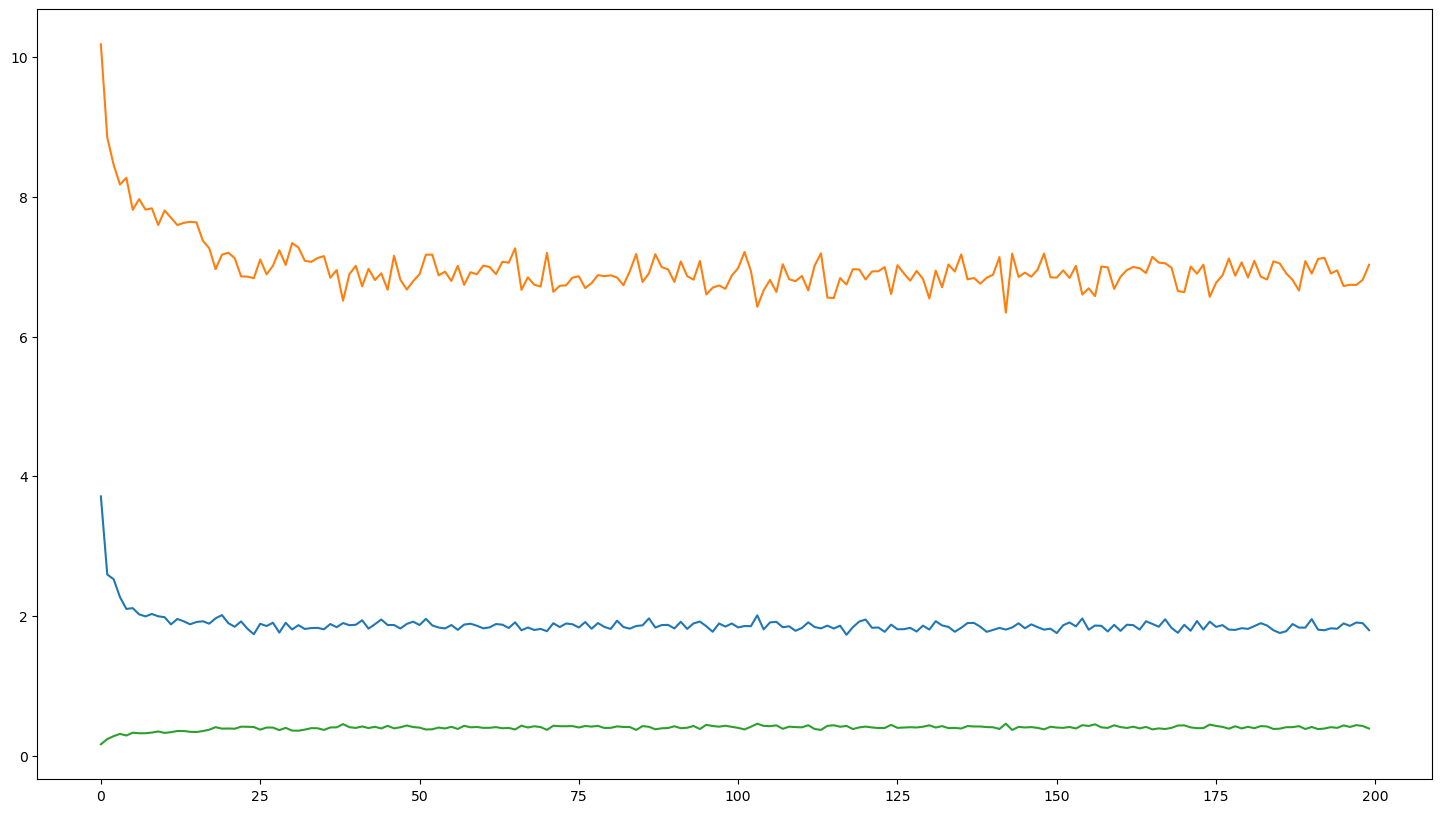

In [165]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_shift_ws_online_continue['Gen_D_KL']))
ax.plot(np.array(Analytic_shift_ws_online_continue['Data_D_KL']))
ax.plot(np.array(Analytic_shift_ws_online_continue['Accuracy']))
plt.show()

In [166]:
Analytic_shift_ws_online_continue.to_csv('Analytic_shift_ws_online_continue.csv', index = False)

In [167]:
parameters = {'Phi': Phi, 'Theta': Theta}
np.save('Parameters_shift_ws_online_continue',parameters)

### 2. Train with Mutual Information Maximization (Shift Patterns)

In [52]:
para = np.load('Parameters_shift_ws_online.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

D:\Program\anaconda3\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [53]:
Analytic_shift_ws_online_MI = pd.read_csv('Analytic_shift_ws_online.csv', sep=",")
Analytic_shift_ws_online_MI

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,...,Gen_H_Layer_5,Gen_H_Layer_6,Gen_H_Layer_7,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7
0,0.655633,0.571985,0.558816,0.601158,0.625530,0.634833,0.640671,0.477506,0.679399,0.581523,...,3.714419,2.628021,1.358096,1.088946,0.713392,0.402592,0.337388,0.279556,0.180200,0.101256
1,0.393723,0.411351,0.459724,0.487509,0.530218,0.538705,0.522781,0.271545,0.465700,0.430444,...,3.814557,2.617047,1.295791,3.375550,1.757976,1.465564,0.964380,0.754626,0.517842,0.199070
2,0.382757,0.359798,0.446301,0.450049,0.496051,0.529376,0.468505,0.265308,0.445660,0.395902,...,3.588273,2.402690,1.249453,3.621478,2.162318,1.633370,1.073516,0.734443,0.452110,0.373176
3,0.351038,0.363958,0.438509,0.457817,0.441942,0.540376,0.365396,0.222303,0.437571,0.394547,...,3.500305,2.642266,1.076303,4.059014,2.105663,1.528430,1.129873,0.915961,0.642489,0.296746
4,0.344868,0.346568,0.401235,0.477702,0.400480,0.555822,0.345918,0.234545,0.411906,0.392750,...,3.163184,2.661177,1.002520,4.254811,2.474658,1.676711,1.197370,0.854317,0.599261,0.313349
5,0.338268,0.388712,0.370925,0.443044,0.406164,0.533542,0.450682,0.225307,0.430211,0.419475,...,3.436745,2.568102,1.265192,4.345956,2.188493,1.726964,1.375439,1.044914,0.586289,0.355859
6,0.316292,0.374113,0.371071,0.444821,0.368850,0.543453,0.380353,0.218211,0.392685,0.438181,...,3.112378,2.663256,0.969777,4.455096,2.546635,1.647743,1.325200,1.100924,0.618887,0.290378
7,0.321583,0.362221,0.397129,0.394117,0.380266,0.529545,0.438540,0.214933,0.401921,0.414556,...,3.170792,2.654225,1.031400,4.441648,2.490747,1.747180,1.521348,1.126132,0.594190,0.339259
8,0.307962,0.386547,0.359955,0.417630,0.380542,0.520597,0.396693,0.207846,0.395886,0.427196,...,3.286913,2.632394,1.086438,4.587523,2.445494,1.794885,1.482712,1.074620,0.657527,0.390613
9,0.302032,0.341282,0.352739,0.411689,0.381739,0.530541,0.370813,0.214072,0.387203,0.386165,...,3.118032,2.671695,1.041100,4.372247,2.453001,1.760852,1.491712,1.044269,0.626255,0.379664


In [54]:
T,Epsilon,Eta = initialize_MI(Shift_pattern_data(10000,dev).reshape(16,-1),Phi,lr,dev)
print('Epsilon: ',Epsilon)
print('Eta: ',Eta)
print('T: ',T)

NameError: name 'lr' is not defined

In [55]:
batch_size = 1
lr = 0.1
epoch = 1500
gen_batch_size = 100000
n_data

1000

In [56]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    data = Shift_pattern_data(n_data,dev).reshape(16,n_data)
    index = np.random.permutation(n_data)
    T,Epsilon,Eta = initialize_MI(Shift_pattern_data(10000,dev).reshape(16,-1),Phi,lr,dev)
    for i in range(n_data):
        if i%10 == 0:
            Theta, Loss_sleep, T = wake_phase_MI(Phi,Theta,data[:,index[i]:index[i]+1],lr,T,Epsilon,Eta,dev)
        else:
            Theta, Loss_sleep, T = wake_phase_update(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,T,Eta)
        # Sleep Phase
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    if e%10 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        
        gen_data = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
        values_g,counts_g = np.unique(decimalize_np(gen_data),return_counts=True)
        gen_dist = torch.zeros(2**n_d,device=dev)
        gen_dist[values_g]=torch.from_numpy(counts_g).to(dev)/gen_batch_size

        stat.append(KL_divergence(gen_dist,data_dist).item())
        stat.append(KL_divergence(data_dist,gen_dist).item())
        
        k = 0
        for j in range(gen_data.shape[1]):
            if torch.equal(gen_data[:8,j], torch.cat((gen_data[9:,j],gen_data[8:9,j]))) or \
                torch.equal(gen_data[:8,j], torch.cat((gen_data[-1:,j],gen_data[8:-1,j]))):
                k += 1
        stat.append(k/gen_batch_size)
        print(k/gen_batch_size)
        
        H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,100),dev) # batch_size = 100000
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.numpy()) + list(I_wake.numpy()) + list(H_Y_sleep.numpy()) + list(I_sleep.numpy())
        Analytic_shift_ws_online_MI.loc[len(Analytic_shift_ws_online_MI)] = stat

Loss_wake: tensor([0.0000, 0.2668, 0.2781, 0.3102, 0.3229, 0.3010, 0.4283, 0.3629])     Loss_sleep: tensor([0.1840, 0.3436, 0.3231, 0.3414, 0.3389, 0.3809, 0.5174, 0.6019])
0.38825
Loss_wake: tensor([0.0000, 0.2754, 0.2576, 0.3301, 0.2917, 0.3007, 0.3786, 0.3836])     Loss_sleep: tensor([0.1760, 0.3507, 0.3061, 0.3478, 0.3214, 0.3713, 0.4470, 0.6842])
Loss_wake: tensor([0.0000, 0.2691, 0.2716, 0.3306, 0.3033, 0.2823, 0.3762, 0.3347])     Loss_sleep: tensor([0.1848, 0.3564, 0.3124, 0.3515, 0.3246, 0.3495, 0.4370, 0.6846])
Loss_wake: tensor([0.0000, 0.2877, 0.2630, 0.3288, 0.2976, 0.3196, 0.3491, 0.3865])     Loss_sleep: tensor([0.1740, 0.3547, 0.3100, 0.3665, 0.3255, 0.3765, 0.4312, 0.6844])
Loss_wake: tensor([0.0000, 0.2843, 0.2631, 0.3374, 0.3100, 0.3217, 0.3681, 0.3897])     Loss_sleep: tensor([0.1738, 0.3454, 0.3235, 0.3435, 0.3459, 0.3634, 0.4553, 0.6801])
Loss_wake: tensor([0.0000, 0.2736, 0.2755, 0.3356, 0.3177, 0.3316, 0.3713, 0.3669])     Loss_sleep: tensor([0.1756, 0.3453, 0.3

Loss_wake: tensor([0.0000, 0.2694, 0.2703, 0.3052, 0.2903, 0.2662, 0.3153, 0.3699])     Loss_sleep: tensor([0.1609, 0.3372, 0.3178, 0.3447, 0.3118, 0.3161, 0.4586, 0.6706])
Loss_wake: tensor([0.0000, 0.2646, 0.2778, 0.3087, 0.3077, 0.2623, 0.2968, 0.3669])     Loss_sleep: tensor([0.1748, 0.3270, 0.3371, 0.3343, 0.3238, 0.3351, 0.4418, 0.6749])
Loss_wake: tensor([0.0000, 0.2572, 0.2827, 0.3002, 0.3133, 0.2587, 0.3440, 0.3558])     Loss_sleep: tensor([0.1578, 0.3312, 0.3222, 0.3341, 0.3282, 0.3279, 0.4685, 0.6412])
0.40422
Loss_wake: tensor([0.0000, 0.2584, 0.2826, 0.2987, 0.3070, 0.2474, 0.3379, 0.3491])     Loss_sleep: tensor([0.1770, 0.3231, 0.3270, 0.3339, 0.3345, 0.3217, 0.4911, 0.6246])
Loss_wake: tensor([0.0000, 0.2483, 0.2758, 0.2789, 0.3114, 0.2608, 0.3393, 0.3516])     Loss_sleep: tensor([0.1720, 0.3207, 0.3336, 0.3207, 0.3326, 0.3153, 0.4687, 0.6449])
Loss_wake: tensor([0.0000, 0.2608, 0.2569, 0.2891, 0.2755, 0.2624, 0.2828, 0.3703])     Loss_sleep: tensor([0.1634, 0.3276, 0.3

Loss_wake: tensor([0.0000, 0.2740, 0.2607, 0.2886, 0.2703, 0.2482, 0.2961, 0.3594])     Loss_sleep: tensor([0.1725, 0.3332, 0.3045, 0.3195, 0.2991, 0.3175, 0.4237, 0.6833])
Loss_wake: tensor([0.0000, 0.2712, 0.2660, 0.2841, 0.2835, 0.2304, 0.3009, 0.3354])     Loss_sleep: tensor([0.1751, 0.3327, 0.3060, 0.3170, 0.3048, 0.3124, 0.4318, 0.6815])
Loss_wake: tensor([0.0000, 0.2613, 0.2608, 0.2695, 0.2889, 0.2486, 0.3251, 0.3447])     Loss_sleep: tensor([0.1731, 0.3337, 0.2999, 0.3233, 0.3019, 0.3258, 0.4484, 0.6577])
Loss_wake: tensor([0.0000, 0.2799, 0.2741, 0.2861, 0.2908, 0.2615, 0.3180, 0.3634])     Loss_sleep: tensor([0.1737, 0.3390, 0.3159, 0.3113, 0.3199, 0.3204, 0.4582, 0.6585])
Loss_wake: tensor([0.0000, 0.2709, 0.2672, 0.2776, 0.3123, 0.2657, 0.3525, 0.3412])     Loss_sleep: tensor([0.1677, 0.3211, 0.3062, 0.3129, 0.3243, 0.3332, 0.4572, 0.6480])
0.40534
Loss_wake: tensor([0.0000, 0.2522, 0.2667, 0.2731, 0.2896, 0.2493, 0.3273, 0.3607])     Loss_sleep: tensor([0.1710, 0.3231, 0.3

Loss_wake: tensor([0.0000, 0.2738, 0.2709, 0.2691, 0.3164, 0.2500, 0.2912, 0.3428])     Loss_sleep: tensor([0.1743, 0.3193, 0.3322, 0.2917, 0.3427, 0.2977, 0.4450, 0.6561])
Loss_wake: tensor([0.0000, 0.2721, 0.2568, 0.2716, 0.3030, 0.2620, 0.2995, 0.3532])     Loss_sleep: tensor([0.1681, 0.3307, 0.3162, 0.3060, 0.3211, 0.3060, 0.4407, 0.6673])
Loss_wake: tensor([0.0000, 0.2829, 0.2690, 0.2782, 0.3121, 0.2585, 0.3286, 0.3293])     Loss_sleep: tensor([0.1756, 0.3220, 0.3099, 0.2999, 0.3330, 0.3112, 0.4638, 0.6519])
Loss_wake: tensor([0.0000, 0.2777, 0.2641, 0.2676, 0.2949, 0.2380, 0.3037, 0.3476])     Loss_sleep: tensor([0.1748, 0.3151, 0.3165, 0.2923, 0.3205, 0.2851, 0.4654, 0.6421])
Loss_wake: tensor([0.0000, 0.2712, 0.2715, 0.2701, 0.2943, 0.2532, 0.3030, 0.3491])     Loss_sleep: tensor([0.1758, 0.3232, 0.3048, 0.3089, 0.3205, 0.2920, 0.4549, 0.6576])
Loss_wake: tensor([0.0000, 0.2626, 0.2674, 0.2705, 0.3103, 0.2462, 0.3144, 0.3309])     Loss_sleep: tensor([0.1710, 0.3252, 0.3113, 0.3

Loss_wake: tensor([0.0000, 0.2769, 0.2676, 0.2514, 0.2964, 0.2303, 0.2823, 0.3402])     Loss_sleep: tensor([0.1706, 0.3401, 0.3126, 0.2924, 0.3182, 0.2987, 0.4277, 0.6644])
Loss_wake: tensor([0.0000, 0.2731, 0.2653, 0.2617, 0.3020, 0.2548, 0.2730, 0.3547])     Loss_sleep: tensor([0.1691, 0.3274, 0.3189, 0.3050, 0.3236, 0.3220, 0.4131, 0.6734])
Loss_wake: tensor([0.0000, 0.2718, 0.2641, 0.2671, 0.3112, 0.2395, 0.2811, 0.3330])     Loss_sleep: tensor([0.1725, 0.3259, 0.3138, 0.3097, 0.3254, 0.2988, 0.4205, 0.6763])
Loss_wake: tensor([0.0000, 0.2853, 0.2500, 0.2652, 0.3048, 0.2349, 0.2683, 0.3413])     Loss_sleep: tensor([0.1626, 0.3226, 0.3007, 0.2969, 0.3122, 0.2973, 0.4161, 0.6749])
Loss_wake: tensor([0.0000, 0.2755, 0.2590, 0.2624, 0.2999, 0.2384, 0.2743, 0.3522])     Loss_sleep: tensor([0.1699, 0.3170, 0.3102, 0.2915, 0.3166, 0.3107, 0.4105, 0.6760])
Loss_wake: tensor([0.0000, 0.2735, 0.2529, 0.2341, 0.2994, 0.2361, 0.2761, 0.3437])     Loss_sleep: tensor([0.1620, 0.3136, 0.3042, 0.3

Loss_wake: tensor([0.0000, 0.2792, 0.2583, 0.2742, 0.3031, 0.2706, 0.3458, 0.2486])     Loss_sleep: tensor([0.1642, 0.3255, 0.3017, 0.3084, 0.3294, 0.3474, 0.4343, 0.5815])
0.3859
Loss_wake: tensor([0.0000, 0.2755, 0.2602, 0.2953, 0.2955, 0.2329, 0.3006, 0.2416])     Loss_sleep: tensor([0.1820, 0.3093, 0.3230, 0.3124, 0.3225, 0.3278, 0.4176, 0.5898])
Loss_wake: tensor([0.0000, 0.2697, 0.2631, 0.2840, 0.3130, 0.2453, 0.3022, 0.2271])     Loss_sleep: tensor([0.1737, 0.3079, 0.3272, 0.3097, 0.3300, 0.3284, 0.4330, 0.5779])
Loss_wake: tensor([0.0000, 0.2766, 0.2500, 0.2820, 0.2984, 0.2523, 0.3119, 0.2337])     Loss_sleep: tensor([0.1629, 0.3176, 0.3167, 0.2974, 0.3202, 0.3220, 0.4345, 0.5626])
Loss_wake: tensor([0.0000, 0.2748, 0.2511, 0.2841, 0.2981, 0.2499, 0.3112, 0.2596])     Loss_sleep: tensor([0.1704, 0.3107, 0.3046, 0.3036, 0.3256, 0.3264, 0.4346, 0.5797])
Loss_wake: tensor([0.0000, 0.2745, 0.2580, 0.2710, 0.3018, 0.2403, 0.3179, 0.2243])     Loss_sleep: tensor([0.1802, 0.3073, 0.31

Loss_wake: tensor([0.0000, 0.2764, 0.2678, 0.3071, 0.3084, 0.2576, 0.3310, 0.2470])     Loss_sleep: tensor([0.1767, 0.3221, 0.3252, 0.3375, 0.3357, 0.3395, 0.4118, 0.6105])
Loss_wake: tensor([0.0000, 0.2765, 0.2656, 0.2848, 0.2917, 0.2475, 0.3131, 0.2549])     Loss_sleep: tensor([0.1729, 0.3150, 0.3190, 0.3382, 0.3057, 0.3203, 0.4183, 0.5889])
Loss_wake: tensor([0.0000, 0.2615, 0.2708, 0.2642, 0.3003, 0.2304, 0.3186, 0.2034])     Loss_sleep: tensor([0.1694, 0.3148, 0.3181, 0.3202, 0.3049, 0.3165, 0.4366, 0.5659])
0.39975
Loss_wake: tensor([0.0000, 0.2826, 0.2630, 0.2847, 0.2714, 0.2457, 0.3039, 0.2208])     Loss_sleep: tensor([0.1633, 0.3311, 0.3074, 0.3273, 0.2938, 0.3311, 0.3981, 0.5879])
Loss_wake: tensor([0.0000, 0.2787, 0.2585, 0.2961, 0.2824, 0.2689, 0.2989, 0.2365])     Loss_sleep: tensor([0.1765, 0.3195, 0.3058, 0.3431, 0.2961, 0.3319, 0.4058, 0.6073])
Loss_wake: tensor([0.0000, 0.2720, 0.2581, 0.2948, 0.2813, 0.2527, 0.3163, 0.2338])     Loss_sleep: tensor([0.1667, 0.3196, 0.3

Loss_wake: tensor([0.0000, 0.2581, 0.2547, 0.2889, 0.3009, 0.2525, 0.3174, 0.2434])     Loss_sleep: tensor([0.1743, 0.3189, 0.3094, 0.3203, 0.3113, 0.3264, 0.4470, 0.5774])
Loss_wake: tensor([0.0000, 0.2711, 0.2311, 0.2903, 0.2869, 0.2587, 0.2970, 0.2407])     Loss_sleep: tensor([0.1687, 0.3167, 0.3013, 0.3287, 0.3162, 0.3282, 0.4125, 0.5960])
Loss_wake: tensor([0.0000, 0.2641, 0.2485, 0.2843, 0.2868, 0.2367, 0.2897, 0.2378])     Loss_sleep: tensor([0.1700, 0.3134, 0.2990, 0.3255, 0.3149, 0.3194, 0.4310, 0.5720])
Loss_wake: tensor([0.0000, 0.2744, 0.2546, 0.2876, 0.3064, 0.2412, 0.3057, 0.2184])     Loss_sleep: tensor([0.1682, 0.3034, 0.3205, 0.3190, 0.3309, 0.3119, 0.4334, 0.5627])
Loss_wake: tensor([0.0000, 0.2841, 0.2301, 0.2993, 0.2970, 0.2412, 0.2818, 0.2418])     Loss_sleep: tensor([0.1639, 0.3261, 0.2921, 0.3322, 0.3120, 0.3159, 0.4050, 0.5841])
0.44455
Loss_wake: tensor([0.0000, 0.2678, 0.2707, 0.2835, 0.3076, 0.2493, 0.3219, 0.2328])     Loss_sleep: tensor([0.1711, 0.3207, 0.3

Loss_wake: tensor([0.0000, 0.2727, 0.2511, 0.2604, 0.3095, 0.2276, 0.3332, 0.2233])     Loss_sleep: tensor([0.1697, 0.3167, 0.2996, 0.3199, 0.3209, 0.3151, 0.4466, 0.5485])
Loss_wake: tensor([0.0000, 0.2954, 0.2386, 0.2742, 0.3059, 0.2431, 0.3191, 0.2183])     Loss_sleep: tensor([0.1663, 0.3068, 0.3041, 0.3169, 0.3373, 0.3161, 0.4468, 0.5566])
Loss_wake: tensor([0.0000, 0.2717, 0.2515, 0.2840, 0.2941, 0.2272, 0.3122, 0.2420])     Loss_sleep: tensor([0.1782, 0.3073, 0.3064, 0.3197, 0.3095, 0.3146, 0.4432, 0.5697])
Loss_wake: tensor([0.0000, 0.2822, 0.2561, 0.2890, 0.2886, 0.2522, 0.3024, 0.2488])     Loss_sleep: tensor([0.1684, 0.3163, 0.3055, 0.3143, 0.3112, 0.3187, 0.4315, 0.5814])
Loss_wake: tensor([0.0000, 0.2715, 0.2472, 0.2769, 0.3066, 0.2211, 0.3276, 0.2117])     Loss_sleep: tensor([0.1597, 0.3199, 0.2974, 0.3179, 0.3133, 0.3190, 0.4308, 0.5731])
Loss_wake: tensor([0.0000, 0.2891, 0.2411, 0.2688, 0.2909, 0.2221, 0.3244, 0.2072])     Loss_sleep: tensor([0.1687, 0.3181, 0.3021, 0.3

Loss_wake: tensor([0.0000, 0.2770, 0.2544, 0.2866, 0.2911, 0.2598, 0.3186, 0.2212])     Loss_sleep: tensor([0.1654, 0.3236, 0.3037, 0.3469, 0.2963, 0.3313, 0.4357, 0.5713])
Loss_wake: tensor([0.0000, 0.2928, 0.2577, 0.2974, 0.2843, 0.2556, 0.3227, 0.2254])     Loss_sleep: tensor([0.1605, 0.3304, 0.3040, 0.3363, 0.3130, 0.3165, 0.4322, 0.5725])
Loss_wake: tensor([0.0000, 0.2970, 0.2411, 0.3119, 0.2806, 0.2544, 0.3084, 0.2141])     Loss_sleep: tensor([0.1674, 0.3243, 0.3095, 0.3405, 0.3060, 0.3205, 0.4533, 0.5588])
Loss_wake: tensor([0.0000, 0.2942, 0.2415, 0.3116, 0.2782, 0.2399, 0.3122, 0.2283])     Loss_sleep: tensor([0.1684, 0.3325, 0.3025, 0.3401, 0.3084, 0.3326, 0.4490, 0.5489])
Loss_wake: tensor([0.0000, 0.2686, 0.2621, 0.2706, 0.2919, 0.2224, 0.3244, 0.2048])     Loss_sleep: tensor([0.1709, 0.3128, 0.3082, 0.3155, 0.3129, 0.3170, 0.4502, 0.5286])
Loss_wake: tensor([0.0000, 0.2794, 0.2557, 0.2922, 0.2853, 0.2289, 0.3406, 0.1962])     Loss_sleep: tensor([0.1773, 0.3283, 0.3093, 0.3

Loss_wake: tensor([0.0000, 0.2960, 0.2394, 0.2990, 0.2893, 0.2483, 0.3161, 0.2063])     Loss_sleep: tensor([0.1619, 0.3223, 0.3059, 0.3240, 0.3245, 0.3334, 0.4266, 0.5688])
0.41624
Loss_wake: tensor([0.0000, 0.2922, 0.2682, 0.2663, 0.3090, 0.2397, 0.3594, 0.2030])     Loss_sleep: tensor([0.1683, 0.3248, 0.3249, 0.3053, 0.3273, 0.3156, 0.4555, 0.5513])
Loss_wake: tensor([0.0000, 0.2927, 0.2644, 0.2888, 0.3213, 0.2200, 0.3277, 0.2031])     Loss_sleep: tensor([0.1650, 0.3206, 0.3200, 0.3188, 0.3258, 0.3142, 0.4536, 0.5404])
Loss_wake: tensor([0.0000, 0.2898, 0.2530, 0.2890, 0.2981, 0.2436, 0.3414, 0.2070])     Loss_sleep: tensor([0.1643, 0.3144, 0.3101, 0.3296, 0.3263, 0.3150, 0.4409, 0.5617])
Loss_wake: tensor([0.0000, 0.2895, 0.2403, 0.2933, 0.2864, 0.2404, 0.3230, 0.2247])     Loss_sleep: tensor([0.1741, 0.3174, 0.3056, 0.3338, 0.3173, 0.3273, 0.4357, 0.5636])
Loss_wake: tensor([0.0000, 0.2748, 0.2517, 0.2899, 0.2844, 0.2495, 0.3114, 0.2283])     Loss_sleep: tensor([0.1729, 0.3037, 0.3

Loss_wake: tensor([0.0000, 0.2914, 0.2515, 0.3320, 0.2915, 0.2354, 0.3355, 0.2084])     Loss_sleep: tensor([0.1712, 0.3185, 0.3093, 0.3615, 0.3192, 0.3089, 0.4470, 0.5448])
Loss_wake: tensor([0.0000, 0.2853, 0.2502, 0.3220, 0.2838, 0.2663, 0.2862, 0.2354])     Loss_sleep: tensor([0.1641, 0.3313, 0.3073, 0.3587, 0.3003, 0.3502, 0.3917, 0.6065])
Loss_wake: tensor([0.0000, 0.3073, 0.2464, 0.3332, 0.2808, 0.2396, 0.3065, 0.2049])     Loss_sleep: tensor([0.1776, 0.3090, 0.3176, 0.3529, 0.2919, 0.3088, 0.4351, 0.5526])
0.37803
Loss_wake: tensor([0.0000, 0.2907, 0.2399, 0.3197, 0.2783, 0.2325, 0.2989, 0.2024])     Loss_sleep: tensor([0.1678, 0.3313, 0.3030, 0.3433, 0.2923, 0.3217, 0.4138, 0.5696])
Loss_wake: tensor([0.0000, 0.2807, 0.2448, 0.3207, 0.2810, 0.2356, 0.3176, 0.1989])     Loss_sleep: tensor([0.1571, 0.3358, 0.3080, 0.3397, 0.3018, 0.3183, 0.4146, 0.5744])
Loss_wake: tensor([0.0000, 0.2979, 0.2499, 0.3411, 0.2674, 0.2469, 0.3142, 0.1931])     Loss_sleep: tensor([0.1595, 0.3323, 0.3

Loss_wake: tensor([0.0000, 0.2693, 0.2422, 0.3298, 0.2794, 0.2929, 0.2940, 0.2257])     Loss_sleep: tensor([0.1689, 0.3181, 0.3088, 0.3608, 0.3152, 0.3477, 0.4169, 0.5892])
Loss_wake: tensor([0.0000, 0.2700, 0.2437, 0.3069, 0.2831, 0.2779, 0.3045, 0.2147])     Loss_sleep: tensor([0.1651, 0.2953, 0.3035, 0.3487, 0.3239, 0.3327, 0.4263, 0.5699])
Loss_wake: tensor([0.0000, 0.2850, 0.2497, 0.3171, 0.2828, 0.2851, 0.3048, 0.2356])     Loss_sleep: tensor([0.1679, 0.3143, 0.3052, 0.3574, 0.3157, 0.3359, 0.4128, 0.5887])
Loss_wake: tensor([0.0000, 0.2830, 0.2331, 0.3239, 0.2847, 0.2543, 0.3047, 0.2273])     Loss_sleep: tensor([0.1624, 0.3261, 0.3012, 0.3578, 0.3145, 0.3268, 0.4417, 0.5666])
Loss_wake: tensor([0.0000, 0.2851, 0.2396, 0.3295, 0.2835, 0.2692, 0.3302, 0.2291])     Loss_sleep: tensor([0.1603, 0.3177, 0.3033, 0.3589, 0.3235, 0.3531, 0.4591, 0.5536])
0.41269
Loss_wake: tensor([0.0000, 0.2783, 0.2546, 0.3161, 0.2986, 0.2795, 0.2972, 0.2182])     Loss_sleep: tensor([0.1771, 0.3158, 0.3

Loss_wake: tensor([0.0000, 0.2874, 0.2395, 0.2986, 0.2662, 0.2606, 0.2752, 0.2331])     Loss_sleep: tensor([0.1645, 0.3248, 0.2941, 0.3275, 0.2936, 0.3396, 0.4060, 0.5979])
Loss_wake: tensor([0.0000, 0.2986, 0.2497, 0.3040, 0.2703, 0.2703, 0.2952, 0.2283])     Loss_sleep: tensor([0.1639, 0.3324, 0.3072, 0.3372, 0.3040, 0.3494, 0.4227, 0.5684])
Loss_wake: tensor([0.0000, 0.2819, 0.2524, 0.2918, 0.2801, 0.2583, 0.3094, 0.2060])     Loss_sleep: tensor([0.1574, 0.3380, 0.2955, 0.3347, 0.3030, 0.3345, 0.4279, 0.5636])
Loss_wake: tensor([0.0000, 0.2879, 0.2503, 0.2970, 0.2821, 0.2650, 0.3185, 0.2319])     Loss_sleep: tensor([0.1655, 0.3376, 0.2985, 0.3439, 0.2987, 0.3398, 0.4340, 0.5708])
Loss_wake: tensor([0.0000, 0.2771, 0.2516, 0.3132, 0.2652, 0.2536, 0.3162, 0.2342])     Loss_sleep: tensor([0.1720, 0.3227, 0.2914, 0.3429, 0.3026, 0.3406, 0.4479, 0.5558])
Loss_wake: tensor([0.0000, 0.2832, 0.2597, 0.3229, 0.2634, 0.2570, 0.3001, 0.2164])     Loss_sleep: tensor([0.1648, 0.3362, 0.2918, 0.3

Loss_wake: tensor([0.0000, 0.2986, 0.2442, 0.3257, 0.2770, 0.2816, 0.3317, 0.2447])     Loss_sleep: tensor([0.1693, 0.3239, 0.3038, 0.3470, 0.3156, 0.3695, 0.4203, 0.5785])
Loss_wake: tensor([0.0000, 0.2918, 0.2445, 0.3173, 0.2882, 0.2871, 0.3359, 0.2212])     Loss_sleep: tensor([0.1630, 0.3205, 0.3026, 0.3658, 0.3123, 0.3613, 0.4388, 0.5684])
Loss_wake: tensor([0.0000, 0.2912, 0.2419, 0.3182, 0.2760, 0.2681, 0.3357, 0.1856])     Loss_sleep: tensor([0.1638, 0.3254, 0.2957, 0.3568, 0.3060, 0.3501, 0.4479, 0.5467])
Loss_wake: tensor([0.0000, 0.2956, 0.2544, 0.3248, 0.2917, 0.2872, 0.3284, 0.2210])     Loss_sleep: tensor([0.1702, 0.3329, 0.3029, 0.3569, 0.3203, 0.3537, 0.4326, 0.5709])
Loss_wake: tensor([0.0000, 0.2904, 0.2699, 0.3327, 0.2876, 0.2896, 0.3121, 0.2327])     Loss_sleep: tensor([0.1620, 0.3295, 0.3025, 0.3621, 0.3179, 0.3509, 0.4204, 0.5843])
Loss_wake: tensor([0.0000, 0.3013, 0.2495, 0.3263, 0.2801, 0.2925, 0.3153, 0.2211])     Loss_sleep: tensor([0.1690, 0.3367, 0.3128, 0.3

Loss_wake: tensor([0.0000, 0.2809, 0.2568, 0.3355, 0.3065, 0.2877, 0.3302, 0.2142])     Loss_sleep: tensor([0.1708, 0.3300, 0.3036, 0.3817, 0.3333, 0.3593, 0.4379, 0.5635])
0.40845
Loss_wake: tensor([0.0000, 0.2897, 0.2401, 0.3433, 0.2927, 0.2935, 0.3276, 0.2199])     Loss_sleep: tensor([0.1559, 0.3408, 0.2879, 0.3804, 0.3282, 0.3728, 0.4302, 0.5687])
Loss_wake: tensor([0.0000, 0.2792, 0.2369, 0.3161, 0.2745, 0.2764, 0.3236, 0.2116])     Loss_sleep: tensor([0.1667, 0.3135, 0.2860, 0.3667, 0.3109, 0.3526, 0.4370, 0.5600])
Loss_wake: tensor([0.0000, 0.2723, 0.2369, 0.3065, 0.2713, 0.2369, 0.3445, 0.1837])     Loss_sleep: tensor([0.1618, 0.3143, 0.2990, 0.3467, 0.3227, 0.3408, 0.4549, 0.5279])
Loss_wake: tensor([0.0000, 0.2725, 0.2560, 0.2989, 0.3093, 0.2518, 0.3646, 0.1761])     Loss_sleep: tensor([0.1776, 0.3171, 0.3003, 0.3506, 0.3375, 0.3286, 0.4706, 0.5094])
Loss_wake: tensor([0.0000, 0.2739, 0.2297, 0.3200, 0.2585, 0.2478, 0.3413, 0.1872])     Loss_sleep: tensor([0.1643, 0.3226, 0.2

Loss_wake: tensor([0.0000, 0.2646, 0.2342, 0.3094, 0.2508, 0.2594, 0.3297, 0.2144])     Loss_sleep: tensor([0.1760, 0.3115, 0.2735, 0.3435, 0.3037, 0.3406, 0.4434, 0.5500])
Loss_wake: tensor([0.0000, 0.2655, 0.2312, 0.3084, 0.2483, 0.2669, 0.3147, 0.2265])     Loss_sleep: tensor([0.1709, 0.3004, 0.2853, 0.3411, 0.2978, 0.3662, 0.4534, 0.5597])
Loss_wake: tensor([0.0000, 0.2823, 0.2274, 0.3060, 0.2420, 0.2657, 0.3016, 0.2230])     Loss_sleep: tensor([0.1656, 0.3159, 0.2846, 0.3473, 0.2972, 0.3514, 0.4234, 0.5822])
0.42534
Loss_wake: tensor([0.0000, 0.2594, 0.2397, 0.3086, 0.2655, 0.2592, 0.3318, 0.2133])     Loss_sleep: tensor([0.1676, 0.2973, 0.2912, 0.3382, 0.3150, 0.3535, 0.4695, 0.5382])
Loss_wake: tensor([0.0000, 0.2648, 0.2208, 0.2893, 0.2445, 0.2495, 0.3083, 0.2179])     Loss_sleep: tensor([0.1667, 0.3010, 0.2760, 0.3263, 0.2958, 0.3298, 0.4666, 0.5358])
Loss_wake: tensor([0.0000, 0.2790, 0.2381, 0.3088, 0.2450, 0.2541, 0.3233, 0.2350])     Loss_sleep: tensor([0.1676, 0.3197, 0.2

Loss_wake: tensor([0.0000, 0.2820, 0.2436, 0.3250, 0.2484, 0.2808, 0.3034, 0.2288])     Loss_sleep: tensor([0.1687, 0.3289, 0.2834, 0.3574, 0.3180, 0.3641, 0.4281, 0.5767])
Loss_wake: tensor([0.0000, 0.2840, 0.2398, 0.3174, 0.2635, 0.2666, 0.3219, 0.2086])     Loss_sleep: tensor([0.1716, 0.3383, 0.2756, 0.3536, 0.3152, 0.3706, 0.4370, 0.5616])
Loss_wake: tensor([0.0000, 0.2882, 0.2366, 0.3215, 0.2618, 0.2562, 0.3299, 0.2119])     Loss_sleep: tensor([0.1578, 0.3430, 0.2765, 0.3486, 0.3141, 0.3560, 0.4496, 0.5366])
Loss_wake: tensor([0.0000, 0.2964, 0.2398, 0.3246, 0.2612, 0.2743, 0.3214, 0.2255])     Loss_sleep: tensor([0.1697, 0.3261, 0.2864, 0.3372, 0.3241, 0.3610, 0.4205, 0.5721])
Loss_wake: tensor([0.0000, 0.2921, 0.2322, 0.3203, 0.2436, 0.2630, 0.3237, 0.2024])     Loss_sleep: tensor([0.1599, 0.3315, 0.2791, 0.3456, 0.3148, 0.3644, 0.4097, 0.5795])
0.43109
Loss_wake: tensor([0.0000, 0.2898, 0.2334, 0.3222, 0.2532, 0.2745, 0.2887, 0.2381])     Loss_sleep: tensor([0.1649, 0.3297, 0.2

Loss_wake: tensor([0.0000, 0.2960, 0.2511, 0.3336, 0.2782, 0.2870, 0.2988, 0.2287])     Loss_sleep: tensor([0.1709, 0.3229, 0.2929, 0.3551, 0.3305, 0.3719, 0.4280, 0.5849])
Loss_wake: tensor([0.0000, 0.2737, 0.2624, 0.3154, 0.2924, 0.2651, 0.3495, 0.2025])     Loss_sleep: tensor([0.1673, 0.3158, 0.3105, 0.3463, 0.3285, 0.3593, 0.4779, 0.5223])
Loss_wake: tensor([0.0000, 0.2833, 0.2484, 0.3241, 0.2808, 0.2694, 0.3310, 0.2234])     Loss_sleep: tensor([0.1670, 0.3308, 0.2974, 0.3470, 0.3385, 0.3588, 0.4433, 0.5604])
Loss_wake: tensor([0.0000, 0.2940, 0.2374, 0.3215, 0.2635, 0.2743, 0.3133, 0.2568])     Loss_sleep: tensor([0.1668, 0.3321, 0.2713, 0.3519, 0.3224, 0.3689, 0.4333, 0.5780])
Loss_wake: tensor([0.0000, 0.2857, 0.2320, 0.3365, 0.2439, 0.2720, 0.3222, 0.2110])     Loss_sleep: tensor([0.1618, 0.3397, 0.2796, 0.3628, 0.3095, 0.3705, 0.4375, 0.5641])
Loss_wake: tensor([0.0000, 0.2677, 0.2265, 0.3181, 0.2523, 0.2618, 0.3205, 0.2115])     Loss_sleep: tensor([0.1835, 0.3042, 0.2905, 0.3

Loss_wake: tensor([0.0000, 0.2919, 0.2268, 0.3277, 0.2473, 0.2563, 0.3518, 0.1805])     Loss_sleep: tensor([0.1719, 0.3179, 0.2824, 0.3426, 0.3087, 0.3352, 0.4654, 0.5131])
Loss_wake: tensor([0.0000, 0.2838, 0.2348, 0.3144, 0.2407, 0.2518, 0.3304, 0.1878])     Loss_sleep: tensor([0.1719, 0.3292, 0.2774, 0.3286, 0.3003, 0.3300, 0.4816, 0.4936])
Loss_wake: tensor([0.0000, 0.2942, 0.2339, 0.3179, 0.2495, 0.2536, 0.3306, 0.2177])     Loss_sleep: tensor([0.1635, 0.3258, 0.2898, 0.3423, 0.2980, 0.3401, 0.4622, 0.5291])
Loss_wake: tensor([0.0000, 0.2889, 0.2413, 0.2981, 0.2514, 0.2513, 0.3391, 0.1899])     Loss_sleep: tensor([0.1782, 0.3213, 0.2866, 0.3308, 0.2967, 0.3427, 0.4719, 0.5259])
Loss_wake: tensor([0.0000, 0.2769, 0.2468, 0.2994, 0.2458, 0.2428, 0.3132, 0.1986])     Loss_sleep: tensor([0.1656, 0.3232, 0.2799, 0.3433, 0.2840, 0.3334, 0.4601, 0.5320])
Loss_wake: tensor([0.0000, 0.2979, 0.2244, 0.3058, 0.2275, 0.2470, 0.3309, 0.2036])     Loss_sleep: tensor([0.1649, 0.3343, 0.2624, 0.3

Loss_wake: tensor([0.0000, 0.2981, 0.2134, 0.3084, 0.2225, 0.2745, 0.3194, 0.1992])     Loss_sleep: tensor([0.1527, 0.3088, 0.2613, 0.3234, 0.3000, 0.3659, 0.4343, 0.5464])
0.46036
Loss_wake: tensor([0.0000, 0.2941, 0.2066, 0.3187, 0.2104, 0.2608, 0.3190, 0.1870])     Loss_sleep: tensor([0.1653, 0.2977, 0.2799, 0.3295, 0.2998, 0.3562, 0.4335, 0.5452])
Loss_wake: tensor([0.0000, 0.2928, 0.2151, 0.3055, 0.2098, 0.2755, 0.3427, 0.2009])     Loss_sleep: tensor([0.1654, 0.2980, 0.2665, 0.3233, 0.2974, 0.3447, 0.4367, 0.5460])
Loss_wake: tensor([0.0000, 0.3029, 0.2021, 0.3104, 0.1986, 0.2786, 0.3253, 0.1981])     Loss_sleep: tensor([0.1547, 0.3049, 0.2564, 0.3233, 0.2958, 0.3411, 0.4442, 0.5358])
Loss_wake: tensor([0.0000, 0.2979, 0.2077, 0.3209, 0.2082, 0.2939, 0.3255, 0.1893])     Loss_sleep: tensor([0.1635, 0.3156, 0.2600, 0.3518, 0.2891, 0.3399, 0.4334, 0.5292])
Loss_wake: tensor([0.0000, 0.2874, 0.2228, 0.3130, 0.2062, 0.2685, 0.3051, 0.1916])     Loss_sleep: tensor([0.1635, 0.2986, 0.2

Loss_wake: tensor([0.0000, 0.2824, 0.2298, 0.3001, 0.2465, 0.2526, 0.3198, 0.1952])     Loss_sleep: tensor([0.1610, 0.3088, 0.2719, 0.3346, 0.2874, 0.3402, 0.4444, 0.5573])
Loss_wake: tensor([0.0000, 0.2948, 0.2383, 0.3118, 0.2528, 0.2539, 0.2995, 0.2156])     Loss_sleep: tensor([0.1684, 0.3189, 0.2886, 0.3402, 0.2913, 0.3295, 0.4275, 0.5650])
Loss_wake: tensor([0.0000, 0.2880, 0.2324, 0.3022, 0.2455, 0.2456, 0.3404, 0.2057])     Loss_sleep: tensor([0.1719, 0.2952, 0.2999, 0.3385, 0.3025, 0.3297, 0.4833, 0.5186])
0.42259
Loss_wake: tensor([0.0000, 0.2948, 0.2279, 0.2917, 0.2639, 0.2666, 0.3277, 0.1878])     Loss_sleep: tensor([0.1595, 0.2996, 0.2876, 0.3336, 0.3203, 0.3376, 0.4721, 0.5228])
Loss_wake: tensor([0.0000, 0.2816, 0.2271, 0.2845, 0.2645, 0.2584, 0.3135, 0.2060])     Loss_sleep: tensor([0.1662, 0.2873, 0.2841, 0.3300, 0.3096, 0.3369, 0.4301, 0.5524])
Loss_wake: tensor([0.0000, 0.2808, 0.2268, 0.2919, 0.2458, 0.2415, 0.3190, 0.2127])     Loss_sleep: tensor([0.1597, 0.3044, 0.2

Loss_wake: tensor([0.0000, 0.2879, 0.2291, 0.3194, 0.2606, 0.2746, 0.3069, 0.2170])     Loss_sleep: tensor([0.1688, 0.3062, 0.2787, 0.3590, 0.2974, 0.3547, 0.4041, 0.5876])
Loss_wake: tensor([0.0000, 0.2838, 0.2232, 0.3005, 0.2592, 0.2498, 0.3129, 0.2224])     Loss_sleep: tensor([0.1602, 0.3078, 0.2836, 0.3431, 0.2937, 0.3452, 0.4280, 0.5600])
Loss_wake: tensor([0.0000, 0.2893, 0.2171, 0.2949, 0.2481, 0.2337, 0.3242, 0.1908])     Loss_sleep: tensor([0.1650, 0.3104, 0.2780, 0.3407, 0.2800, 0.3318, 0.4516, 0.5317])
Loss_wake: tensor([0.0000, 0.2956, 0.2376, 0.2986, 0.2565, 0.2470, 0.2964, 0.2005])     Loss_sleep: tensor([0.1752, 0.3153, 0.2812, 0.3333, 0.2945, 0.3343, 0.4413, 0.5428])
Loss_wake: tensor([0.0000, 0.2856, 0.2496, 0.2895, 0.2662, 0.2473, 0.2918, 0.1982])     Loss_sleep: tensor([0.1671, 0.3192, 0.2923, 0.3469, 0.3022, 0.3237, 0.4119, 0.5436])
0.38585
Loss_wake: tensor([0.0000, 0.2953, 0.2257, 0.3170, 0.2494, 0.2674, 0.3174, 0.2120])     Loss_sleep: tensor([0.1533, 0.3097, 0.2

Loss_wake: tensor([0.0000, 0.3086, 0.2336, 0.3123, 0.2276, 0.2507, 0.2999, 0.2450])     Loss_sleep: tensor([0.1528, 0.3257, 0.2812, 0.3430, 0.2731, 0.3523, 0.4526, 0.5505])
Loss_wake: tensor([0.0000, 0.3012, 0.2348, 0.2997, 0.2341, 0.2453, 0.3186, 0.2035])     Loss_sleep: tensor([0.1521, 0.3157, 0.2824, 0.3390, 0.2912, 0.3258, 0.4930, 0.4954])
Loss_wake: tensor([0.0000, 0.3107, 0.2167, 0.3243, 0.2214, 0.2504, 0.3113, 0.2019])     Loss_sleep: tensor([0.1469, 0.3235, 0.2792, 0.3521, 0.2750, 0.3254, 0.4692, 0.5269])
Loss_wake: tensor([0.0000, 0.3036, 0.2226, 0.3155, 0.2177, 0.2268, 0.3222, 0.1965])     Loss_sleep: tensor([0.1554, 0.3271, 0.2732, 0.3342, 0.2702, 0.3223, 0.4505, 0.5327])
Loss_wake: tensor([0.0000, 0.2784, 0.2342, 0.2907, 0.2385, 0.2454, 0.3255, 0.2218])     Loss_sleep: tensor([0.1669, 0.3002, 0.2837, 0.3372, 0.2841, 0.3318, 0.4531, 0.5401])
Loss_wake: tensor([0.0000, 0.2925, 0.2310, 0.2920, 0.2204, 0.2400, 0.2991, 0.2129])     Loss_sleep: tensor([0.1601, 0.3198, 0.2704, 0.3

Loss_wake: tensor([0.0000, 0.2931, 0.2250, 0.2981, 0.2103, 0.2356, 0.2900, 0.2297])     Loss_sleep: tensor([0.1619, 0.3128, 0.2706, 0.3406, 0.2528, 0.3370, 0.4351, 0.5639])
Loss_wake: tensor([0.0000, 0.2897, 0.2089, 0.2887, 0.1913, 0.2389, 0.2991, 0.2295])     Loss_sleep: tensor([0.1555, 0.3018, 0.2568, 0.3296, 0.2381, 0.3403, 0.4601, 0.5452])
Loss_wake: tensor([0.0000, 0.2998, 0.2131, 0.2952, 0.2201, 0.2199, 0.2838, 0.2236])     Loss_sleep: tensor([0.1587, 0.3190, 0.2521, 0.3416, 0.2455, 0.3422, 0.4285, 0.5753])
Loss_wake: tensor([0.0000, 0.2810, 0.2171, 0.2883, 0.2033, 0.2180, 0.2887, 0.2246])     Loss_sleep: tensor([0.1644, 0.2907, 0.2630, 0.3294, 0.2432, 0.3161, 0.4543, 0.5395])
Loss_wake: tensor([0.0000, 0.2757, 0.2084, 0.2761, 0.2085, 0.2239, 0.3007, 0.2120])     Loss_sleep: tensor([0.1638, 0.2845, 0.2550, 0.3354, 0.2454, 0.3413, 0.4400, 0.5594])
Loss_wake: tensor([0.0000, 0.2795, 0.2189, 0.2898, 0.2148, 0.2335, 0.2906, 0.2292])     Loss_sleep: tensor([0.1469, 0.2909, 0.2622, 0.3

Loss_wake: tensor([0.0000, 0.2967, 0.1934, 0.2960, 0.2034, 0.2276, 0.3022, 0.2051])     Loss_sleep: tensor([0.1500, 0.3100, 0.2430, 0.3389, 0.2613, 0.3346, 0.4392, 0.5675])
0.47456
Loss_wake: tensor([0.0000, 0.2899, 0.2352, 0.2947, 0.2221, 0.2216, 0.3140, 0.2120])     Loss_sleep: tensor([0.1644, 0.2970, 0.2795, 0.3323, 0.2651, 0.3302, 0.4726, 0.5270])
Loss_wake: tensor([0.0000, 0.3091, 0.2134, 0.3086, 0.2256, 0.2411, 0.3175, 0.2235])     Loss_sleep: tensor([0.1623, 0.2982, 0.2658, 0.3346, 0.2789, 0.3462, 0.4494, 0.5568])
Loss_wake: tensor([0.0000, 0.3001, 0.2206, 0.3137, 0.2299, 0.2419, 0.3012, 0.2194])     Loss_sleep: tensor([0.1545, 0.3245, 0.2591, 0.3615, 0.2632, 0.3438, 0.4261, 0.5826])
Loss_wake: tensor([0.0000, 0.3089, 0.2273, 0.3192, 0.2172, 0.2377, 0.3029, 0.2408])     Loss_sleep: tensor([0.1648, 0.3200, 0.2654, 0.3515, 0.2555, 0.3481, 0.4122, 0.5895])
Loss_wake: tensor([0.0000, 0.3032, 0.2290, 0.3206, 0.2140, 0.2245, 0.2988, 0.2190])     Loss_sleep: tensor([0.1636, 0.3132, 0.2

Loss_wake: tensor([0.0000, 0.2964, 0.2238, 0.3028, 0.2148, 0.2444, 0.2809, 0.2258])     Loss_sleep: tensor([0.1568, 0.3177, 0.2682, 0.3438, 0.2472, 0.3274, 0.4070, 0.5960])
Loss_wake: tensor([0.0000, 0.3026, 0.2150, 0.2987, 0.2101, 0.2292, 0.3197, 0.2147])     Loss_sleep: tensor([0.1591, 0.3064, 0.2604, 0.3361, 0.2610, 0.3330, 0.4422, 0.5511])
Loss_wake: tensor([0.0000, 0.2904, 0.2065, 0.2847, 0.1873, 0.2304, 0.3088, 0.2015])     Loss_sleep: tensor([0.1568, 0.2965, 0.2451, 0.3199, 0.2560, 0.3208, 0.4590, 0.5221])
0.4492
Loss_wake: tensor([0.0000, 0.2961, 0.1914, 0.2738, 0.1891, 0.2223, 0.2891, 0.2093])     Loss_sleep: tensor([0.1602, 0.3064, 0.2421, 0.3303, 0.2351, 0.3258, 0.4478, 0.5434])
Loss_wake: tensor([0.0000, 0.2905, 0.1917, 0.2763, 0.1929, 0.2084, 0.3092, 0.1777])     Loss_sleep: tensor([0.1510, 0.3092, 0.2342, 0.3242, 0.2426, 0.2928, 0.4431, 0.5322])
Loss_wake: tensor([0.0000, 0.2727, 0.2023, 0.2701, 0.1911, 0.2181, 0.3130, 0.1934])     Loss_sleep: tensor([0.1627, 0.2957, 0.22

Loss_wake: tensor([0.0000, 0.2908, 0.1923, 0.2575, 0.1533, 0.2323, 0.2628, 0.2217])     Loss_sleep: tensor([0.1550, 0.2955, 0.2334, 0.3075, 0.2034, 0.3332, 0.4287, 0.5824])
Loss_wake: tensor([0.0000, 0.3040, 0.1794, 0.2428, 0.1490, 0.2178, 0.2930, 0.1968])     Loss_sleep: tensor([0.1577, 0.3083, 0.2201, 0.3066, 0.2083, 0.3118, 0.4433, 0.5524])
Loss_wake: tensor([0.0000, 0.2811, 0.1847, 0.2395, 0.1522, 0.2277, 0.2939, 0.2181])     Loss_sleep: tensor([0.1672, 0.2828, 0.2323, 0.2901, 0.2125, 0.3185, 0.4432, 0.5710])
Loss_wake: tensor([0.0000, 0.2877, 0.1958, 0.2640, 0.1593, 0.2344, 0.2871, 0.2306])     Loss_sleep: tensor([0.1634, 0.2879, 0.2435, 0.3052, 0.2255, 0.3298, 0.4501, 0.5649])
Loss_wake: tensor([0.0000, 0.2859, 0.1984, 0.2721, 0.1713, 0.2197, 0.3002, 0.2351])     Loss_sleep: tensor([0.1618, 0.2963, 0.2430, 0.3136, 0.2243, 0.3404, 0.4392, 0.5685])
0.45983
Loss_wake: tensor([0.0000, 0.2865, 0.1980, 0.2700, 0.1661, 0.2319, 0.2934, 0.2067])     Loss_sleep: tensor([0.1725, 0.2835, 0.2

Loss_wake: tensor([0.0000, 0.3047, 0.1970, 0.3057, 0.1781, 0.1856, 0.2627, 0.1472])     Loss_sleep: tensor([0.1636, 0.3089, 0.2401, 0.3597, 0.2105, 0.2743, 0.4010, 0.4881])
Loss_wake: tensor([0.0000, 0.3053, 0.2011, 0.3224, 0.1617, 0.1824, 0.2236, 0.1563])     Loss_sleep: tensor([0.1649, 0.3248, 0.2359, 0.3649, 0.1998, 0.2819, 0.3480, 0.4973])
Loss_wake: tensor([0.0000, 0.2861, 0.1997, 0.3215, 0.1912, 0.1956, 0.2625, 0.1586])     Loss_sleep: tensor([0.1676, 0.3085, 0.2504, 0.3762, 0.2304, 0.2798, 0.3852, 0.4898])
Loss_wake: tensor([0.0000, 0.2795, 0.1978, 0.3144, 0.1728, 0.1897, 0.2516, 0.1597])     Loss_sleep: tensor([0.1610, 0.2878, 0.2441, 0.3735, 0.2222, 0.2698, 0.3896, 0.4876])
Loss_wake: tensor([0.0000, 0.2951, 0.2005, 0.3210, 0.1899, 0.2022, 0.2807, 0.1690])     Loss_sleep: tensor([0.1571, 0.3054, 0.2449, 0.3578, 0.2376, 0.2876, 0.4260, 0.4954])
Loss_wake: tensor([0.0000, 0.2945, 0.2162, 0.3227, 0.1947, 0.1988, 0.2652, 0.1838])     Loss_sleep: tensor([0.1608, 0.3028, 0.2619, 0.3

Loss_wake: tensor([0.0000, 0.2855, 0.1944, 0.2997, 0.1980, 0.2290, 0.2837, 0.2239])     Loss_sleep: tensor([0.1616, 0.2745, 0.2453, 0.3558, 0.2298, 0.3138, 0.4323, 0.5668])
Loss_wake: tensor([0.0000, 0.2831, 0.1963, 0.2970, 0.1771, 0.2319, 0.2700, 0.2125])     Loss_sleep: tensor([0.1733, 0.2823, 0.2481, 0.3503, 0.2263, 0.3092, 0.4267, 0.5741])
Loss_wake: tensor([0.0000, 0.2882, 0.2091, 0.3122, 0.2070, 0.2606, 0.3215, 0.2304])     Loss_sleep: tensor([0.1624, 0.3001, 0.2567, 0.3489, 0.2542, 0.3441, 0.4461, 0.5639])
Loss_wake: tensor([0.0000, 0.2787, 0.2176, 0.3114, 0.2260, 0.2558, 0.3218, 0.1932])     Loss_sleep: tensor([0.1617, 0.2931, 0.2673, 0.3432, 0.2933, 0.3243, 0.4640, 0.5370])
Loss_wake: tensor([0.0000, 0.2863, 0.2167, 0.3117, 0.2023, 0.2455, 0.2839, 0.1930])     Loss_sleep: tensor([0.1655, 0.2961, 0.2698, 0.3543, 0.2759, 0.3124, 0.4527, 0.5368])
Loss_wake: tensor([0.0000, 0.2953, 0.2088, 0.3289, 0.1943, 0.2404, 0.3125, 0.2250])     Loss_sleep: tensor([0.1555, 0.3002, 0.2653, 0.3

Loss_wake: tensor([0.0000, 0.2931, 0.2204, 0.3174, 0.2004, 0.2277, 0.2920, 0.2034])     Loss_sleep: tensor([0.1550, 0.3034, 0.2672, 0.3606, 0.2471, 0.3161, 0.4554, 0.5331])
0.42973
Loss_wake: tensor([0.0000, 0.3048, 0.2074, 0.3366, 0.1983, 0.2323, 0.2946, 0.2253])     Loss_sleep: tensor([0.1651, 0.3093, 0.2689, 0.3696, 0.2449, 0.3321, 0.4239, 0.5689])
Loss_wake: tensor([0.0000, 0.2893, 0.2025, 0.3189, 0.2000, 0.2395, 0.3091, 0.2049])     Loss_sleep: tensor([0.1598, 0.2936, 0.2590, 0.3535, 0.2413, 0.3089, 0.4721, 0.5103])
Loss_wake: tensor([0.0000, 0.2892, 0.1787, 0.3050, 0.1771, 0.2200, 0.2902, 0.1758])     Loss_sleep: tensor([0.1571, 0.2893, 0.2493, 0.3421, 0.2360, 0.2887, 0.4536, 0.5026])
Loss_wake: tensor([0.0000, 0.2810, 0.1857, 0.3142, 0.2176, 0.2227, 0.2790, 0.2058])     Loss_sleep: tensor([0.1560, 0.2936, 0.2483, 0.3395, 0.2549, 0.3345, 0.4202, 0.5716])
Loss_wake: tensor([0.0000, 0.2943, 0.1932, 0.3191, 0.2097, 0.2395, 0.2983, 0.2020])     Loss_sleep: tensor([0.1520, 0.3015, 0.2

Loss_wake: tensor([0.0000, 0.2874, 0.1928, 0.3028, 0.1791, 0.2223, 0.2740, 0.1974])     Loss_sleep: tensor([0.1559, 0.2936, 0.2347, 0.3440, 0.2416, 0.2998, 0.4251, 0.5238])
Loss_wake: tensor([0.0000, 0.2833, 0.1976, 0.3041, 0.1822, 0.2408, 0.2918, 0.2074])     Loss_sleep: tensor([0.1612, 0.2971, 0.2527, 0.3637, 0.2311, 0.3156, 0.4352, 0.5258])
Loss_wake: tensor([0.0000, 0.2870, 0.2041, 0.3095, 0.1808, 0.2368, 0.2672, 0.1960])     Loss_sleep: tensor([0.1640, 0.3010, 0.2441, 0.3661, 0.2377, 0.3013, 0.4175, 0.5449])
0.43285
Loss_wake: tensor([0.0000, 0.2674, 0.2087, 0.3006, 0.1827, 0.2112, 0.2668, 0.2086])     Loss_sleep: tensor([0.1606, 0.2983, 0.2478, 0.3468, 0.2347, 0.3133, 0.3867, 0.5655])
Loss_wake: tensor([0.0000, 0.2852, 0.2104, 0.2904, 0.1850, 0.1978, 0.2914, 0.1833])     Loss_sleep: tensor([0.1615, 0.2910, 0.2468, 0.3271, 0.2431, 0.3046, 0.4222, 0.5086])
Loss_wake: tensor([0.0000, 0.2844, 0.1998, 0.3052, 0.1791, 0.2200, 0.2524, 0.1967])     Loss_sleep: tensor([0.1549, 0.2895, 0.2

In [57]:
Analytic_shift_ws_online_MI

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,...,Gen_H_Layer_5,Gen_H_Layer_6,Gen_H_Layer_7,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7
0,0.655633,0.571985,0.558816,0.601158,0.625530,0.634833,0.640671,0.477506,0.679399,0.581523,...,3.714419,2.628021,1.358096,1.088946,0.713392,0.402592,0.337388,0.279556,0.180200,0.101256
1,0.393723,0.411351,0.459724,0.487509,0.530218,0.538705,0.522781,0.271545,0.465700,0.430444,...,3.814557,2.617047,1.295791,3.375550,1.757976,1.465564,0.964380,0.754626,0.517842,0.199070
2,0.382757,0.359798,0.446301,0.450049,0.496051,0.529376,0.468505,0.265308,0.445660,0.395902,...,3.588273,2.402690,1.249453,3.621478,2.162318,1.633370,1.073516,0.734443,0.452110,0.373176
3,0.351038,0.363958,0.438509,0.457817,0.441942,0.540376,0.365396,0.222303,0.437571,0.394547,...,3.500305,2.642266,1.076303,4.059014,2.105663,1.528430,1.129873,0.915961,0.642489,0.296746
4,0.344868,0.346568,0.401235,0.477702,0.400480,0.555822,0.345918,0.234545,0.411906,0.392750,...,3.163184,2.661177,1.002520,4.254811,2.474658,1.676711,1.197370,0.854317,0.599261,0.313349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.285533,0.195180,0.312287,0.171675,0.199699,0.308183,0.176723,0.160687,0.293311,0.258547,...,3.212436,2.597911,0.873811,5.608266,4.592198,3.430099,2.792391,2.277050,1.627071,0.656676
196,0.291683,0.187910,0.284682,0.210899,0.224198,0.273935,0.209999,0.151870,0.308354,0.237654,...,3.352927,2.348157,1.026390,5.370078,4.441976,3.425682,2.868424,2.226391,1.584847,0.833367
197,0.290983,0.207535,0.308729,0.193569,0.239075,0.271032,0.212409,0.160802,0.301509,0.263878,...,3.357710,2.496121,1.074260,5.653373,4.525362,3.743950,2.885859,2.167946,1.559155,0.822317
198,0.293691,0.189311,0.285215,0.195484,0.202114,0.278491,0.180810,0.158305,0.288719,0.249308,...,3.277055,2.417963,1.007604,5.569183,4.706220,3.792325,2.770215,2.310346,1.585049,0.838042


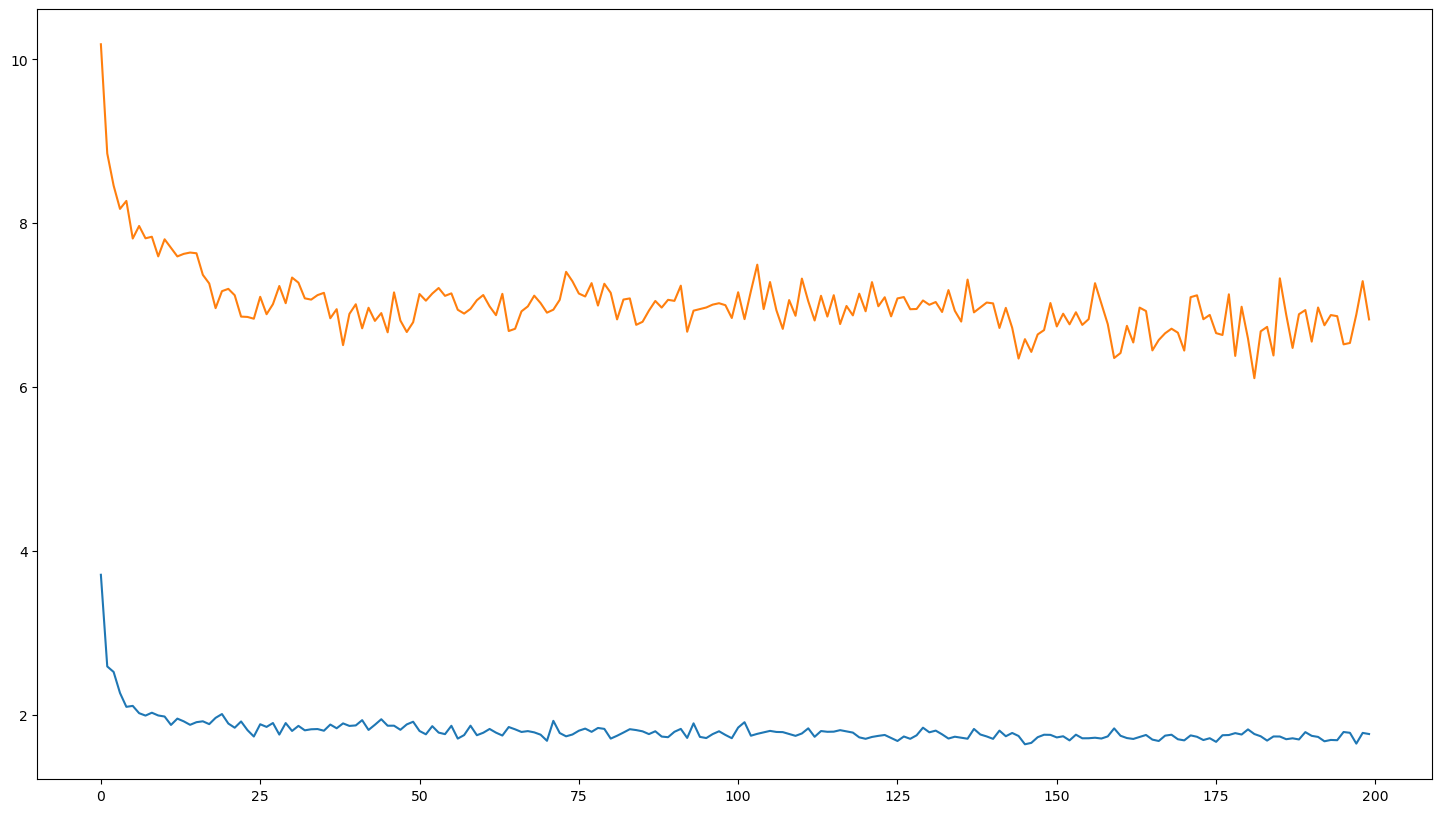

In [58]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_shift_ws_online_MI['Gen_D_KL']))
ax.plot(np.array(Analytic_shift_ws_online_MI['Data_D_KL']))
plt.show()

In [59]:
Analytic_shift_ws_online_MI.to_csv('Analytic_shift_ws_online_MI.csv', index = False)

In [60]:
parameters = {'Phi': Phi, 'Theta': Theta}
np.save('Parameters_shift_ws_online_MI',parameters)

### 3. Train with Perturbation (Shift Patterns)

In [61]:
para = np.load('Parameters_shift_ws_online.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

D:\Program\anaconda3\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [62]:
Analytic_shift_ws_online_perturb = pd.read_csv('Analytic_shift_ws_online.csv', sep=",")
Analytic_shift_ws_online_perturb

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,...,Gen_H_Layer_5,Gen_H_Layer_6,Gen_H_Layer_7,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7
0,0.655633,0.571985,0.558816,0.601158,0.625530,0.634833,0.640671,0.477506,0.679399,0.581523,...,3.714419,2.628021,1.358096,1.088946,0.713392,0.402592,0.337388,0.279556,0.180200,0.101256
1,0.393723,0.411351,0.459724,0.487509,0.530218,0.538705,0.522781,0.271545,0.465700,0.430444,...,3.814557,2.617047,1.295791,3.375550,1.757976,1.465564,0.964380,0.754626,0.517842,0.199070
2,0.382757,0.359798,0.446301,0.450049,0.496051,0.529376,0.468505,0.265308,0.445660,0.395902,...,3.588273,2.402690,1.249453,3.621478,2.162318,1.633370,1.073516,0.734443,0.452110,0.373176
3,0.351038,0.363958,0.438509,0.457817,0.441942,0.540376,0.365396,0.222303,0.437571,0.394547,...,3.500305,2.642266,1.076303,4.059014,2.105663,1.528430,1.129873,0.915961,0.642489,0.296746
4,0.344868,0.346568,0.401235,0.477702,0.400480,0.555822,0.345918,0.234545,0.411906,0.392750,...,3.163184,2.661177,1.002520,4.254811,2.474658,1.676711,1.197370,0.854317,0.599261,0.313349
5,0.338268,0.388712,0.370925,0.443044,0.406164,0.533542,0.450682,0.225307,0.430211,0.419475,...,3.436745,2.568102,1.265192,4.345956,2.188493,1.726964,1.375439,1.044914,0.586289,0.355859
6,0.316292,0.374113,0.371071,0.444821,0.368850,0.543453,0.380353,0.218211,0.392685,0.438181,...,3.112378,2.663256,0.969777,4.455096,2.546635,1.647743,1.325200,1.100924,0.618887,0.290378
7,0.321583,0.362221,0.397129,0.394117,0.380266,0.529545,0.438540,0.214933,0.401921,0.414556,...,3.170792,2.654225,1.031400,4.441648,2.490747,1.747180,1.521348,1.126132,0.594190,0.339259
8,0.307962,0.386547,0.359955,0.417630,0.380542,0.520597,0.396693,0.207846,0.395886,0.427196,...,3.286913,2.632394,1.086438,4.587523,2.445494,1.794885,1.482712,1.074620,0.657527,0.390613
9,0.302032,0.341282,0.352739,0.411689,0.381739,0.530541,0.370813,0.214072,0.387203,0.386165,...,3.118032,2.671695,1.041100,4.372247,2.453001,1.760852,1.491712,1.044269,0.626255,0.379664


In [63]:
batch_size = 1
lr = 0.1
epoch = 1500
gen_batch_size = 100000
n_data

1000

In [64]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    data = Shift_pattern_data(n_data,dev).reshape(16,n_data)
    index = np.random.permutation(n_data)
    for i in range(n_data):
        if i%10 == 0:
            Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,perturb=True)
        else:
            Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,perturb=False)
            
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    if e%10 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        
        gen_data = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
        values_g,counts_g = np.unique(decimalize_np(gen_data),return_counts=True)
        gen_dist = torch.zeros(2**n_d,device=dev)
        gen_dist[values_g]=torch.from_numpy(counts_g).to(dev)/gen_batch_size

        stat.append(KL_divergence(gen_dist,data_dist).item())
        stat.append(KL_divergence(data_dist,gen_dist).item())
        
        k = 0
        for j in range(gen_data.shape[1]):
            if torch.equal(gen_data[:8,j], torch.cat((gen_data[9:,j],gen_data[8:9,j]))) or \
                torch.equal(gen_data[:8,j], torch.cat((gen_data[-1:,j],gen_data[8:-1,j]))):
                k += 1
        stat.append(k/gen_batch_size)
        print(k/gen_batch_size)
        
        H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,100),dev) # batch_size = 100000
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.numpy()) + list(I_wake.numpy()) + list(H_Y_sleep.numpy()) + list(I_sleep.numpy())
        Analytic_shift_ws_online_perturb.loc[len(Analytic_shift_ws_online_perturb)] = stat

Loss_wake: tensor([0.0000, 0.3010, 0.2983, 0.3528, 0.3679, 0.3494, 0.4510, 0.3563])     Loss_sleep: tensor([0.3081, 0.4652, 0.4130, 0.4236, 0.4436, 0.4580, 0.5663, 0.5848])
0.38406
Loss_wake: tensor([0.0000, 0.2867, 0.3365, 0.3808, 0.3994, 0.3715, 0.4664, 0.3583])     Loss_sleep: tensor([0.3641, 0.4598, 0.4243, 0.4394, 0.4499, 0.4599, 0.5550, 0.5951])
Loss_wake: tensor([0.0000, 0.2954, 0.3815, 0.4229, 0.4133, 0.4185, 0.4662, 0.3888])     Loss_sleep: tensor([0.3358, 0.4448, 0.4333, 0.4609, 0.4640, 0.4732, 0.5693, 0.5725])
Loss_wake: tensor([0.0000, 0.3256, 0.4245, 0.4463, 0.4498, 0.4607, 0.5102, 0.4026])     Loss_sleep: tensor([0.2935, 0.4410, 0.4828, 0.4694, 0.4944, 0.5070, 0.5681, 0.5963])
Loss_wake: tensor([0.0000, 0.3425, 0.4595, 0.4776, 0.4916, 0.4756, 0.5320, 0.3578])     Loss_sleep: tensor([0.2788, 0.4421, 0.4970, 0.4999, 0.5274, 0.5153, 0.5900, 0.5641])
Loss_wake: tensor([0.0000, 0.3570, 0.4834, 0.5110, 0.5116, 0.5286, 0.5355, 0.4280])     Loss_sleep: tensor([0.2876, 0.4517, 0.5

Loss_wake: tensor([0.0000, 0.5146, 0.5093, 0.5507, 0.5902, 0.6295, 0.6271, 0.6763])     Loss_sleep: tensor([0.3418, 0.6016, 0.5579, 0.5766, 0.6311, 0.6206, 0.6803, 0.6892])
Loss_wake: tensor([0.0000, 0.5332, 0.5259, 0.5473, 0.5796, 0.6066, 0.6360, 0.6829])     Loss_sleep: tensor([0.3319, 0.6134, 0.5555, 0.5725, 0.6174, 0.6187, 0.6816, 0.6904])
Loss_wake: tensor([0.0000, 0.5181, 0.5337, 0.5406, 0.5468, 0.6347, 0.6452, 0.6432])     Loss_sleep: tensor([0.3472, 0.6159, 0.5758, 0.5498, 0.5980, 0.6390, 0.6630, 0.6539])
0.17184
Loss_wake: tensor([0.0000, 0.5351, 0.5182, 0.4950, 0.5557, 0.5989, 0.5896, 0.5690])     Loss_sleep: tensor([0.3452, 0.6180, 0.5574, 0.5143, 0.5980, 0.6050, 0.6059, 0.5902])
Loss_wake: tensor([0.0000, 0.5227, 0.5356, 0.5399, 0.5722, 0.6036, 0.6113, 0.5876])     Loss_sleep: tensor([0.3260, 0.6039, 0.5844, 0.5650, 0.6134, 0.6082, 0.6392, 0.6340])
Loss_wake: tensor([0.0000, 0.5142, 0.5560, 0.5610, 0.5649, 0.5939, 0.6283, 0.6180])     Loss_sleep: tensor([0.3432, 0.5999, 0.5

Loss_wake: tensor([0.0000, 0.5203, 0.5565, 0.5503, 0.6012, 0.5863, 0.6246, 0.6197])     Loss_sleep: tensor([0.3424, 0.5946, 0.5969, 0.5721, 0.6216, 0.6293, 0.6380, 0.6641])
Loss_wake: tensor([0.0000, 0.5018, 0.5504, 0.5646, 0.5796, 0.6042, 0.5919, 0.5756])     Loss_sleep: tensor([0.3439, 0.5857, 0.5826, 0.5896, 0.6030, 0.6369, 0.6087, 0.6423])
Loss_wake: tensor([0.0000, 0.5078, 0.5549, 0.5475, 0.5639, 0.6027, 0.6285, 0.6269])     Loss_sleep: tensor([0.3421, 0.5835, 0.5958, 0.5937, 0.5735, 0.6436, 0.6528, 0.6723])
Loss_wake: tensor([0.0000, 0.5115, 0.5547, 0.5232, 0.5983, 0.5964, 0.6292, 0.6103])     Loss_sleep: tensor([0.3350, 0.5880, 0.5924, 0.5805, 0.5990, 0.6170, 0.6645, 0.6484])
Loss_wake: tensor([0.0000, 0.5145, 0.5056, 0.5623, 0.5737, 0.5910, 0.6096, 0.5951])     Loss_sleep: tensor([0.3433, 0.6010, 0.5390, 0.5977, 0.6005, 0.5889, 0.6517, 0.6485])
0.18408
Loss_wake: tensor([0.0000, 0.5099, 0.5518, 0.5311, 0.5902, 0.6009, 0.5704, 0.6101])     Loss_sleep: tensor([0.3364, 0.5853, 0.5

Loss_wake: tensor([0.0000, 0.5343, 0.5157, 0.5196, 0.5208, 0.5561, 0.5712, 0.5555])     Loss_sleep: tensor([0.3464, 0.6178, 0.5674, 0.5219, 0.5668, 0.5693, 0.6150, 0.5956])
Loss_wake: tensor([0.0000, 0.5220, 0.5426, 0.5794, 0.5577, 0.5960, 0.6222, 0.6391])     Loss_sleep: tensor([0.3583, 0.5851, 0.5778, 0.5896, 0.5849, 0.6265, 0.6567, 0.6918])
Loss_wake: tensor([0.0000, 0.5240, 0.5445, 0.5801, 0.6092, 0.6070, 0.6049, 0.6326])     Loss_sleep: tensor([0.3494, 0.6019, 0.5755, 0.6011, 0.6187, 0.6451, 0.6379, 0.6898])
Loss_wake: tensor([0.0000, 0.5207, 0.5372, 0.5395, 0.5817, 0.6133, 0.6275, 0.6274])     Loss_sleep: tensor([0.3393, 0.6032, 0.5703, 0.5684, 0.6009, 0.6322, 0.6592, 0.6671])
Loss_wake: tensor([0.0000, 0.5322, 0.5516, 0.5459, 0.6067, 0.5781, 0.6253, 0.6064])     Loss_sleep: tensor([0.3383, 0.5954, 0.5931, 0.5713, 0.6231, 0.6135, 0.6565, 0.6365])
Loss_wake: tensor([0.0000, 0.5179, 0.5514, 0.5436, 0.5765, 0.5882, 0.6287, 0.6031])     Loss_sleep: tensor([0.3483, 0.5849, 0.5936, 0.5

Loss_wake: tensor([0.0000, 0.5064, 0.5258, 0.5314, 0.5521, 0.5844, 0.6042, 0.6434])     Loss_sleep: tensor([0.3384, 0.5953, 0.5517, 0.5643, 0.5666, 0.6039, 0.6467, 0.6889])
Loss_wake: tensor([0.0000, 0.5291, 0.5374, 0.5524, 0.6027, 0.5786, 0.6318, 0.6228])     Loss_sleep: tensor([0.3455, 0.5989, 0.5694, 0.5943, 0.6144, 0.6090, 0.6441, 0.6703])
Loss_wake: tensor([0.0000, 0.5213, 0.5247, 0.5557, 0.5969, 0.6034, 0.6463, 0.5580])     Loss_sleep: tensor([0.3533, 0.5962, 0.5698, 0.5921, 0.6132, 0.6283, 0.6561, 0.6326])
Loss_wake: tensor([0.0000, 0.5311, 0.5355, 0.5404, 0.5895, 0.6192, 0.6416, 0.5710])     Loss_sleep: tensor([0.3382, 0.6087, 0.5719, 0.5778, 0.6124, 0.6382, 0.6424, 0.6359])
Loss_wake: tensor([0.0000, 0.5239, 0.5396, 0.5624, 0.6016, 0.5991, 0.6428, 0.5854])     Loss_sleep: tensor([0.3581, 0.5952, 0.5644, 0.6003, 0.6202, 0.6407, 0.6502, 0.6370])
Loss_wake: tensor([0.0000, 0.5148, 0.5624, 0.5573, 0.6009, 0.5854, 0.6435, 0.5994])     Loss_sleep: tensor([0.3455, 0.5990, 0.5929, 0.5

Loss_wake: tensor([0.0000, 0.5078, 0.5532, 0.5458, 0.5539, 0.5805, 0.6320, 0.5664])     Loss_sleep: tensor([0.3437, 0.5985, 0.5771, 0.5695, 0.5735, 0.6098, 0.6506, 0.6232])
0.18228
Loss_wake: tensor([0.0000, 0.5134, 0.5108, 0.5125, 0.5960, 0.5836, 0.6210, 0.6366])     Loss_sleep: tensor([0.3441, 0.6075, 0.5460, 0.5463, 0.6086, 0.5860, 0.6618, 0.6623])
Loss_wake: tensor([0.0000, 0.5201, 0.5334, 0.5801, 0.5990, 0.5739, 0.6382, 0.6335])     Loss_sleep: tensor([0.3524, 0.6060, 0.5557, 0.6182, 0.6048, 0.6079, 0.6674, 0.6849])
Loss_wake: tensor([0.0000, 0.5218, 0.5168, 0.5686, 0.5962, 0.6134, 0.5979, 0.6020])     Loss_sleep: tensor([0.3461, 0.6025, 0.5486, 0.6007, 0.6226, 0.6020, 0.6423, 0.6374])
Loss_wake: tensor([0.0000, 0.5227, 0.5491, 0.5415, 0.5510, 0.5490, 0.5914, 0.6152])     Loss_sleep: tensor([0.3582, 0.5949, 0.5986, 0.5688, 0.5890, 0.5522, 0.6466, 0.6547])
Loss_wake: tensor([0.0000, 0.5215, 0.5478, 0.5517, 0.5415, 0.6310, 0.6297, 0.6281])     Loss_sleep: tensor([0.3659, 0.5907, 0.5

Loss_wake: tensor([0.0000, 0.5324, 0.5371, 0.5275, 0.5860, 0.6266, 0.6502, 0.5873])     Loss_sleep: tensor([0.3509, 0.6131, 0.5649, 0.5574, 0.6164, 0.6518, 0.6715, 0.6237])
Loss_wake: tensor([0.0000, 0.5344, 0.5314, 0.5651, 0.5610, 0.6020, 0.5820, 0.5871])     Loss_sleep: tensor([0.3497, 0.6022, 0.5678, 0.5903, 0.6117, 0.6174, 0.5967, 0.6478])
Loss_wake: tensor([0.0000, 0.5286, 0.5509, 0.5134, 0.5299, 0.5026, 0.4956, 0.4645])     Loss_sleep: tensor([0.3358, 0.6065, 0.5787, 0.5475, 0.5715, 0.5214, 0.4988, 0.5427])
0.16284
Loss_wake: tensor([0.0000, 0.5199, 0.5342, 0.5527, 0.5890, 0.5800, 0.5816, 0.5976])     Loss_sleep: tensor([0.3356, 0.6021, 0.5886, 0.5825, 0.6146, 0.6027, 0.5925, 0.6713])
Loss_wake: tensor([0.0000, 0.5239, 0.5240, 0.5615, 0.5603, 0.5551, 0.5762, 0.5594])     Loss_sleep: tensor([0.3319, 0.5932, 0.5750, 0.5973, 0.5888, 0.5612, 0.5829, 0.6267])
Loss_wake: tensor([0.0000, 0.5252, 0.5366, 0.5167, 0.5650, 0.5530, 0.5578, 0.5881])     Loss_sleep: tensor([0.3439, 0.5971, 0.5

Loss_wake: tensor([0.0000, 0.5216, 0.5417, 0.5890, 0.5577, 0.5615, 0.6193, 0.6417])     Loss_sleep: tensor([0.3647, 0.6009, 0.5808, 0.6067, 0.5673, 0.5973, 0.6590, 0.6645])
Loss_wake: tensor([0.0000, 0.5329, 0.5461, 0.5666, 0.5804, 0.5546, 0.6076, 0.6216])     Loss_sleep: tensor([0.3527, 0.5995, 0.5872, 0.5922, 0.5766, 0.5948, 0.6506, 0.6718])
Loss_wake: tensor([0.0000, 0.5283, 0.5376, 0.5525, 0.5330, 0.5794, 0.6022, 0.6005])     Loss_sleep: tensor([0.3420, 0.6086, 0.5769, 0.5907, 0.5454, 0.6081, 0.6273, 0.6330])
Loss_wake: tensor([0.0000, 0.5202, 0.5437, 0.5735, 0.5931, 0.5986, 0.6313, 0.6214])     Loss_sleep: tensor([0.3519, 0.5934, 0.5817, 0.5965, 0.6024, 0.6344, 0.6586, 0.6511])
Loss_wake: tensor([0.0000, 0.4987, 0.5719, 0.5645, 0.5918, 0.5973, 0.6500, 0.6620])     Loss_sleep: tensor([0.3218, 0.5787, 0.5956, 0.5966, 0.6005, 0.6397, 0.6717, 0.6929])
0.22211
Loss_wake: tensor([0.0000, 0.4938, 0.5628, 0.5051, 0.5522, 0.5819, 0.6367, 0.6222])     Loss_sleep: tensor([0.3446, 0.5688, 0.6

Loss_wake: tensor([0.0000, 0.5127, 0.5304, 0.5479, 0.4893, 0.5981, 0.5759, 0.5473])     Loss_sleep: tensor([0.3370, 0.5948, 0.5728, 0.5823, 0.5350, 0.6172, 0.5986, 0.5759])
Loss_wake: tensor([0.0000, 0.5118, 0.5232, 0.5252, 0.5079, 0.5698, 0.5488, 0.5280])     Loss_sleep: tensor([0.3414, 0.5830, 0.5812, 0.5524, 0.5399, 0.5905, 0.5946, 0.5903])
Loss_wake: tensor([0.0000, 0.5170, 0.5272, 0.5541, 0.5272, 0.6007, 0.6069, 0.6212])     Loss_sleep: tensor([0.3386, 0.5911, 0.5550, 0.5787, 0.5704, 0.6100, 0.6382, 0.6462])
Loss_wake: tensor([0.0000, 0.5150, 0.5528, 0.5441, 0.5291, 0.5845, 0.6411, 0.6187])     Loss_sleep: tensor([0.3302, 0.6042, 0.5760, 0.5824, 0.5565, 0.6138, 0.6662, 0.6525])
Loss_wake: tensor([0.0000, 0.5160, 0.5120, 0.5496, 0.5805, 0.5968, 0.6518, 0.6232])     Loss_sleep: tensor([0.3315, 0.5997, 0.5602, 0.5926, 0.6031, 0.6272, 0.6702, 0.6553])
Loss_wake: tensor([0.0000, 0.5133, 0.5212, 0.5311, 0.5954, 0.5963, 0.5965, 0.6351])     Loss_sleep: tensor([0.3399, 0.6060, 0.5440, 0.5

Loss_wake: tensor([0.0000, 0.5105, 0.5513, 0.5529, 0.5769, 0.5751, 0.6039, 0.5763])     Loss_sleep: tensor([0.3472, 0.5886, 0.6046, 0.5600, 0.6191, 0.5801, 0.6523, 0.6373])
Loss_wake: tensor([0.0000, 0.5164, 0.5412, 0.5684, 0.5643, 0.6080, 0.5740, 0.6272])     Loss_sleep: tensor([0.3301, 0.5869, 0.5800, 0.5929, 0.6112, 0.6100, 0.6356, 0.6780])
Loss_wake: tensor([0.0000, 0.5125, 0.5155, 0.5723, 0.5919, 0.5783, 0.6202, 0.6735])     Loss_sleep: tensor([0.3363, 0.5957, 0.5526, 0.5926, 0.6212, 0.6066, 0.6662, 0.6934])
Loss_wake: tensor([0.0000, 0.4862, 0.5281, 0.5766, 0.6063, 0.5852, 0.6414, 0.6299])     Loss_sleep: tensor([0.3319, 0.5667, 0.5644, 0.6070, 0.6116, 0.6268, 0.6687, 0.6700])
Loss_wake: tensor([0.0000, 0.4847, 0.5181, 0.5431, 0.5865, 0.6215, 0.6438, 0.5946])     Loss_sleep: tensor([0.3388, 0.5565, 0.5732, 0.5686, 0.5948, 0.6491, 0.6544, 0.6649])
Loss_wake: tensor([0.0000, 0.5080, 0.5268, 0.5508, 0.5639, 0.6139, 0.6058, 0.5817])     Loss_sleep: tensor([0.3370, 0.5802, 0.5807, 0.5

Loss_wake: tensor([0.0000, 0.5172, 0.5316, 0.5396, 0.5497, 0.6419, 0.6640, 0.6239])     Loss_sleep: tensor([0.3450, 0.5911, 0.5781, 0.5879, 0.5843, 0.6551, 0.6775, 0.6459])
0.19561
Loss_wake: tensor([0.0000, 0.5219, 0.5347, 0.5747, 0.5700, 0.6276, 0.6458, 0.6556])     Loss_sleep: tensor([0.3414, 0.5969, 0.5613, 0.6160, 0.6185, 0.6364, 0.6676, 0.6755])
Loss_wake: tensor([0.0000, 0.5063, 0.5635, 0.5278, 0.5663, 0.6217, 0.6098, 0.6062])     Loss_sleep: tensor([0.3481, 0.5910, 0.5765, 0.5802, 0.6178, 0.6245, 0.6581, 0.6305])
Loss_wake: tensor([0.0000, 0.5151, 0.5517, 0.5261, 0.5461, 0.5924, 0.6153, 0.5865])     Loss_sleep: tensor([0.3362, 0.5950, 0.5696, 0.5771, 0.5771, 0.6069, 0.6498, 0.6154])
Loss_wake: tensor([0.0000, 0.5295, 0.5440, 0.5555, 0.5859, 0.5859, 0.6103, 0.5116])     Loss_sleep: tensor([0.3350, 0.6168, 0.5627, 0.5935, 0.6140, 0.6241, 0.6290, 0.5355])
Loss_wake: tensor([0.0000, 0.5185, 0.5249, 0.5494, 0.5533, 0.5773, 0.5397, 0.4794])     Loss_sleep: tensor([0.3498, 0.5924, 0.5

Loss_wake: tensor([0.0000, 0.5304, 0.4909, 0.5691, 0.5652, 0.5833, 0.6529, 0.5087])     Loss_sleep: tensor([0.3303, 0.5974, 0.5398, 0.5892, 0.5773, 0.6259, 0.6518, 0.5795])
Loss_wake: tensor([0.0000, 0.5286, 0.5157, 0.5717, 0.5707, 0.6045, 0.6298, 0.6203])     Loss_sleep: tensor([0.3396, 0.6093, 0.5576, 0.5772, 0.6163, 0.6212, 0.6520, 0.6612])
Loss_wake: tensor([0.0000, 0.5274, 0.5213, 0.5611, 0.5970, 0.6209, 0.6569, 0.6274])     Loss_sleep: tensor([0.3335, 0.6132, 0.5609, 0.5792, 0.6090, 0.6600, 0.6637, 0.6669])
0.17056
Loss_wake: tensor([0.0000, 0.5132, 0.5172, 0.6022, 0.5823, 0.6093, 0.6564, 0.6320])     Loss_sleep: tensor([0.3387, 0.6012, 0.5762, 0.6139, 0.5822, 0.6584, 0.6746, 0.6573])
Loss_wake: tensor([0.0000, 0.5205, 0.5289, 0.5919, 0.5683, 0.5918, 0.6429, 0.6082])     Loss_sleep: tensor([0.3376, 0.5989, 0.5887, 0.5967, 0.5877, 0.6027, 0.6685, 0.6365])
Loss_wake: tensor([0.0000, 0.5280, 0.5391, 0.5790, 0.6032, 0.5891, 0.6353, 0.5751])     Loss_sleep: tensor([0.3325, 0.5925, 0.5

Loss_wake: tensor([0.0000, 0.5173, 0.5203, 0.5303, 0.5682, 0.5776, 0.6095, 0.6207])     Loss_sleep: tensor([0.3353, 0.5920, 0.5644, 0.5641, 0.5843, 0.5933, 0.6603, 0.6792])
Loss_wake: tensor([0.0000, 0.5137, 0.5169, 0.5676, 0.5794, 0.5485, 0.6319, 0.6266])     Loss_sleep: tensor([0.3332, 0.5792, 0.5720, 0.5984, 0.5989, 0.5797, 0.6606, 0.6866])
Loss_wake: tensor([0.0000, 0.5210, 0.5315, 0.5629, 0.5947, 0.5814, 0.6416, 0.6492])     Loss_sleep: tensor([0.3484, 0.5865, 0.5877, 0.5924, 0.6026, 0.6047, 0.6694, 0.6885])
Loss_wake: tensor([0.0000, 0.5258, 0.5295, 0.5596, 0.6002, 0.5438, 0.6324, 0.6063])     Loss_sleep: tensor([0.3455, 0.5999, 0.5793, 0.5820, 0.6044, 0.5695, 0.6731, 0.6520])
Loss_wake: tensor([0.0000, 0.5235, 0.5553, 0.5455, 0.5783, 0.5982, 0.6372, 0.6443])     Loss_sleep: tensor([0.3373, 0.6028, 0.5920, 0.5972, 0.5796, 0.6137, 0.6858, 0.6643])
0.18787
Loss_wake: tensor([0.0000, 0.5046, 0.5620, 0.5318, 0.6192, 0.5713, 0.6402, 0.6210])     Loss_sleep: tensor([0.3318, 0.5907, 0.6

Loss_wake: tensor([0.0000, 0.5014, 0.5389, 0.5292, 0.5611, 0.5260, 0.6126, 0.6730])     Loss_sleep: tensor([0.3345, 0.5999, 0.5852, 0.5536, 0.5711, 0.5410, 0.6779, 0.6888])
Loss_wake: tensor([0.0000, 0.5126, 0.5134, 0.5728, 0.5456, 0.5865, 0.6290, 0.6585])     Loss_sleep: tensor([0.3330, 0.6073, 0.5503, 0.5823, 0.5742, 0.5962, 0.6761, 0.6818])
Loss_wake: tensor([0.0000, 0.5269, 0.4959, 0.5808, 0.5423, 0.6027, 0.6406, 0.6631])     Loss_sleep: tensor([0.3471, 0.6012, 0.5387, 0.6108, 0.5697, 0.6193, 0.6798, 0.6796])
Loss_wake: tensor([0.0000, 0.5042, 0.5342, 0.5707, 0.6007, 0.5982, 0.6286, 0.6546])     Loss_sleep: tensor([0.3437, 0.5908, 0.5626, 0.6102, 0.6091, 0.6222, 0.6672, 0.6952])
Loss_wake: tensor([0.0000, 0.5161, 0.5398, 0.5906, 0.5832, 0.5795, 0.6334, 0.6508])     Loss_sleep: tensor([0.3301, 0.5800, 0.5935, 0.6230, 0.5945, 0.6047, 0.6739, 0.6806])
Loss_wake: tensor([0.0000, 0.5175, 0.5359, 0.5856, 0.6070, 0.5890, 0.6356, 0.5380])     Loss_sleep: tensor([0.3375, 0.5847, 0.5936, 0.6

Loss_wake: tensor([0.0000, 0.5358, 0.5520, 0.5746, 0.5933, 0.6155, 0.6031, 0.6018])     Loss_sleep: tensor([0.3458, 0.6152, 0.5808, 0.5945, 0.6204, 0.6015, 0.6563, 0.6435])
Loss_wake: tensor([0.0000, 0.5298, 0.5466, 0.5665, 0.5789, 0.6391, 0.5947, 0.5906])     Loss_sleep: tensor([0.3363, 0.6206, 0.5728, 0.5935, 0.6116, 0.6352, 0.6276, 0.6475])
Loss_wake: tensor([0.0000, 0.5144, 0.5437, 0.5726, 0.5616, 0.6332, 0.5984, 0.6085])     Loss_sleep: tensor([0.3402, 0.5834, 0.5878, 0.6171, 0.5764, 0.6409, 0.6451, 0.6565])
Loss_wake: tensor([0.0000, 0.5184, 0.5175, 0.5837, 0.5711, 0.5993, 0.6021, 0.6748])     Loss_sleep: tensor([0.3341, 0.5971, 0.5557, 0.6073, 0.6021, 0.6023, 0.6727, 0.6971])
Loss_wake: tensor([0.0000, 0.5105, 0.5223, 0.5771, 0.5674, 0.5949, 0.6033, 0.6470])     Loss_sleep: tensor([0.3310, 0.5775, 0.5679, 0.5897, 0.6027, 0.6034, 0.6567, 0.6846])
Loss_wake: tensor([0.0000, 0.5238, 0.5393, 0.4880, 0.6041, 0.6060, 0.6143, 0.5963])     Loss_sleep: tensor([0.3300, 0.5985, 0.5925, 0.5

Loss_wake: tensor([0.0000, 0.5110, 0.5406, 0.5202, 0.5498, 0.5331, 0.6189, 0.5860])     Loss_sleep: tensor([0.3391, 0.5883, 0.5694, 0.5605, 0.5858, 0.5672, 0.6228, 0.6373])
0.18629
Loss_wake: tensor([0.0000, 0.5078, 0.5452, 0.5299, 0.5536, 0.5461, 0.6239, 0.5808])     Loss_sleep: tensor([0.3398, 0.5996, 0.5632, 0.5759, 0.5832, 0.5859, 0.6500, 0.6107])
Loss_wake: tensor([0.0000, 0.5109, 0.5475, 0.5051, 0.5622, 0.5747, 0.6143, 0.5332])     Loss_sleep: tensor([0.3448, 0.6048, 0.5754, 0.5326, 0.5999, 0.6079, 0.6252, 0.5618])
Loss_wake: tensor([0.0000, 0.5131, 0.5538, 0.5541, 0.5618, 0.5565, 0.5947, 0.5414])     Loss_sleep: tensor([0.3331, 0.6042, 0.5818, 0.5762, 0.6010, 0.5964, 0.6124, 0.5950])
Loss_wake: tensor([0.0000, 0.5263, 0.5422, 0.5482, 0.5520, 0.5530, 0.6217, 0.5962])     Loss_sleep: tensor([0.3367, 0.6000, 0.5737, 0.5843, 0.5857, 0.5930, 0.6532, 0.6236])
Loss_wake: tensor([0.0000, 0.5147, 0.5359, 0.5372, 0.5355, 0.5684, 0.5852, 0.5387])     Loss_sleep: tensor([0.3391, 0.5971, 0.5

Loss_wake: tensor([0.0000, 0.5226, 0.5072, 0.5841, 0.5888, 0.6191, 0.6068, 0.6276])     Loss_sleep: tensor([0.3469, 0.6070, 0.5460, 0.6044, 0.6105, 0.6145, 0.6687, 0.6698])
Loss_wake: tensor([0.0000, 0.5328, 0.5642, 0.5567, 0.5828, 0.5831, 0.6073, 0.4774])     Loss_sleep: tensor([0.3468, 0.6276, 0.5866, 0.5850, 0.5951, 0.5873, 0.6317, 0.5646])
Loss_wake: tensor([0.0000, 0.5121, 0.5601, 0.5319, 0.5199, 0.6002, 0.6288, 0.4836])     Loss_sleep: tensor([0.3294, 0.6126, 0.5830, 0.5351, 0.5452, 0.6386, 0.6122, 0.5840])
0.23998
Loss_wake: tensor([0.0000, 0.5198, 0.5627, 0.5708, 0.4975, 0.6001, 0.5842, 0.5348])     Loss_sleep: tensor([0.3516, 0.6102, 0.5874, 0.5920, 0.5405, 0.6194, 0.5975, 0.6189])
Loss_wake: tensor([0.0000, 0.5134, 0.5354, 0.5567, 0.5770, 0.6293, 0.6182, 0.6143])     Loss_sleep: tensor([0.3348, 0.6015, 0.5807, 0.5838, 0.5970, 0.6396, 0.6520, 0.6639])
Loss_wake: tensor([0.0000, 0.5195, 0.5308, 0.5601, 0.6225, 0.6251, 0.6244, 0.5950])     Loss_sleep: tensor([0.3381, 0.6054, 0.5

Loss_wake: tensor([0.0000, 0.5290, 0.5408, 0.5719, 0.5857, 0.6280, 0.6487, 0.6101])     Loss_sleep: tensor([0.3360, 0.5927, 0.5862, 0.6104, 0.6122, 0.6520, 0.6393, 0.6842])
Loss_wake: tensor([0.0000, 0.5201, 0.5301, 0.5753, 0.6081, 0.6191, 0.6522, 0.5568])     Loss_sleep: tensor([0.3316, 0.5915, 0.5671, 0.6046, 0.6121, 0.6549, 0.6447, 0.6297])
Loss_wake: tensor([0.0000, 0.5266, 0.5466, 0.5537, 0.5779, 0.6002, 0.6106, 0.5509])     Loss_sleep: tensor([0.3390, 0.5895, 0.5888, 0.6031, 0.5749, 0.6316, 0.6239, 0.6357])
Loss_wake: tensor([0.0000, 0.5187, 0.5479, 0.5734, 0.6099, 0.6117, 0.6506, 0.5542])     Loss_sleep: tensor([0.3537, 0.5830, 0.5907, 0.6113, 0.6434, 0.6441, 0.6613, 0.6016])
Loss_wake: tensor([0.0000, 0.5297, 0.5185, 0.5731, 0.5792, 0.6126, 0.6398, 0.5817])     Loss_sleep: tensor([0.3448, 0.5905, 0.5664, 0.6108, 0.6094, 0.6172, 0.6477, 0.6457])
0.20862
Loss_wake: tensor([0.0000, 0.5208, 0.5178, 0.5836, 0.5578, 0.6035, 0.5986, 0.6280])     Loss_sleep: tensor([0.3568, 0.5791, 0.5

Loss_wake: tensor([0.0000, 0.5066, 0.5403, 0.5289, 0.5762, 0.5804, 0.6129, 0.6162])     Loss_sleep: tensor([0.3386, 0.5997, 0.5806, 0.5515, 0.5885, 0.6021, 0.6404, 0.6657])
Loss_wake: tensor([0.0000, 0.5204, 0.5288, 0.4985, 0.5584, 0.5815, 0.5819, 0.6032])     Loss_sleep: tensor([0.3400, 0.6161, 0.5689, 0.5148, 0.5662, 0.6031, 0.6117, 0.6786])
Loss_wake: tensor([0.0000, 0.5289, 0.5352, 0.5358, 0.5582, 0.6113, 0.5967, 0.5579])     Loss_sleep: tensor([0.3456, 0.6060, 0.5649, 0.5715, 0.5785, 0.6382, 0.6162, 0.6546])
Loss_wake: tensor([0.0000, 0.5255, 0.5445, 0.5805, 0.6057, 0.6055, 0.6024, 0.6074])     Loss_sleep: tensor([0.3379, 0.6031, 0.5770, 0.6028, 0.6176, 0.6336, 0.6352, 0.6607])
Loss_wake: tensor([0.0000, 0.4981, 0.5507, 0.5555, 0.5757, 0.5791, 0.5924, 0.5779])     Loss_sleep: tensor([0.3290, 0.5894, 0.5959, 0.5853, 0.6028, 0.5961, 0.6035, 0.6340])
Loss_wake: tensor([0.0000, 0.5025, 0.5312, 0.5124, 0.5251, 0.5680, 0.6078, 0.5937])     Loss_sleep: tensor([0.3406, 0.6061, 0.5761, 0.5

Loss_wake: tensor([0.0000, 0.5154, 0.5301, 0.5485, 0.5820, 0.5926, 0.6318, 0.6622])     Loss_sleep: tensor([0.3410, 0.5888, 0.5802, 0.5796, 0.5884, 0.6279, 0.6612, 0.6820])
Loss_wake: tensor([0.0000, 0.5119, 0.5566, 0.5455, 0.5962, 0.6107, 0.6279, 0.6592])     Loss_sleep: tensor([0.3414, 0.6059, 0.6030, 0.5713, 0.6047, 0.6199, 0.6678, 0.6715])
Loss_wake: tensor([0.0000, 0.5318, 0.5198, 0.5589, 0.5931, 0.6239, 0.6407, 0.6319])     Loss_sleep: tensor([0.3347, 0.5994, 0.5743, 0.5860, 0.6145, 0.6313, 0.6741, 0.6545])
Loss_wake: tensor([0.0000, 0.5205, 0.5295, 0.5641, 0.5879, 0.5977, 0.6097, 0.6364])     Loss_sleep: tensor([0.3441, 0.5933, 0.5813, 0.5905, 0.6048, 0.6005, 0.6334, 0.6780])
Loss_wake: tensor([0.0000, 0.5104, 0.5524, 0.5498, 0.5611, 0.6051, 0.6208, 0.5456])     Loss_sleep: tensor([0.3445, 0.5875, 0.5971, 0.5767, 0.5999, 0.6113, 0.6591, 0.5889])
Loss_wake: tensor([0.0000, 0.5181, 0.5274, 0.5733, 0.5507, 0.5913, 0.6340, 0.6168])     Loss_sleep: tensor([0.3410, 0.5977, 0.5818, 0.5

Loss_wake: tensor([0.0000, 0.5032, 0.5451, 0.5508, 0.5571, 0.5763, 0.5805, 0.5995])     Loss_sleep: tensor([0.3228, 0.5852, 0.5812, 0.5849, 0.5761, 0.5761, 0.6117, 0.6712])
0.21491
Loss_wake: tensor([0.0000, 0.5122, 0.5362, 0.5533, 0.5542, 0.5924, 0.5675, 0.6167])     Loss_sleep: tensor([0.3351, 0.5987, 0.5905, 0.5760, 0.5744, 0.5916, 0.6225, 0.6595])
Loss_wake: tensor([0.0000, 0.5264, 0.5081, 0.5813, 0.5675, 0.6121, 0.6204, 0.5382])     Loss_sleep: tensor([0.3415, 0.5888, 0.5535, 0.6022, 0.5929, 0.6258, 0.6484, 0.5955])
Loss_wake: tensor([0.0000, 0.5059, 0.5699, 0.5322, 0.5820, 0.6253, 0.6294, 0.5916])     Loss_sleep: tensor([0.3454, 0.5980, 0.6036, 0.5457, 0.6166, 0.6413, 0.6511, 0.6237])
Loss_wake: tensor([0.0000, 0.5126, 0.5596, 0.5784, 0.5888, 0.6083, 0.6514, 0.6155])     Loss_sleep: tensor([0.3484, 0.5889, 0.6055, 0.5822, 0.6133, 0.6397, 0.6699, 0.6549])
Loss_wake: tensor([0.0000, 0.5121, 0.5620, 0.5855, 0.5243, 0.6111, 0.6566, 0.6352])     Loss_sleep: tensor([0.3433, 0.6074, 0.5

Loss_wake: tensor([0.0000, 0.5173, 0.5062, 0.5889, 0.5863, 0.6018, 0.6469, 0.5834])     Loss_sleep: tensor([0.3464, 0.5978, 0.5378, 0.5968, 0.6062, 0.6625, 0.6552, 0.6371])
Loss_wake: tensor([0.0000, 0.5237, 0.5376, 0.5489, 0.5805, 0.5952, 0.6431, 0.5456])     Loss_sleep: tensor([0.3538, 0.6009, 0.5920, 0.5655, 0.5948, 0.6281, 0.6513, 0.6031])
Loss_wake: tensor([0.0000, 0.5057, 0.5498, 0.5623, 0.5741, 0.5962, 0.6157, 0.6467])     Loss_sleep: tensor([0.3472, 0.5931, 0.5955, 0.5730, 0.5946, 0.6217, 0.6557, 0.6785])
0.15808
Loss_wake: tensor([0.0000, 0.5247, 0.5288, 0.5639, 0.5866, 0.6004, 0.6102, 0.6484])     Loss_sleep: tensor([0.3546, 0.6013, 0.5658, 0.5951, 0.6040, 0.6167, 0.6698, 0.6708])
Loss_wake: tensor([0.0000, 0.5198, 0.5125, 0.5526, 0.5884, 0.6141, 0.6019, 0.6074])     Loss_sleep: tensor([0.3515, 0.5941, 0.5514, 0.5834, 0.6107, 0.6247, 0.6407, 0.6620])
Loss_wake: tensor([0.0000, 0.5071, 0.5360, 0.5542, 0.6160, 0.6288, 0.6472, 0.5366])     Loss_sleep: tensor([0.3466, 0.5895, 0.5

Loss_wake: tensor([0.0000, 0.5269, 0.5407, 0.5575, 0.5889, 0.6114, 0.6263, 0.6499])     Loss_sleep: tensor([0.3459, 0.6216, 0.5718, 0.5871, 0.5925, 0.6496, 0.6448, 0.6858])
Loss_wake: tensor([0.0000, 0.5066, 0.5605, 0.5727, 0.5546, 0.6139, 0.6100, 0.6133])     Loss_sleep: tensor([0.3292, 0.6030, 0.5869, 0.6071, 0.5696, 0.6337, 0.6205, 0.6748])
Loss_wake: tensor([0.0000, 0.5149, 0.5429, 0.5913, 0.5896, 0.5610, 0.5949, 0.6285])     Loss_sleep: tensor([0.3293, 0.5869, 0.5901, 0.6085, 0.6158, 0.5847, 0.6278, 0.6830])
Loss_wake: tensor([0.0000, 0.5192, 0.5266, 0.5645, 0.5635, 0.5407, 0.5918, 0.6266])     Loss_sleep: tensor([0.3370, 0.5994, 0.5862, 0.5777, 0.5868, 0.5472, 0.6367, 0.6681])
Loss_wake: tensor([0.0000, 0.5102, 0.5185, 0.5724, 0.5573, 0.5908, 0.5763, 0.5960])     Loss_sleep: tensor([0.3410, 0.6007, 0.5700, 0.5896, 0.5828, 0.6084, 0.6246, 0.6600])
0.19665
Loss_wake: tensor([0.0000, 0.5191, 0.5067, 0.5895, 0.5985, 0.6113, 0.6236, 0.5904])     Loss_sleep: tensor([0.3422, 0.5885, 0.5

Loss_wake: tensor([0.0000, 0.5349, 0.5352, 0.5572, 0.5364, 0.6179, 0.6406, 0.6241])     Loss_sleep: tensor([0.3576, 0.6074, 0.5597, 0.5989, 0.5702, 0.6513, 0.6469, 0.6798])
Loss_wake: tensor([0.0000, 0.5172, 0.5471, 0.5249, 0.5113, 0.5999, 0.6397, 0.5897])     Loss_sleep: tensor([0.3355, 0.5981, 0.5843, 0.5639, 0.5237, 0.6193, 0.6455, 0.6320])
Loss_wake: tensor([0.0000, 0.5197, 0.5071, 0.5659, 0.5575, 0.5872, 0.6552, 0.6059])     Loss_sleep: tensor([0.3373, 0.6027, 0.5398, 0.6041, 0.5721, 0.6235, 0.6827, 0.6300])
Loss_wake: tensor([0.0000, 0.5307, 0.5297, 0.5481, 0.5666, 0.5682, 0.6481, 0.6461])     Loss_sleep: tensor([0.3403, 0.6160, 0.5613, 0.5803, 0.5788, 0.5970, 0.6725, 0.6547])
Loss_wake: tensor([0.0000, 0.5301, 0.5136, 0.5245, 0.6015, 0.6044, 0.6499, 0.6443])     Loss_sleep: tensor([0.3350, 0.6199, 0.5571, 0.5471, 0.6035, 0.6463, 0.6742, 0.6671])
Loss_wake: tensor([0.0000, 0.5248, 0.5627, 0.5596, 0.6088, 0.6020, 0.6208, 0.5802])     Loss_sleep: tensor([0.3394, 0.5957, 0.5871, 0.6

Loss_wake: tensor([0.0000, 0.5216, 0.5286, 0.5560, 0.5918, 0.5422, 0.5982, 0.5779])     Loss_sleep: tensor([0.3346, 0.5988, 0.5672, 0.5913, 0.6158, 0.5919, 0.6337, 0.6039])
Loss_wake: tensor([0.0000, 0.5152, 0.5400, 0.5668, 0.5741, 0.5598, 0.5704, 0.5241])     Loss_sleep: tensor([0.3324, 0.5861, 0.5702, 0.6041, 0.5973, 0.5807, 0.6110, 0.5680])
Loss_wake: tensor([0.0000, 0.5082, 0.5613, 0.5120, 0.5475, 0.6078, 0.5428, 0.5725])     Loss_sleep: tensor([0.3477, 0.5830, 0.6055, 0.5528, 0.5734, 0.6031, 0.5719, 0.6353])
Loss_wake: tensor([0.0000, 0.5251, 0.5647, 0.5492, 0.5739, 0.6399, 0.6114, 0.6295])     Loss_sleep: tensor([0.3398, 0.6031, 0.6005, 0.5695, 0.6037, 0.6543, 0.6218, 0.6938])
Loss_wake: tensor([0.0000, 0.5298, 0.5624, 0.5709, 0.5719, 0.6090, 0.6127, 0.5415])     Loss_sleep: tensor([0.3494, 0.6058, 0.5872, 0.6027, 0.5849, 0.6502, 0.6351, 0.5863])
Loss_wake: tensor([0.0000, 0.5209, 0.5385, 0.5413, 0.5656, 0.5752, 0.6221, 0.5171])     Loss_sleep: tensor([0.3419, 0.6042, 0.5631, 0.5

Loss_wake: tensor([0.0000, 0.5263, 0.5469, 0.5793, 0.5716, 0.6105, 0.6086, 0.6505])     Loss_sleep: tensor([0.3400, 0.6013, 0.5934, 0.6072, 0.5923, 0.6285, 0.6481, 0.6879])
0.21242
Loss_wake: tensor([0.0000, 0.5254, 0.5383, 0.5439, 0.6119, 0.5925, 0.6043, 0.6388])     Loss_sleep: tensor([0.3613, 0.6034, 0.5849, 0.5739, 0.6233, 0.6124, 0.6221, 0.6956])
Loss_wake: tensor([0.0000, 0.5218, 0.5353, 0.5315, 0.5633, 0.6281, 0.6297, 0.6087])     Loss_sleep: tensor([0.3519, 0.5978, 0.5678, 0.5735, 0.5849, 0.6377, 0.6419, 0.6624])
Loss_wake: tensor([0.0000, 0.5286, 0.5259, 0.5339, 0.5766, 0.6454, 0.6618, 0.6253])     Loss_sleep: tensor([0.3453, 0.6048, 0.5861, 0.5523, 0.5979, 0.6515, 0.6712, 0.6567])
Loss_wake: tensor([0.0000, 0.5194, 0.5166, 0.5731, 0.5609, 0.6466, 0.6513, 0.6428])     Loss_sleep: tensor([0.3443, 0.5915, 0.5569, 0.6003, 0.6043, 0.6566, 0.6635, 0.6753])
Loss_wake: tensor([0.0000, 0.5129, 0.5054, 0.5444, 0.5563, 0.6307, 0.6230, 0.5838])     Loss_sleep: tensor([0.3456, 0.5967, 0.5

Loss_wake: tensor([0.0000, 0.5204, 0.5480, 0.5636, 0.5653, 0.5951, 0.6464, 0.6535])     Loss_sleep: tensor([0.3278, 0.6070, 0.5757, 0.6063, 0.5886, 0.6155, 0.6713, 0.6691])
Loss_wake: tensor([0.0000, 0.5012, 0.5451, 0.5557, 0.5802, 0.6138, 0.6546, 0.5897])     Loss_sleep: tensor([0.3391, 0.5822, 0.5875, 0.5893, 0.6021, 0.6422, 0.6657, 0.6180])
Loss_wake: tensor([0.0000, 0.5245, 0.5352, 0.5411, 0.5928, 0.5807, 0.6149, 0.6547])     Loss_sleep: tensor([0.3268, 0.6026, 0.5761, 0.5695, 0.6200, 0.5885, 0.6690, 0.6869])
0.18818
Loss_wake: tensor([0.0000, 0.5126, 0.5514, 0.5193, 0.5796, 0.5946, 0.5741, 0.5997])     Loss_sleep: tensor([0.3369, 0.5997, 0.5967, 0.5380, 0.6128, 0.6062, 0.6266, 0.6499])
Loss_wake: tensor([0.0000, 0.5151, 0.5630, 0.5548, 0.5817, 0.5451, 0.5949, 0.6380])     Loss_sleep: tensor([0.3399, 0.5906, 0.6018, 0.5854, 0.5998, 0.5708, 0.6301, 0.6766])
Loss_wake: tensor([0.0000, 0.5170, 0.5604, 0.5360, 0.5813, 0.5832, 0.5881, 0.6358])     Loss_sleep: tensor([0.3485, 0.5839, 0.6

Loss_wake: tensor([0.0000, 0.5309, 0.5569, 0.5515, 0.5754, 0.6009, 0.6739, 0.6440])     Loss_sleep: tensor([0.3410, 0.5996, 0.5882, 0.5875, 0.6070, 0.6395, 0.6819, 0.6683])
Loss_wake: tensor([0.0000, 0.5275, 0.5439, 0.5380, 0.5533, 0.6388, 0.6788, 0.6529])     Loss_sleep: tensor([0.3238, 0.6095, 0.5759, 0.5841, 0.5817, 0.6824, 0.6773, 0.6662])
Loss_wake: tensor([0.0000, 0.5237, 0.5597, 0.5306, 0.5913, 0.6297, 0.6381, 0.5724])     Loss_sleep: tensor([0.3303, 0.6025, 0.5921, 0.5579, 0.6149, 0.6473, 0.6600, 0.6185])
Loss_wake: tensor([0.0000, 0.5164, 0.5416, 0.5399, 0.5512, 0.5994, 0.6340, 0.5015])     Loss_sleep: tensor([0.3415, 0.6063, 0.5674, 0.5705, 0.5819, 0.6257, 0.6652, 0.5461])
Loss_wake: tensor([0.0000, 0.5150, 0.5196, 0.5349, 0.5966, 0.5742, 0.6292, 0.5832])     Loss_sleep: tensor([0.3388, 0.6038, 0.5569, 0.5626, 0.6398, 0.5860, 0.6575, 0.6340])
0.18101
Loss_wake: tensor([0.0000, 0.5228, 0.5275, 0.4986, 0.5791, 0.5954, 0.6336, 0.5480])     Loss_sleep: tensor([0.3449, 0.6010, 0.5

Loss_wake: tensor([0.0000, 0.5103, 0.5193, 0.5369, 0.5562, 0.6093, 0.6234, 0.6381])     Loss_sleep: tensor([0.3359, 0.5851, 0.5533, 0.5632, 0.5982, 0.6361, 0.6600, 0.6577])
Loss_wake: tensor([0.0000, 0.5210, 0.5213, 0.5651, 0.5548, 0.6135, 0.6412, 0.6124])     Loss_sleep: tensor([0.3490, 0.5931, 0.5636, 0.5970, 0.5826, 0.6363, 0.6722, 0.6399])
Loss_wake: tensor([0.0000, 0.5158, 0.5164, 0.5252, 0.5376, 0.6207, 0.6304, 0.6047])     Loss_sleep: tensor([0.3369, 0.5850, 0.5562, 0.5720, 0.5571, 0.6347, 0.6724, 0.6388])
Loss_wake: tensor([0.0000, 0.5168, 0.5303, 0.5190, 0.5684, 0.6003, 0.6454, 0.6188])     Loss_sleep: tensor([0.3471, 0.6041, 0.5609, 0.5524, 0.5906, 0.6221, 0.6681, 0.6530])
Loss_wake: tensor([0.0000, 0.5074, 0.5390, 0.5606, 0.5688, 0.6164, 0.6524, 0.6868])     Loss_sleep: tensor([0.3381, 0.5969, 0.5693, 0.5903, 0.5967, 0.6506, 0.6840, 0.6827])
Loss_wake: tensor([0.0000, 0.5152, 0.5350, 0.5144, 0.5553, 0.6144, 0.6401, 0.6567])     Loss_sleep: tensor([0.3498, 0.6053, 0.5667, 0.5

Loss_wake: tensor([0.0000, 0.5128, 0.5499, 0.5983, 0.5665, 0.6254, 0.6571, 0.5678])     Loss_sleep: tensor([0.3399, 0.6080, 0.5795, 0.6130, 0.5996, 0.6641, 0.6383, 0.6451])
Loss_wake: tensor([0.0000, 0.5181, 0.5761, 0.5662, 0.5999, 0.6008, 0.6294, 0.5857])     Loss_sleep: tensor([0.3473, 0.5948, 0.5965, 0.5926, 0.6216, 0.6440, 0.6224, 0.6543])
Loss_wake: tensor([0.0000, 0.5130, 0.5429, 0.5452, 0.5936, 0.5966, 0.6097, 0.6085])     Loss_sleep: tensor([0.3345, 0.6017, 0.5831, 0.5809, 0.5919, 0.6335, 0.6323, 0.6489])
Loss_wake: tensor([0.0000, 0.4980, 0.5524, 0.5926, 0.5778, 0.5765, 0.6080, 0.5874])     Loss_sleep: tensor([0.3407, 0.5816, 0.5849, 0.6101, 0.5838, 0.6109, 0.6386, 0.6448])
Loss_wake: tensor([0.0000, 0.5059, 0.5066, 0.5635, 0.5670, 0.5183, 0.6061, 0.5767])     Loss_sleep: tensor([0.3358, 0.5946, 0.5525, 0.5920, 0.5856, 0.5263, 0.6181, 0.6276])
Loss_wake: tensor([0.0000, 0.5001, 0.5324, 0.5723, 0.6089, 0.5877, 0.6055, 0.6385])     Loss_sleep: tensor([0.3341, 0.5923, 0.5651, 0.5

Loss_wake: tensor([0.0000, 0.5150, 0.5200, 0.5431, 0.5801, 0.5856, 0.6210, 0.6367])     Loss_sleep: tensor([0.3404, 0.6078, 0.5571, 0.5828, 0.5885, 0.5959, 0.6694, 0.6400])
0.2114
Loss_wake: tensor([0.0000, 0.5139, 0.5424, 0.5744, 0.5956, 0.5887, 0.6106, 0.6681])     Loss_sleep: tensor([0.3390, 0.6078, 0.5708, 0.6021, 0.6247, 0.5799, 0.6714, 0.6897])
Loss_wake: tensor([0.0000, 0.5091, 0.5458, 0.5602, 0.5717, 0.5524, 0.6159, 0.6350])     Loss_sleep: tensor([0.3336, 0.6064, 0.5779, 0.5858, 0.5836, 0.5766, 0.6583, 0.6513])
Loss_wake: tensor([0.0000, 0.5081, 0.5316, 0.5437, 0.5499, 0.5997, 0.6054, 0.6059])     Loss_sleep: tensor([0.3453, 0.6008, 0.5675, 0.5724, 0.5788, 0.6171, 0.6233, 0.6570])
Loss_wake: tensor([0.0000, 0.5150, 0.5467, 0.5224, 0.5263, 0.5558, 0.6032, 0.5957])     Loss_sleep: tensor([0.3388, 0.5999, 0.5931, 0.5491, 0.5546, 0.5687, 0.6549, 0.6267])
Loss_wake: tensor([0.0000, 0.5069, 0.5252, 0.5605, 0.5188, 0.5443, 0.6108, 0.5000])     Loss_sleep: tensor([0.3324, 0.5932, 0.58

Loss_wake: tensor([0.0000, 0.5094, 0.5379, 0.5568, 0.5784, 0.6269, 0.6455, 0.6360])     Loss_sleep: tensor([0.3198, 0.5829, 0.5848, 0.5786, 0.6030, 0.6421, 0.6590, 0.6626])
Loss_wake: tensor([0.0000, 0.5051, 0.5539, 0.5499, 0.5975, 0.5789, 0.6447, 0.5730])     Loss_sleep: tensor([0.3360, 0.5974, 0.5945, 0.5745, 0.6243, 0.6021, 0.6751, 0.5984])
Loss_wake: tensor([0.0000, 0.5160, 0.5413, 0.5399, 0.5848, 0.5680, 0.6323, 0.5473])     Loss_sleep: tensor([0.3324, 0.6020, 0.5813, 0.5720, 0.5907, 0.5954, 0.6522, 0.6060])
0.14223
Loss_wake: tensor([0.0000, 0.5106, 0.5085, 0.5678, 0.5377, 0.5963, 0.6475, 0.6231])     Loss_sleep: tensor([0.3471, 0.5968, 0.5592, 0.5716, 0.5756, 0.6144, 0.6595, 0.6682])
Loss_wake: tensor([0.0000, 0.5292, 0.5288, 0.5752, 0.5859, 0.5726, 0.6326, 0.5916])     Loss_sleep: tensor([0.3462, 0.5874, 0.5784, 0.5926, 0.6207, 0.6015, 0.6409, 0.6512])
Loss_wake: tensor([0.0000, 0.5176, 0.5149, 0.5582, 0.5703, 0.6072, 0.6192, 0.4926])     Loss_sleep: tensor([0.3422, 0.5941, 0.5

In [65]:
Analytic_shift_ws_online_perturb

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,...,Gen_H_Layer_5,Gen_H_Layer_6,Gen_H_Layer_7,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7
0,0.655633,0.571985,0.558816,0.601158,0.625530,0.634833,0.640671,0.477506,0.679399,0.581523,...,3.714419,2.628021,1.358096,1.088946,0.713392,0.402592,0.337388,0.279556,0.180200,0.101256
1,0.393723,0.411351,0.459724,0.487509,0.530218,0.538705,0.522781,0.271545,0.465700,0.430444,...,3.814557,2.617047,1.295791,3.375550,1.757976,1.465564,0.964380,0.754626,0.517842,0.199070
2,0.382757,0.359798,0.446301,0.450049,0.496051,0.529376,0.468505,0.265308,0.445660,0.395902,...,3.588273,2.402690,1.249453,3.621478,2.162318,1.633370,1.073516,0.734443,0.452110,0.373176
3,0.351038,0.363958,0.438509,0.457817,0.441942,0.540376,0.365396,0.222303,0.437571,0.394547,...,3.500305,2.642266,1.076303,4.059014,2.105663,1.528430,1.129873,0.915961,0.642489,0.296746
4,0.344868,0.346568,0.401235,0.477702,0.400480,0.555822,0.345918,0.234545,0.411906,0.392750,...,3.163184,2.661177,1.002520,4.254811,2.474658,1.676711,1.197370,0.854317,0.599261,0.313349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.506174,0.526992,0.564632,0.589306,0.595758,0.628738,0.552158,0.331526,0.578230,0.581481,...,3.838167,2.710317,1.141871,2.701634,1.724273,1.082792,0.763164,0.432402,0.222649,0.073533
196,0.516751,0.538407,0.539856,0.555762,0.627878,0.638321,0.547359,0.344126,0.565208,0.586031,...,3.968384,2.670167,1.209126,2.751812,1.754964,1.121417,0.797436,0.364033,0.188489,0.153310
197,0.520467,0.549263,0.577635,0.561424,0.598665,0.614281,0.644049,0.326986,0.592371,0.575302,...,3.865189,2.636048,1.287188,2.761593,1.542904,1.182183,0.834954,0.449488,0.255164,0.124969
198,0.527538,0.563562,0.556364,0.574035,0.571932,0.605891,0.637613,0.337606,0.606451,0.596872,...,3.977817,2.726349,1.375585,2.432000,1.367082,0.925287,0.683806,0.524631,0.341142,0.069680


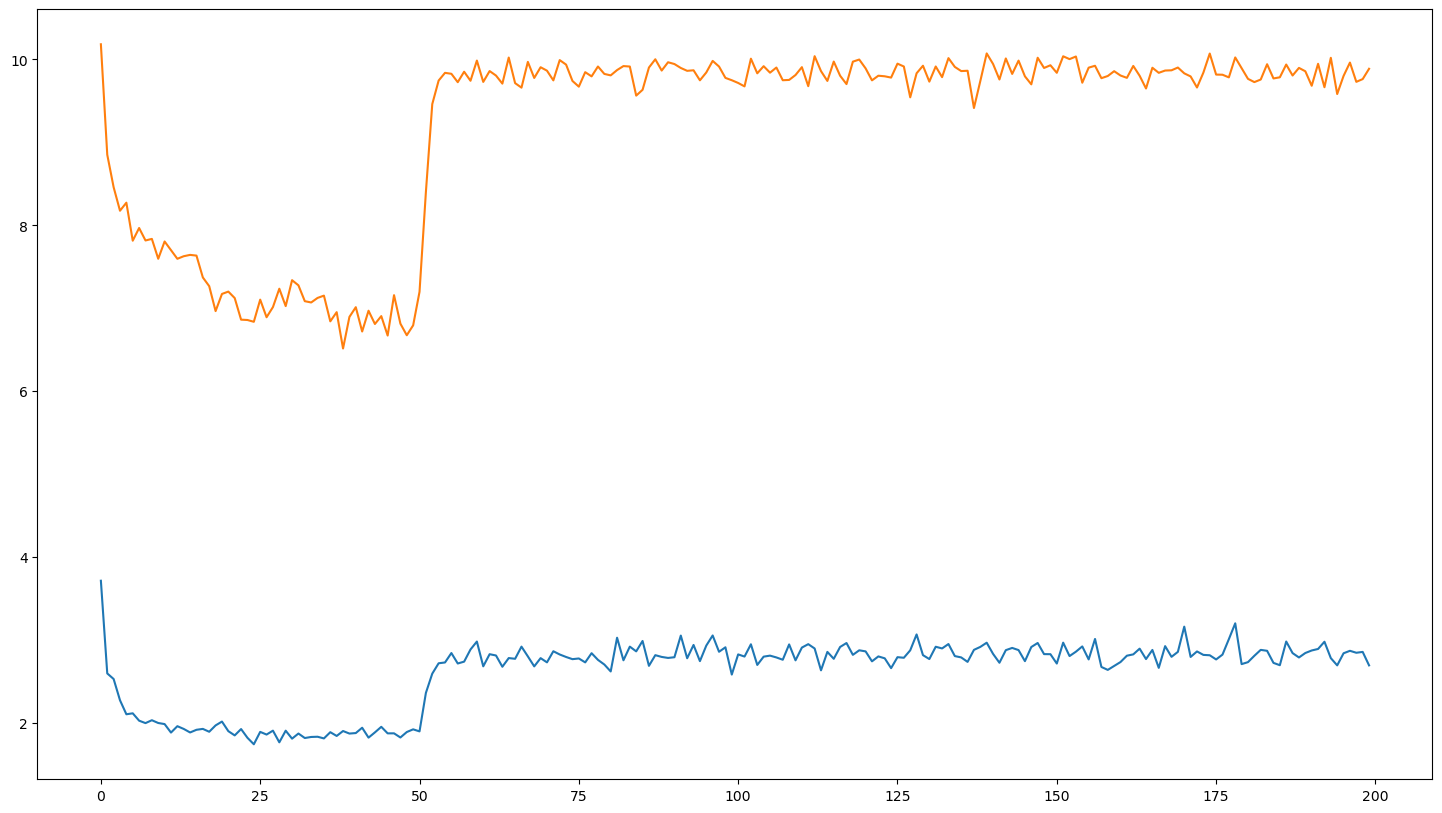

In [66]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_shift_ws_online_perturb['Gen_D_KL']))
ax.plot(np.array(Analytic_shift_ws_online_perturb['Data_D_KL']))
plt.show()

In [67]:
Analytic_shift_ws_online_perturb.to_csv('Analytic_shift_ws_online_perturb.csv', index = False)

In [68]:
parameters = {'Phi': Phi, 'Theta': Theta}
np.save('Parameters_shift_ws_online_perturb',parameters)

### 4. Train with Batch (Shift Patterns)

In [37]:
dev = torch.device("cuda") # operate on GPU "cuda" or CPU "cpu"

In [70]:
data_dist = data_dist.to(dev)
data_dist

tensor([1.6777e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        2.5600e-06], device='cuda:0')

In [71]:
data_dist.sum()

tensor(1.0000, device='cuda:0')

In [72]:
Analytic_shift_batch = pd.DataFrame(columns=col_list)
Analytic_shift_batch

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,...,Gen_H_Layer_5,Gen_H_Layer_6,Gen_H_Layer_7,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7


In [73]:
Phi,Theta = para_init(n_dz,dev)

In [40]:
n_data = 1000
batch_size = n_data
lr = 0.1
epoch = 100000
gen_batch_size = 60000

In [1]:
# for e in range(epoch):
#     data = Shift_pattern_data(n_data,dev).reshape(16,n_data)
#     Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev,perturb=False)
#     Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
#     print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
#     if e%1000 == 0:
#         stat = []
#         stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
#         stat = stat + list((Loss_sleep).to('cpu').numpy())

#         if e%10000 == 0:
#             gen_data = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
#             values_g,counts_g = torch.unique(decimalize(gen_data,dev),return_counts=True)
#             gen_dist = torch.zeros(2**n_d,device=dev)
#             gen_dist[values_g]=counts_g/gen_batch_size

#             k = 0
#             gen_data = gen_data.to('cpu')
#             for j in range(gen_data.shape[1]):
#                 if torch.equal(gen_data[:8,j], torch.cat((gen_data[9:,j],gen_data[8:9,j]))) or \
#                     torch.equal(gen_data[:8,j], torch.cat((gen_data[-1:,j],gen_data[8:-1,j]))):
#                     k += 1
                
#         stat.append(KL_divergence(gen_dist,data_dist).item())
#         stat.append(KL_divergence(data_dist,gen_dist).item())
#         stat.append(k/gen_batch_size)
        
#         H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,5),dev) # batch_size = 50000
#         H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
#         stat = stat + list(H_Y_wake.to('cpu').numpy()) + list(I_wake.to('cpu').numpy()) \
#                 + list(H_Y_sleep.to('cpu').numpy()) + list(I_sleep.to('cpu').numpy())
#         Analytic_shift_batch.loc[len(Analytic_shift_batch)] = stat

In [193]:
Analytic_shift_batch

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,...,Gen_H_Layer_5,Gen_H_Layer_6,Gen_H_Layer_7,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,...,4.158878,2.772588,1.386294,0.001626,0.000010,0.000005,0.000003,0.000002,0.000001,2.384186e-07
1,0.649278,0.683208,0.690990,0.692189,0.692880,0.693033,0.692935,0.471492,0.660129,0.682680,...,4.158354,2.772531,1.386241,0.317548,0.044245,0.011936,0.002863,0.000886,0.000291,8.988380e-05
2,0.637031,0.670264,0.680075,0.689029,0.693123,0.692212,0.693103,0.475922,0.649396,0.670126,...,4.155980,2.772117,1.386104,0.377644,0.070234,0.030815,0.011179,0.003556,0.001050,2.996922e-04
3,0.624814,0.662520,0.682002,0.686117,0.691686,0.690697,0.692937,0.452378,0.650993,0.666509,...,4.150042,2.770585,1.385154,0.589845,0.079701,0.042243,0.016241,0.006399,0.002752,1.108408e-03
4,0.595576,0.653380,0.674521,0.682468,0.690584,0.691187,0.687658,0.411030,0.646742,0.660339,...,4.149103,2.767329,1.378997,1.107368,0.086213,0.052793,0.024539,0.009116,0.003231,3.267050e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.314414,0.342907,0.537397,0.566825,0.587696,0.653991,0.521483,0.158724,0.392463,0.455708,...,3.993039,2.712625,1.191810,5.306151,3.298218,1.443384,0.569100,0.476070,0.095172,1.706052e-01
496,0.322697,0.351019,0.529784,0.563319,0.588888,0.654486,0.482275,0.168301,0.391157,0.461094,...,3.995548,2.712843,1.186227,5.311510,3.306953,1.439534,0.571718,0.476904,0.095562,1.708512e-01
497,0.312928,0.353880,0.526755,0.574068,0.584498,0.658431,0.506898,0.154402,0.394681,0.453679,...,3.991195,2.712730,1.188912,5.332788,3.315802,1.449518,0.573571,0.469425,0.097899,1.699700e-01
498,0.320717,0.349708,0.530123,0.569663,0.579121,0.657763,0.508157,0.160305,0.395449,0.455064,...,3.989475,2.711155,1.180620,5.315720,3.308691,1.448353,0.576218,0.472842,0.098764,1.721745e-01


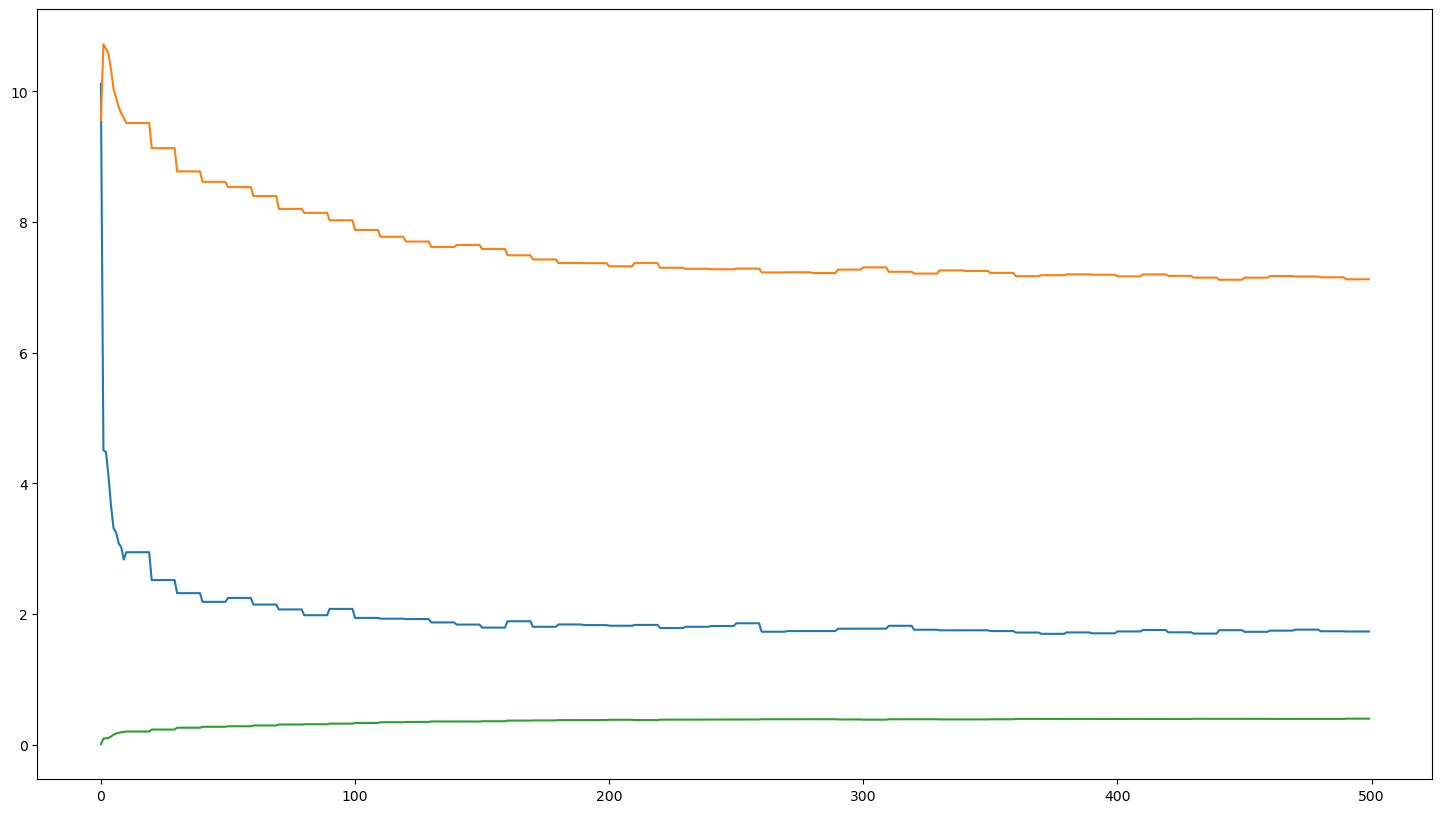

In [194]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_shift_batch['Gen_D_KL']))
ax.plot(np.array(Analytic_shift_batch['Data_D_KL']))
ax.plot(np.array(Analytic_shift_batch['Accuracy']))
plt.show()

In [195]:
Analytic_shift_batch.to_csv('Analytic_shift_batch.csv', index = False)

In [196]:
parameters = {'Phi': Phi, 'Theta': Theta}
np.save('Parameters_shift_batch',parameters)

In [42]:
para = torch.load('Parameters_shift_batch', dev,weights_only=True)
Phi = para['Phi']
Theta = para['Theta']

In [43]:
k = 0
gen_data = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"].to('cpu')
for j in range(gen_data.shape[1]):
    if torch.equal(gen_data[:8,j], torch.cat((gen_data[9:,j],gen_data[8:9,j]))) or \
        torch.equal(gen_data[:8,j], torch.cat((gen_data[-1:,j],gen_data[8:-1,j]))):
        k += 1
k/gen_batch_size

0.40086666666666665

### Plot Analytic

In [6]:
Analytic_shift_ws_online_continue = pd.read_csv('Analytic_shift_ws_online_continue.csv', sep=",")
Analytic_shift_ws_online_MI = pd.read_csv('Analytic_shift_ws_online_MI.csv', sep=",")
Analytic_shift_ws_online_perturb = pd.read_csv('Analytic_shift_ws_online_perturb.csv', sep=",")
Analytic_shift_batch = pd.read_csv('Analytic_shift_batch.csv', sep=",")

In [7]:
Analytic = Analytic_shift_ws_online_MI
Analytic

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,...,Gen_H_Layer_5,Gen_H_Layer_6,Gen_H_Layer_7,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7
0,0.655633,0.571985,0.558816,0.601158,0.625530,0.634833,0.640671,0.477506,0.679399,0.581523,...,3.714419,2.628021,1.358096,1.088946,0.713392,0.402592,0.337388,0.279556,0.180200,0.101256
1,0.393723,0.411351,0.459724,0.487509,0.530218,0.538705,0.522781,0.271545,0.465700,0.430444,...,3.814557,2.617047,1.295791,3.375550,1.757976,1.465564,0.964380,0.754626,0.517842,0.199070
2,0.382757,0.359798,0.446301,0.450049,0.496051,0.529376,0.468505,0.265308,0.445660,0.395902,...,3.588273,2.402690,1.249453,3.621478,2.162318,1.633370,1.073516,0.734443,0.452110,0.373176
3,0.351038,0.363958,0.438509,0.457817,0.441942,0.540376,0.365396,0.222303,0.437571,0.394547,...,3.500305,2.642266,1.076303,4.059014,2.105663,1.528430,1.129873,0.915961,0.642489,0.296746
4,0.344868,0.346568,0.401235,0.477702,0.400480,0.555822,0.345918,0.234545,0.411906,0.392750,...,3.163184,2.661177,1.002520,4.254811,2.474658,1.676711,1.197370,0.854317,0.599261,0.313349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.285533,0.195180,0.312287,0.171675,0.199699,0.308183,0.176723,0.160687,0.293311,0.258547,...,3.212436,2.597911,0.873811,5.608266,4.592198,3.430099,2.792391,2.277050,1.627071,0.656676
196,0.291683,0.187910,0.284682,0.210899,0.224198,0.273935,0.209999,0.151870,0.308354,0.237654,...,3.352927,2.348157,1.026390,5.370078,4.441976,3.425682,2.868424,2.226391,1.584847,0.833367
197,0.290983,0.207535,0.308729,0.193569,0.239075,0.271032,0.212409,0.160802,0.301509,0.263878,...,3.357710,2.496121,1.074260,5.653373,4.525362,3.743950,2.885859,2.167946,1.559155,0.822317
198,0.293691,0.189311,0.285215,0.195484,0.202114,0.278491,0.180810,0.158305,0.288719,0.249308,...,3.277055,2.417963,1.007604,5.569183,4.706220,3.792325,2.770215,2.310346,1.585049,0.838042


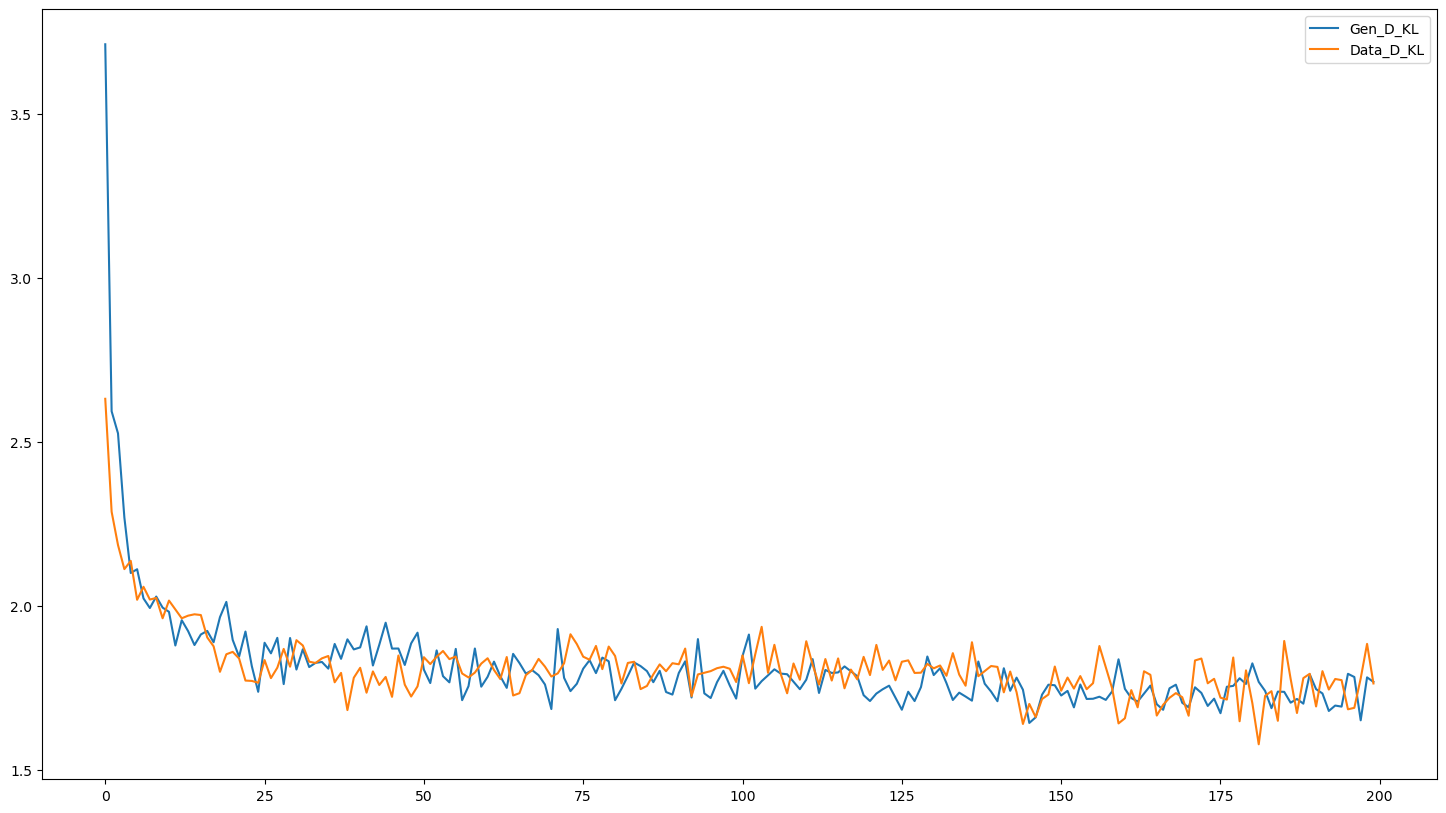

In [8]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Gen_D_KL']),label = 'Gen_D_KL')
ax.plot(np.array(Analytic['Data_D_KL'])/np.array(Analytic['Data_D_KL']).mean()*np.array(Analytic['Gen_D_KL']).mean(),label='Data_D_KL')
# ax.plot(np.array(Analytic['Data_D_KL']),label = 'Data_D_KL')
ax.legend()
plt.show()

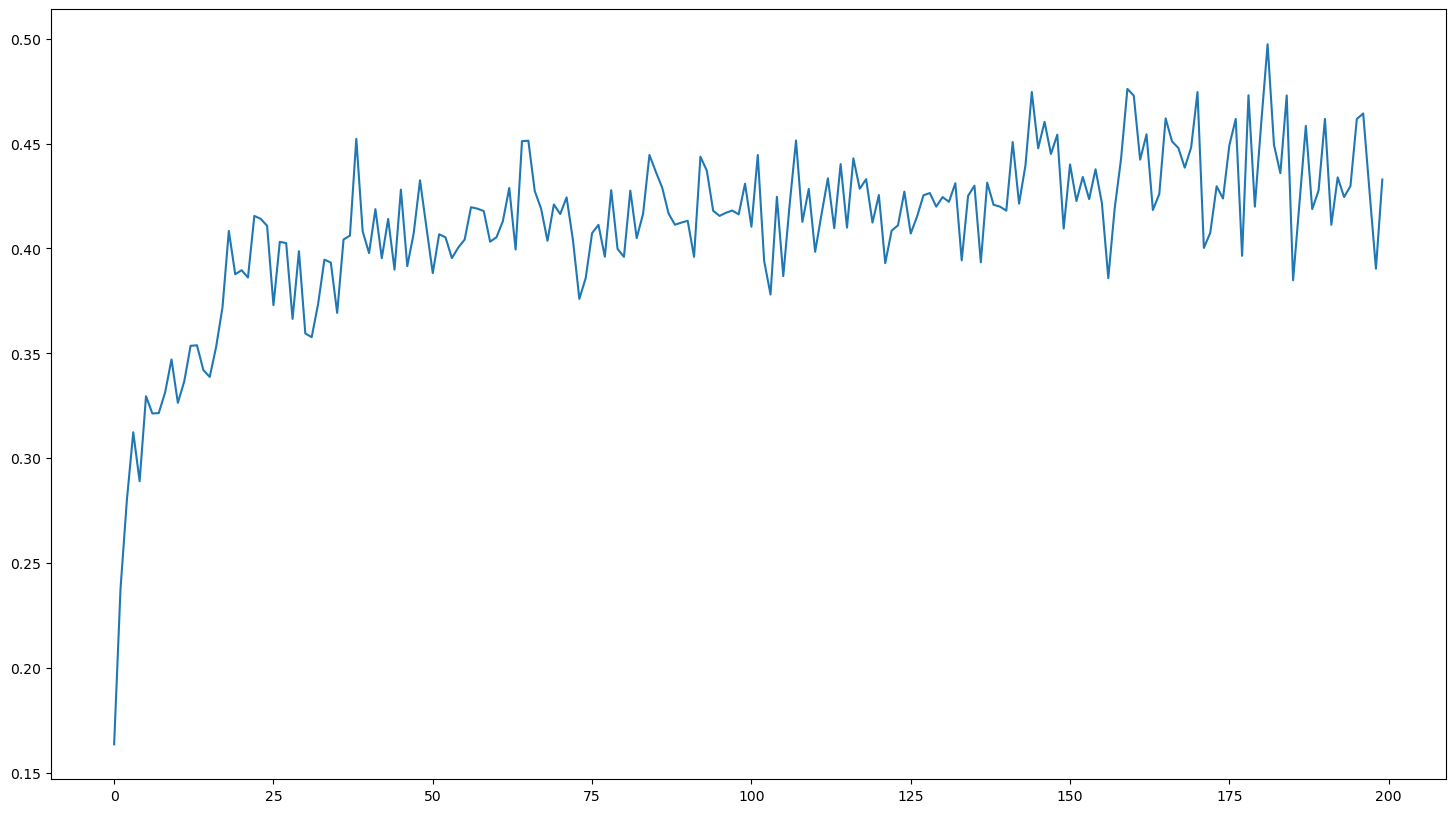

In [9]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Accuracy']))
plt.show()

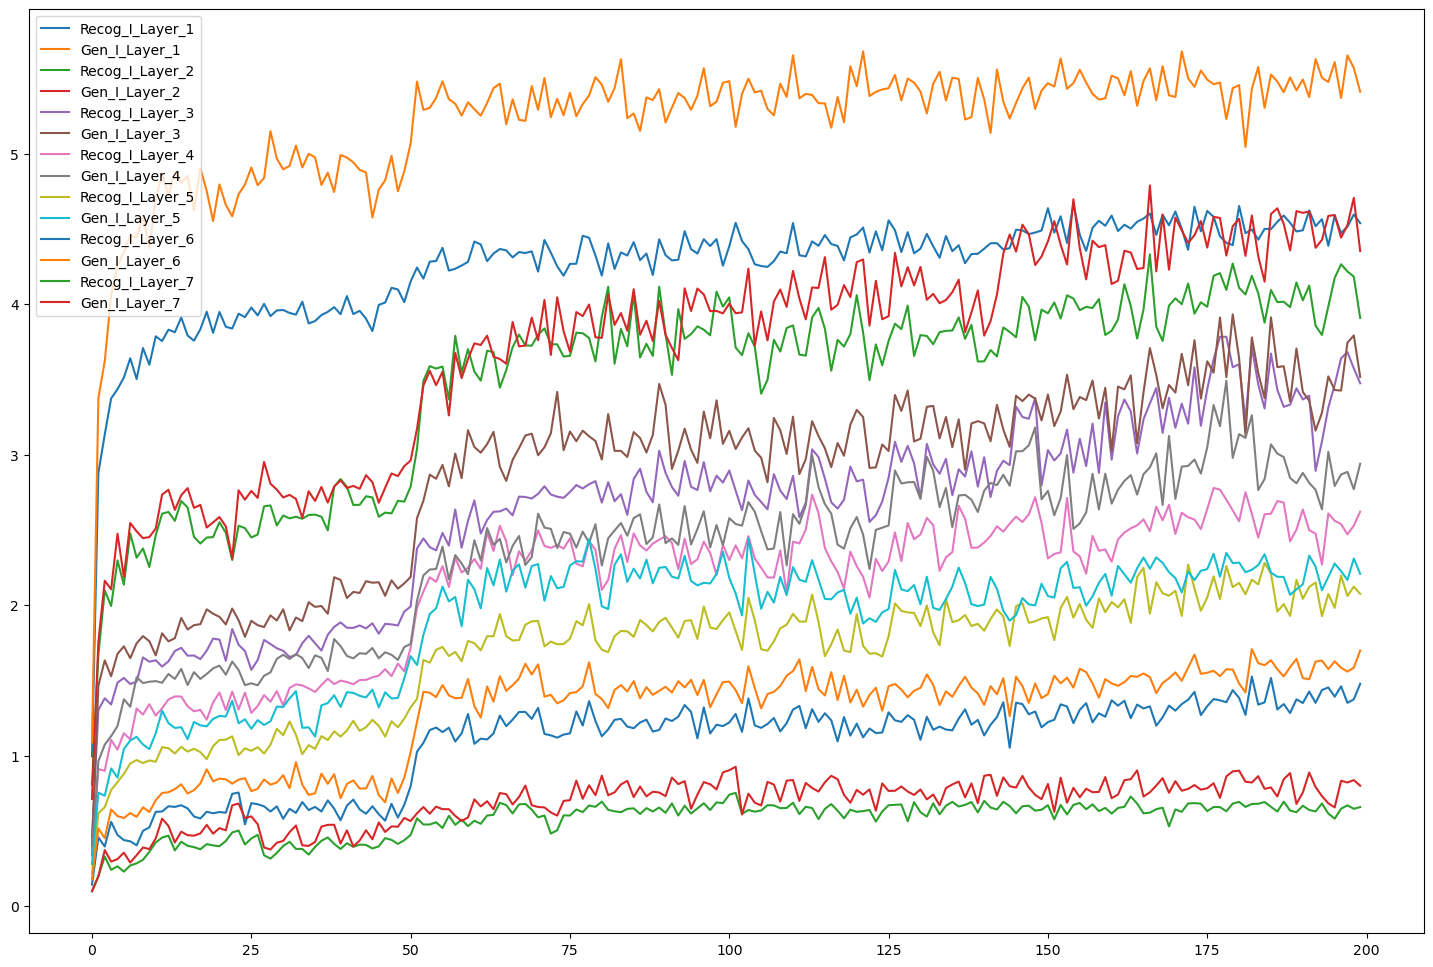

In [10]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

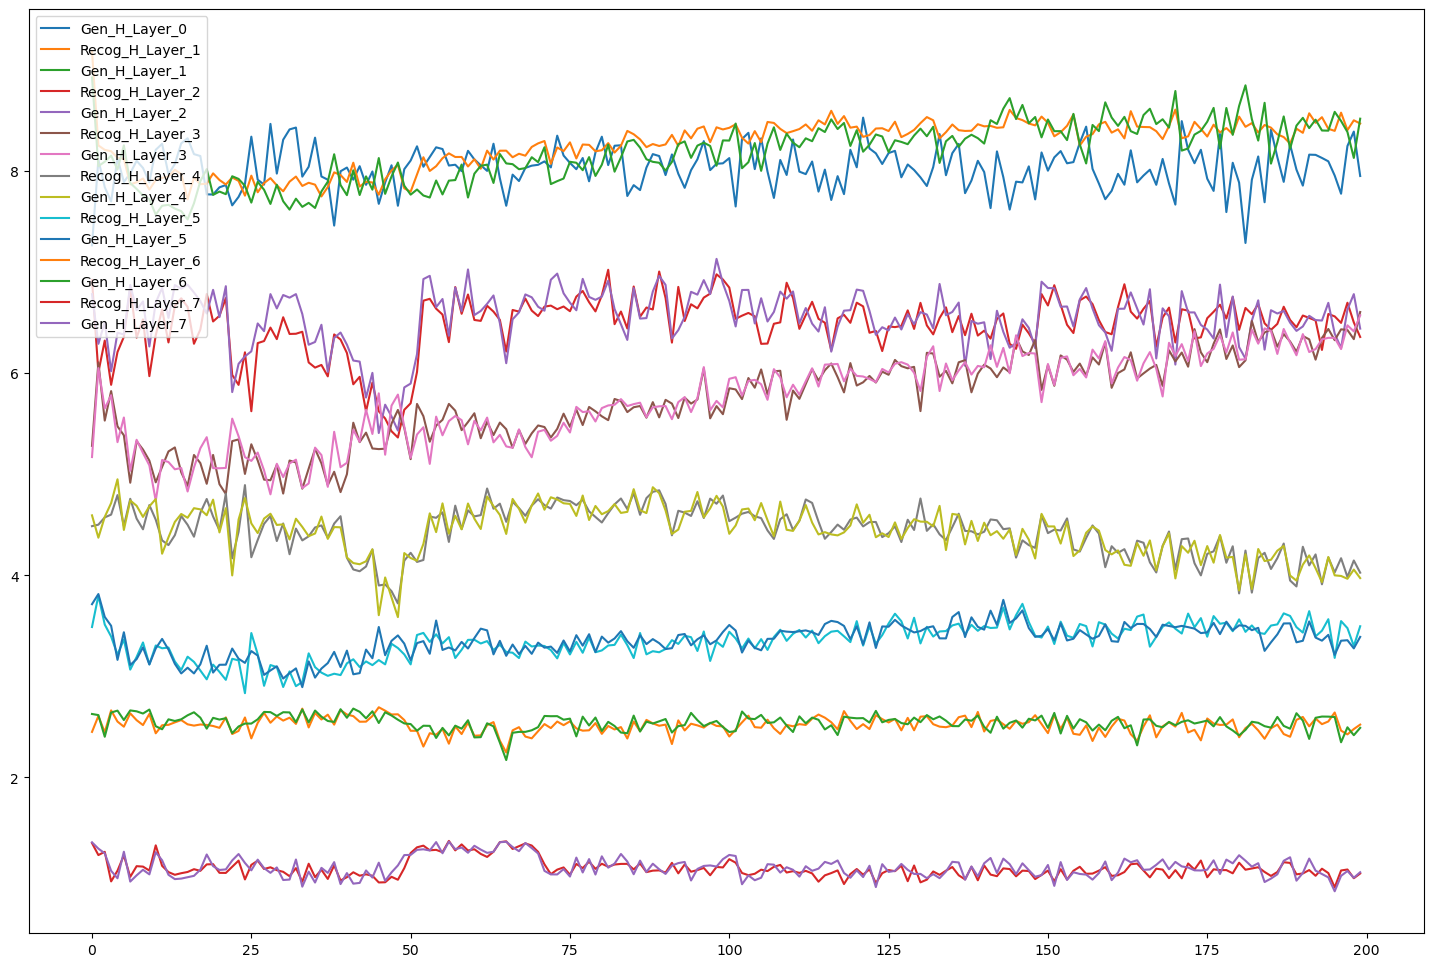

In [11]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

In [12]:
n_dz * np.log(2)

tensor([11.0904,  9.7041,  8.3178,  6.9315,  5.5452,  4.1589,  2.7726,  1.3863,
         0.6931])

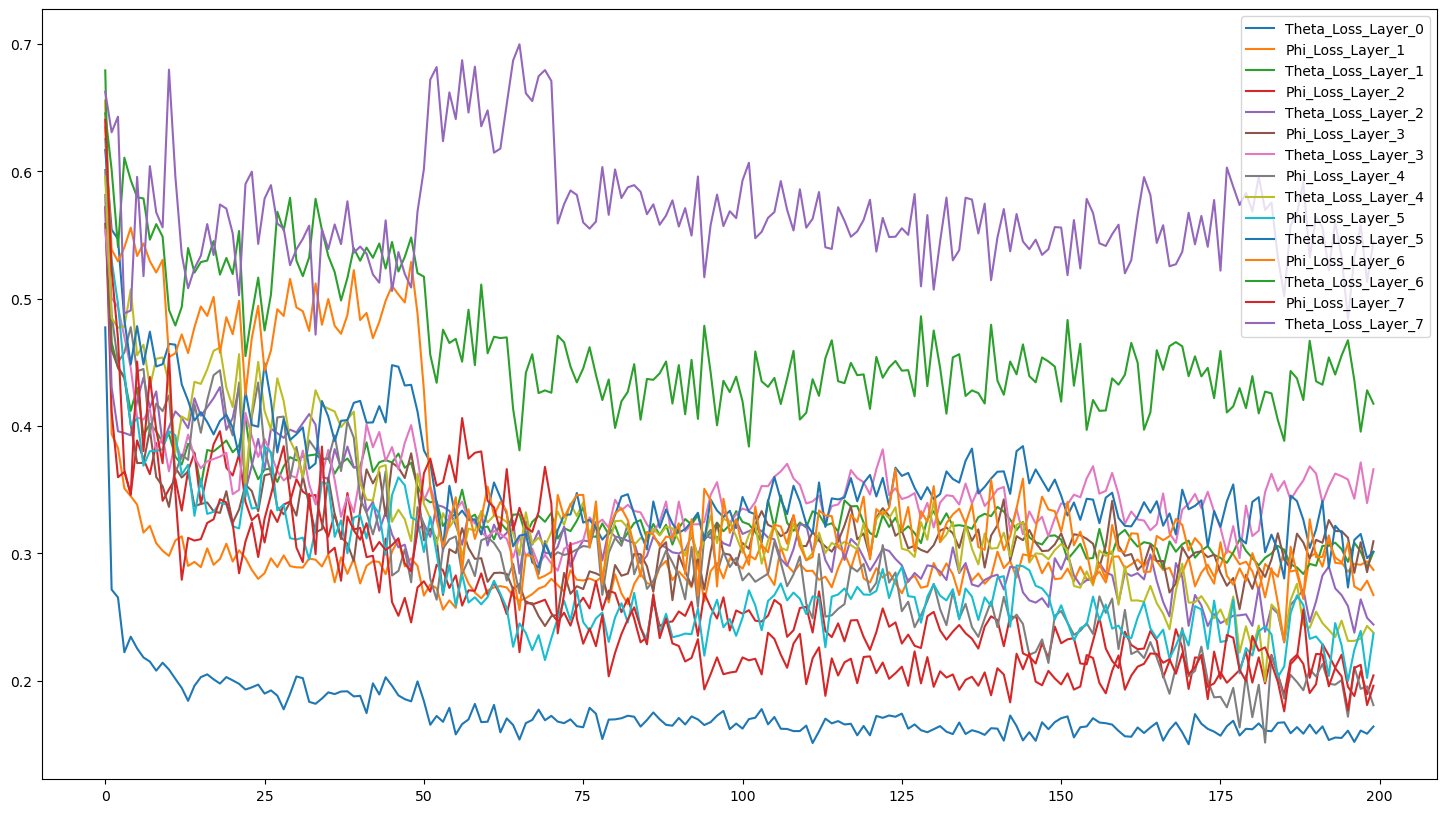

In [13]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

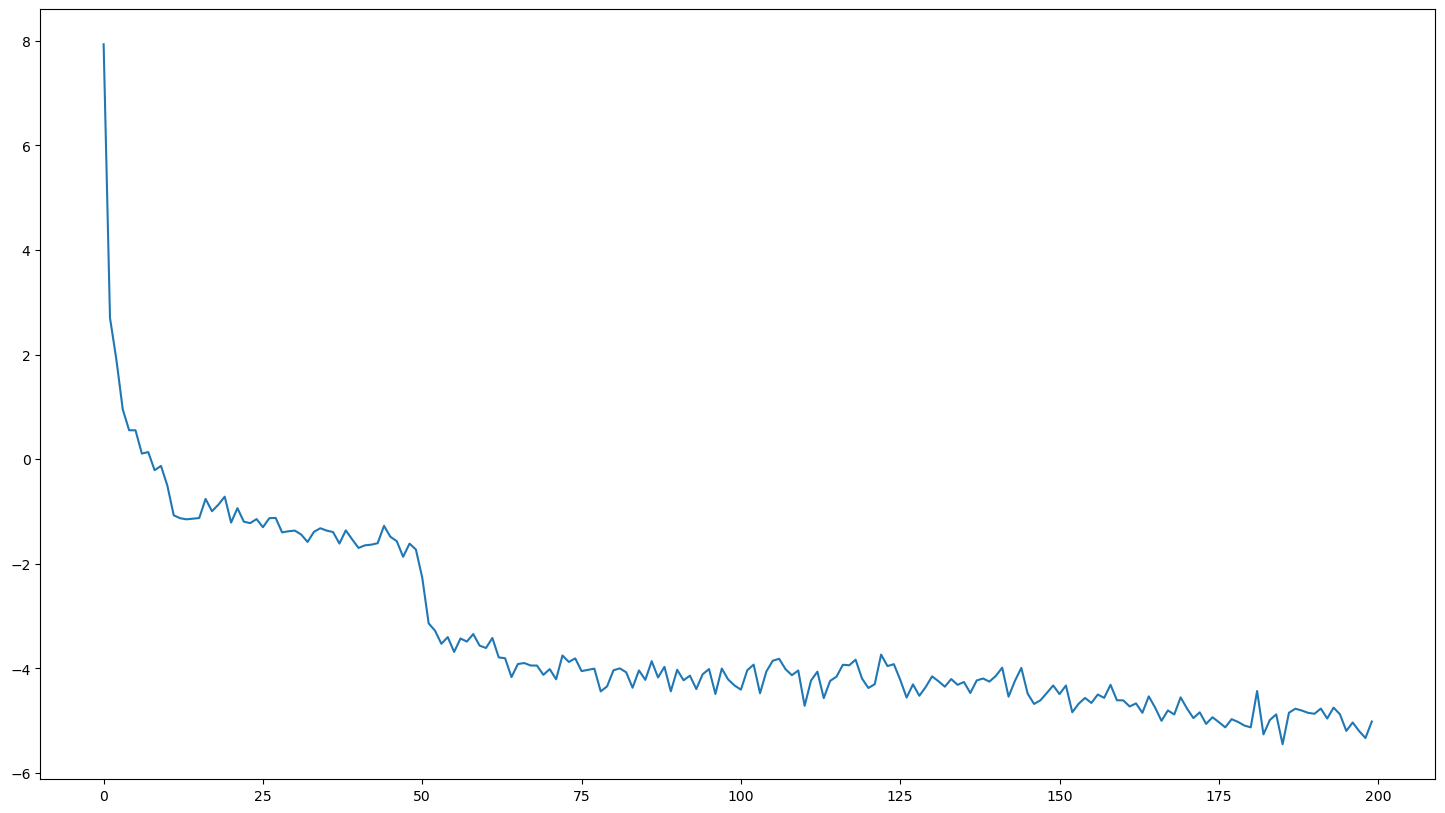

In [14]:
# normalized loss
Loss = 2*(np.array(Analytic['Theta_Loss_Layer_'+str(0)])-(np.array(Analytic['Gen_I_Layer_1'])/structure[i]))
for i in range(1,n_layer-2):
    Loss += np.array(Analytic['Phi_Loss_Layer_'+str(i)]) + np.array(Analytic['Theta_Loss_Layer_'+str(i)]) - \
    (np.array(Analytic['Gen_I_Layer_'+str(i+1)])+np.array(Analytic['Recog_I_Layer_'+str(i)]))/structure[i]
Loss += np.array(Analytic['Phi_Loss_Layer_'+str(n_layer-2)]) + np.array(Analytic['Theta_Loss_Layer_'+str(n_layer-2)]) - \
        np.array(Analytic['Recog_I_Layer_'+str(n_layer-2)])/structure[n_layer-2]
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(Loss)
plt.show()

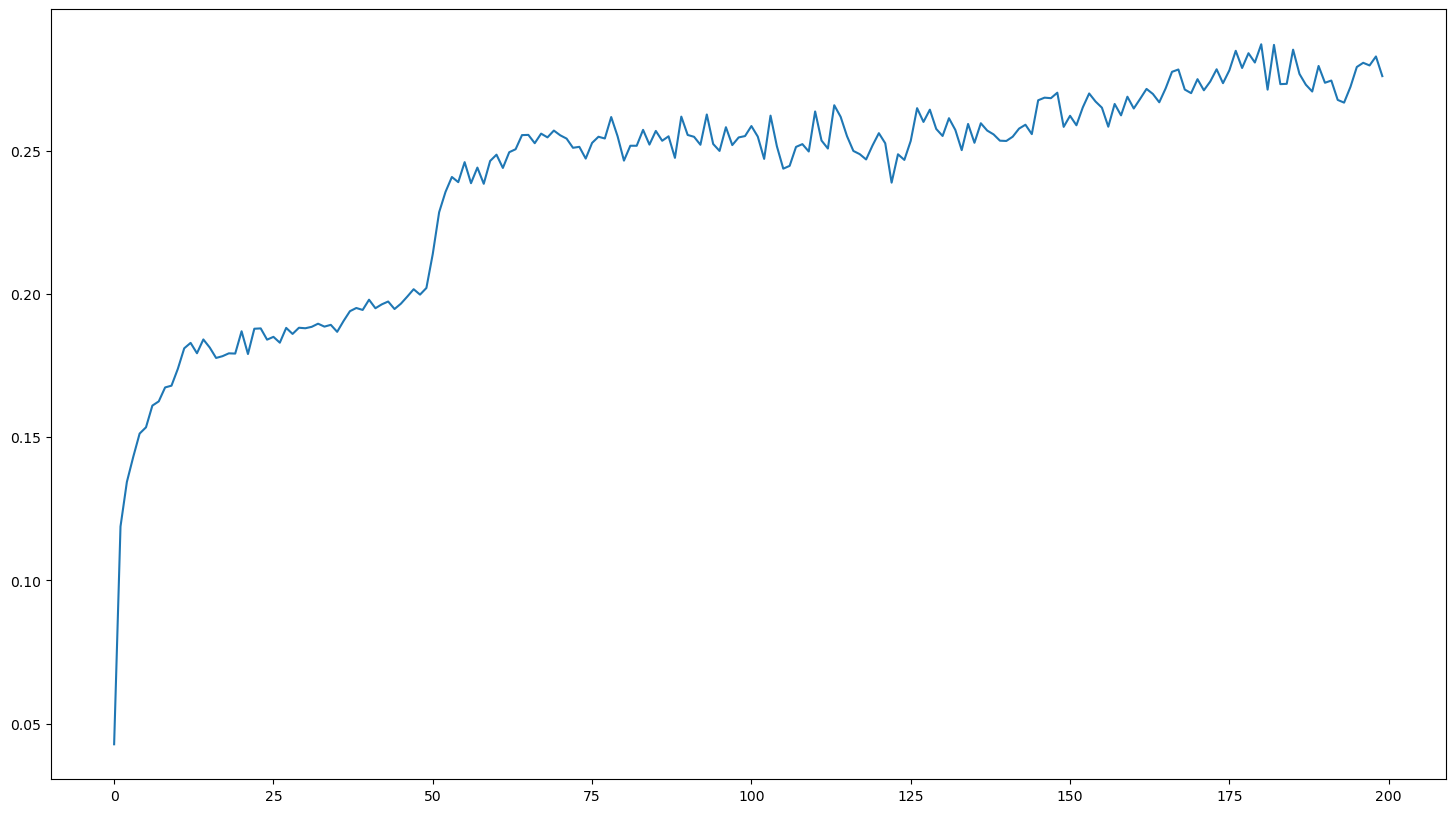

In [15]:
# normalized mutual information
I = np.array(Analytic['Recog_I_Layer_'+str(1)]) + np.array(Analytic['Gen_I_Layer_'+str(1)])
H = np.array(Analytic['Recog_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)])
for i in range(1,n_layer-2):
    I += np.array(Analytic['Recog_I_Layer_'+str(i+1)]) + np.array(Analytic['Gen_I_Layer_'+str(i+1)])
    H += np.array(Analytic['Recog_H_Layer_'+str(i+1)]) + np.array(Analytic['Recog_H_Layer_'+str(i)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(i+1)]) + np.array(Analytic['Gen_H_Layer_'+str(i)])
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(I/H)
plt.show()

In [4]:
Table = pd.read_csv('Table_shift.csv', sep=",")
Table

,Algorithm,Data_D_KL,Gen_D_KL,Accuracy,Normalized_Loss,Normalized_MI
0,WS,6.896038,1.847694,0.407998,-0.323749,0.224654
1,MIM,6.766151,1.734470,0.437290,-2.112703,0.273343
2,Ptb,9.841627,2.830329,0.176184,6.514334,0.085513
3,Batch,7.124401,1.733745,0.399580,3.678697,0.134583


In [80]:
Table = pd.DataFrame(columns=['Algorithm','Data_D_KL','Gen_D_KL','Accuracy','Normalized_Loss','Normalized_MI'])
Table

,Algorithm,Data_D_KL,Gen_D_KL,Accuracy,Normalized_Loss,Normalized_MI


In [18]:
Analytic = Analytic_shift_batch
stat = ['Batch']

In [207]:
# stat = stat + [np.array(Analytic['Data_D_KL'])[-50:].mean(),np.array(Analytic['Gen_D_KL'])[-50:].mean(),np.array(Analytic['Accuracy'])[-50:].mean()]
stat = stat + [np.array(Analytic['Data_D_KL'])[-1],np.array(Analytic['Gen_D_KL'])[-1],np.array(Analytic['Accuracy'])[-1]] # batch
stat

['Batch', 7.124400615692139, 1.733744740486145, 0.39958]

In [19]:
Loss = 2*np.array(Analytic['Theta_Loss_Layer_'+str(0)])-((np.array(Analytic['Gen_I_Layer_1']))+ \
                                                         np.array(Analytic['Gen_H_Layer_0']))/structure[0]
for i in range(1,n_layer-2):
    Loss += np.array(Analytic['Phi_Loss_Layer_'+str(i)]) + np.array(Analytic['Theta_Loss_Layer_'+str(i)]) - \
    (np.array(Analytic['Gen_I_Layer_'+str(i+1)])+np.array(Analytic['Recog_I_Layer_'+str(i)])+
    np.array(Analytic['Gen_H_Layer_'+str(i)])+np.array(Analytic['Recog_H_Layer_'+str(i)]))/structure[i]/2
Loss += np.array(Analytic['Phi_Loss_Layer_'+str(n_layer-2)]) + np.array(Analytic['Theta_Loss_Layer_'+str(n_layer-2)]) - \
        np.array(Analytic['Recog_I_Layer_'+str(n_layer-2)]+np.array(Analytic['Gen_H_Layer_'+str(n_layer-2)])+ \
                 np.array(Analytic['Recog_H_Layer_'+str(n_layer-2)]))/structure[n_layer-2]/2
stat.append(Loss[-50:].mean())
stat

['Batch', 1.7727936011779875]

In [20]:
Table.at[3,'Normalized_Loss'] = 1.7727936011779875

In [21]:
Table

,Algorithm,Data_D_KL,Gen_D_KL,Accuracy,Normalized_Loss,Normalized_MI
0,WS,6.896038,1.847694,0.407998,-0.916522,0.224654
1,MIM,6.766151,1.734470,0.437290,-2.292115,0.273343
2,Ptb,9.841627,2.830329,0.176184,3.309385,0.085513
3,Batch,7.124401,1.733745,0.399580,1.772794,0.134583


In [209]:
I = np.array(Analytic['Recog_I_Layer_'+str(1)]) + np.array(Analytic['Gen_I_Layer_'+str(1)])
H = np.array(Analytic['Recog_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)])
for i in range(1,n_layer-2):
    I += np.array(Analytic['Recog_I_Layer_'+str(i+1)]) + np.array(Analytic['Gen_I_Layer_'+str(i+1)])
    H += np.array(Analytic['Recog_H_Layer_'+str(i+1)]) + np.array(Analytic['Recog_H_Layer_'+str(i)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(i+1)]) + np.array(Analytic['Gen_H_Layer_'+str(i)])
stat.append((I/H)[-50:].mean())
stat

['Batch',
 7.124400615692139,
 1.733744740486145,
 0.39958,
 3.67869700551033,
 0.13458261286561762]

In [210]:
Table.loc[len(Table)] = stat
Table

,Algorithm,Data_D_KL,Gen_D_KL,Accuracy,Normalized_Loss,Normalized_MI
0,WS,6.896038,1.847694,0.407998,-0.323749,0.224654
1,MIM,6.766151,1.734470,0.437290,-2.112703,0.273343
2,Ptb,9.841627,2.830329,0.176184,6.514334,0.085513
3,Batch,7.124401,1.733745,0.399580,3.678697,0.134583


In [22]:
Table.to_csv('Table_shift.csv', index = False)